In [1]:
%run function_and_library.ipynb
from datetime import datetime

In [2]:
def parser(x):
    return datetime.strptime(x, '%Y-%m-%d')


def open_file(num_row):
    series = pd.read_csv('./currency_data_10_years.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    
    currency = series.columns.tolist()
    
    series = series.iloc[:,num_row-1]

    series = series.resample('3D').mean()
            
    time = series.index

    return time, series, currency

In [3]:
def prepared_data(series, time, split_time, window_size, batch_size, shuffle_buffer_size):
    x_train = series[:split_time]
    time_train = time[:split_time]

    x_valid = series[split_time:]
    time_valid = time[split_time:]

    train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
    valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
    
    return train_set, valid_set

In [4]:
def plot_loss(history):
    # Get mae and loss from history log
    loss=history.history['loss']
    val_loss=history.history['val_loss']

    # Get number of epochs
    epochs=range(len(loss))

    plot_series(
        x=epochs, 
        y=(loss, val_loss), 
        title='LOSS and val LOSS', 
        xlabel='LOSS',
        ylabel='val LOSS',
        legend=['LOSS', 'val LOSS']
        )

In [5]:
def first_model(train_set, valid_set, window_size):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, input_shape=[window_size], activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ], name=f"1_model_{currency[count]}")

    # Get initial weights
    init_weights = model.get_weights()

    # Reset states generated by Keras
    tf.keras.backend.clear_session()

    # Reset the weights
    model.set_weights(init_weights)

    model.summary()

    # Initialize the optimizer
    optimizer = tf.keras.optimizers.Adam()

    # Set the training parameters
    model.compile(loss=tf.keras.losses.Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])

    # Train the model
    history = model.fit(train_set,
                          epochs=100,
                          verbose=1,
                          batch_size=batch_size,
                          validation_data=valid_set,
                          callbacks=[create_model_checkpoint()])
    model.evaluate(valid_set)
    plot_loss(history)
    
    return model


In [6]:
def second_model(train_set, valid_set, window_size):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(256, input_shape=[window_size], activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1)
    ], name=f"2_model_{currency[count]}")

    # Get initial weights
    init_weights = model.get_weights()

    # Reset states generated by Keras
    tf.keras.backend.clear_session()

    # Reset the weights
    model.set_weights(init_weights)

    model.summary()

    # Initialize the optimizer
    optimizer = tf.keras.optimizers.Adam()

    # Set the training parameters
    model.compile(loss=tf.keras.losses.Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])

    # Train the model
    history = model.fit(train_set,
                          epochs=100,
                          verbose=1,
                          batch_size=batch_size,
                          validation_data=valid_set,
                          callbacks=[create_model_checkpoint()])
    model.evaluate(valid_set)
    plot_loss(history)
    
    return model


In [7]:
def evaluate_model(model, series, split_time, window_size, batch_size, count, eval_models, currency):

    # Reduce the original series
    forecast_series = series[split_time-window_size:-1]

    # Use helper function to generate predictions
    forecast = model_forecast(model, forecast_series, window_size, batch_size)

    # Drop single dimensional axes
    results = forecast.squeeze()

    # Plot the results
    plot_series(time[split_time:], (series[split_time:], results))

    eval_model = evaluate_preds(y_true=series[split_time:],
                                   y_pred=results)
    print(eval_model)
    
    model_name = f"model_{currency}/IDR"
    eval_models[model_name] = eval_model

<ipython-input-2-5c4b28aa2962>:6: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = pd.read_csv('./currency_data_10_years.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


Model: "1_model_EUR"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2688      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,057
Trainable params: 13,057
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
     22/Unknown - 3s 2ms/step - loss: 4655.0854 - mae: 4654.1099 

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


31/31 [==============================] - 9s 230ms/step - loss: 3575.6953 - mae: 3574.7744 - val_loss: 461.0812 - val_mae: 460.3560
Epoch 2/100
21/31 [===================>..........] - ETA: 0s - loss: 508.7419 - mae: 508.1098

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


31/31 [==============================] - 2s 76ms/step - loss: 464.2725 - mae: 463.6789 - val_loss: 331.3289 - val_mae: 330.8568
Epoch 3/100
18/31 [================>.............] - ETA: 0s - loss: 308.8950 - mae: 308.4707

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


31/31 [==============================] - 3s 91ms/step - loss: 308.2017 - mae: 307.8074 - val_loss: 268.9612 - val_mae: 268.6386
Epoch 4/100
21/31 [===================>..........] - ETA: 0s - loss: 340.1852 - mae: 339.8949

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


31/31 [==============================] - 2s 73ms/step - loss: 332.7848 - mae: 332.5079 - val_loss: 239.1859 - val_mae: 238.9494
Epoch 5/100
23/31 [=====================>........] - ETA: 0s - loss: 302.2874 - mae: 302.0735

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


31/31 [==============================] - 2s 64ms/step - loss: 306.8403 - mae: 306.6324 - val_loss: 233.2221 - val_mae: 233.0380
Epoch 6/100
17/31 [===============>..............] - ETA: 0s - loss: 326.6997 - mae: 326.5238

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


31/31 [==============================] - 2s 66ms/step - loss: 317.7897 - mae: 317.6201 - val_loss: 212.9228 - val_mae: 212.7654
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 313.4604 - mae: 313.3127 - val_loss: 220.4196 - val_mae: 220.2800
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 277.7303 - mae: 277.5952 - val_loss: 223.1129 - val_mae: 222.9798
Epoch 9/100
20/31 [==================>...........] - ETA: 0s - loss: 288.7251 - mae: 288.5955

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


31/31 [==============================] - 2s 63ms/step - loss: 281.0745 - mae: 280.9456 - val_loss: 211.4902 - val_mae: 211.3640
Epoch 10/100
17/31 [===============>..............] - ETA: 0s - loss: 258.1610 - mae: 258.0346

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


31/31 [==============================] - 3s 82ms/step - loss: 266.3073 - mae: 266.1816 - val_loss: 195.0545 - val_mae: 194.9293
Epoch 11/100
31/31 [==============================] - ETA: 0s - loss: 268.7074 - mae: 268.5828

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


31/31 [==============================] - 3s 77ms/step - loss: 268.7074 - mae: 268.5828 - val_loss: 182.0541 - val_mae: 181.9310
Epoch 12/100
31/31 [==============================] - 1s 9ms/step - loss: 257.7566 - mae: 257.6330 - val_loss: 236.5753 - val_mae: 236.4528
Epoch 13/100
31/31 [==============================] - 1s 8ms/step - loss: 291.1737 - mae: 291.0508 - val_loss: 220.5868 - val_mae: 220.4647
Epoch 14/100
31/31 [==============================] - 1s 9ms/step - loss: 335.1811 - mae: 335.0591 - val_loss: 193.5620 - val_mae: 193.4408
Epoch 15/100
31/31 [==============================] - 0s 7ms/step - loss: 333.2373 - mae: 333.1155 - val_loss: 460.7710 - val_mae: 460.6499
Epoch 16/100
19/31 [=================>............] - ETA: 0s - loss: 292.6409 - mae: 292.5195

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


31/31 [==============================] - 5s 147ms/step - loss: 288.7777 - mae: 288.6565 - val_loss: 167.7540 - val_mae: 167.6332
Epoch 17/100
31/31 [==============================] - 0s 7ms/step - loss: 278.3448 - mae: 278.2232 - val_loss: 389.9017 - val_mae: 389.7796
Epoch 18/100
31/31 [==============================] - 1s 9ms/step - loss: 256.9783 - mae: 256.8570 - val_loss: 324.8234 - val_mae: 324.7019
Epoch 19/100
31/31 [==============================] - 0s 6ms/step - loss: 253.6261 - mae: 253.5053 - val_loss: 219.4596 - val_mae: 219.3388
Epoch 20/100
17/31 [===============>..............] - ETA: 0s - loss: 221.6183 - mae: 221.4973

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


31/31 [==============================] - 4s 110ms/step - loss: 227.2250 - mae: 227.1036 - val_loss: 155.8683 - val_mae: 155.7457
Epoch 21/100
31/31 [==============================] - 0s 7ms/step - loss: 238.3304 - mae: 238.2088 - val_loss: 188.1988 - val_mae: 188.0772
Epoch 22/100
31/31 [==============================] - 0s 7ms/step - loss: 257.3654 - mae: 257.2440 - val_loss: 158.0698 - val_mae: 157.9486
Epoch 23/100
31/31 [==============================] - 0s 9ms/step - loss: 230.9611 - mae: 230.8382 - val_loss: 157.7513 - val_mae: 157.6278
Epoch 24/100
19/31 [=================>............] - ETA: 0s - loss: 371.8614 - mae: 371.7393

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


31/31 [==============================] - 3s 97ms/step - loss: 330.4250 - mae: 330.3034 - val_loss: 151.5181 - val_mae: 151.3970
Epoch 25/100
31/31 [==============================] - 0s 6ms/step - loss: 252.8075 - mae: 252.6857 - val_loss: 184.7404 - val_mae: 184.6185
Epoch 26/100
18/31 [================>.............] - ETA: 0s - loss: 228.2644 - mae: 228.1433

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


31/31 [==============================] - 4s 113ms/step - loss: 215.5988 - mae: 215.4776 - val_loss: 144.2446 - val_mae: 144.1227
Epoch 27/100
31/31 [==============================] - 0s 7ms/step - loss: 225.3182 - mae: 225.1967 - val_loss: 252.4461 - val_mae: 252.3247
Epoch 28/100
31/31 [==============================] - 0s 6ms/step - loss: 235.1115 - mae: 234.9893 - val_loss: 282.8372 - val_mae: 282.7157
Epoch 29/100
18/31 [================>.............] - ETA: 0s - loss: 237.3483 - mae: 237.2267

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


31/31 [==============================] - 3s 105ms/step - loss: 225.8262 - mae: 225.7047 - val_loss: 142.1930 - val_mae: 142.0691
Epoch 30/100
31/31 [==============================] - 0s 8ms/step - loss: 205.3017 - mae: 205.1802 - val_loss: 159.0412 - val_mae: 158.9181
Epoch 31/100
16/31 [==============>...............] - ETA: 0s - loss: 202.2608 - mae: 202.1380

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


31/31 [==============================] - 4s 126ms/step - loss: 213.3120 - mae: 213.1893 - val_loss: 134.3266 - val_mae: 134.2048
Epoch 32/100
31/31 [==============================] - 0s 7ms/step - loss: 200.4852 - mae: 200.3631 - val_loss: 135.3653 - val_mae: 135.2432
Epoch 33/100
17/31 [===============>..............] - ETA: 0s - loss: 205.5924 - mae: 205.4674

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


31/31 [==============================] - 3s 103ms/step - loss: 203.0149 - mae: 202.8909 - val_loss: 129.1741 - val_mae: 129.0518
Epoch 34/100
31/31 [==============================] - 0s 5ms/step - loss: 228.9472 - mae: 228.8249 - val_loss: 250.7655 - val_mae: 250.6433
Epoch 35/100
31/31 [==============================] - 0s 8ms/step - loss: 241.3097 - mae: 241.1873 - val_loss: 214.1441 - val_mae: 214.0214
Epoch 36/100
31/31 [==============================] - 1s 10ms/step - loss: 230.0549 - mae: 229.9313 - val_loss: 162.1279 - val_mae: 162.0029
Epoch 37/100
31/31 [==============================] - 0s 6ms/step - loss: 187.9896 - mae: 187.8640 - val_loss: 169.3228 - val_mae: 169.1954
Epoch 38/100
31/31 [==============================] - 0s 7ms/step - loss: 208.9951 - mae: 208.8687 - val_loss: 145.2750 - val_mae: 145.1485
Epoch 39/100
31/31 [==============================] - 0s 6ms/step - loss: 208.5909 - mae: 208.4639 - val_loss: 160.7178 - val_mae: 160.5908
Epoch 40/100
30/31 [==========

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


31/31 [==============================] - 5s 148ms/step - loss: 241.4005 - mae: 241.2735 - val_loss: 124.6244 - val_mae: 124.4950
Epoch 41/100
31/31 [==============================] - 0s 6ms/step - loss: 195.7607 - mae: 195.6322 - val_loss: 165.6442 - val_mae: 165.5157
Epoch 42/100
31/31 [==============================] - 0s 7ms/step - loss: 240.8751 - mae: 240.7460 - val_loss: 206.9212 - val_mae: 206.7929
Epoch 43/100
31/31 [==============================] - 0s 6ms/step - loss: 188.5999 - mae: 188.4709 - val_loss: 157.0125 - val_mae: 156.8836
Epoch 44/100
31/31 [==============================] - 0s 7ms/step - loss: 172.4077 - mae: 172.2777 - val_loss: 206.9580 - val_mae: 206.8282
Epoch 45/100
20/31 [==================>...........] - ETA: 0s - loss: 227.1578 - mae: 227.0280

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


31/31 [==============================] - 5s 162ms/step - loss: 222.7646 - mae: 222.6348 - val_loss: 117.5347 - val_mae: 117.4049
Epoch 46/100
31/31 [==============================] - 1s 9ms/step - loss: 169.4303 - mae: 169.2995 - val_loss: 119.5487 - val_mae: 119.4177
Epoch 47/100
31/31 [==============================] - 1s 10ms/step - loss: 172.1216 - mae: 171.9893 - val_loss: 133.1189 - val_mae: 132.9874
Epoch 48/100
31/31 [==============================] - 1s 11ms/step - loss: 172.5256 - mae: 172.3938 - val_loss: 246.5317 - val_mae: 246.4001
Epoch 49/100
31/31 [==============================] - 1s 9ms/step - loss: 239.8658 - mae: 239.7344 - val_loss: 169.0735 - val_mae: 168.9422
Epoch 50/100
31/31 [==============================] - 0s 7ms/step - loss: 183.8958 - mae: 183.7641 - val_loss: 117.6338 - val_mae: 117.5025
Epoch 51/100
31/31 [==============================] - 1s 8ms/step - loss: 166.0318 - mae: 165.8988 - val_loss: 181.2698 - val_mae: 181.1373
Epoch 52/100
30/31 [=========

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


31/31 [==============================] - 4s 131ms/step - loss: 213.9767 - mae: 213.8446 - val_loss: 113.2413 - val_mae: 113.1097
Epoch 53/100
31/31 [==============================] - 1s 7ms/step - loss: 183.8622 - mae: 183.7305 - val_loss: 320.4955 - val_mae: 320.3644
Epoch 54/100
31/31 [==============================] - 0s 8ms/step - loss: 220.7735 - mae: 220.6417 - val_loss: 116.5218 - val_mae: 116.3898
Epoch 55/100
19/31 [=================>............] - ETA: 0s - loss: 153.5785 - mae: 153.4473

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


31/31 [==============================] - 4s 110ms/step - loss: 166.5219 - mae: 166.3908 - val_loss: 112.0343 - val_mae: 111.9019
Epoch 56/100
31/31 [==============================] - 0s 6ms/step - loss: 192.7886 - mae: 192.6575 - val_loss: 199.7614 - val_mae: 199.6305
Epoch 57/100
31/31 [==============================] - 0s 6ms/step - loss: 173.8504 - mae: 173.7184 - val_loss: 274.7736 - val_mae: 274.6425
Epoch 58/100
31/31 [==============================] - 0s 6ms/step - loss: 171.9948 - mae: 171.8637 - val_loss: 141.2796 - val_mae: 141.1487
Epoch 59/100
31/31 [==============================] - 0s 8ms/step - loss: 161.0068 - mae: 160.8750 - val_loss: 154.0882 - val_mae: 153.9572
Epoch 60/100
31/31 [==============================] - 0s 6ms/step - loss: 180.9035 - mae: 180.7720 - val_loss: 139.3584 - val_mae: 139.2270
Epoch 61/100
31/31 [==============================] - 0s 8ms/step - loss: 174.3289 - mae: 174.1963 - val_loss: 117.5165 - val_mae: 117.3848
Epoch 62/100
31/31 [===========

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


31/31 [==============================] - 5s 158ms/step - loss: 180.2558 - mae: 180.1244 - val_loss: 107.8758 - val_mae: 107.7447
Epoch 68/100
31/31 [==============================] - 0s 7ms/step - loss: 198.7541 - mae: 198.6230 - val_loss: 273.6265 - val_mae: 273.4943
Epoch 69/100
30/31 [============================>.] - ETA: 0s - loss: 163.2296 - mae: 163.0982

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


31/31 [==============================] - 2s 71ms/step - loss: 163.3947 - mae: 163.2633 - val_loss: 107.4196 - val_mae: 107.2871
Epoch 70/100
31/31 [==============================] - 0s 4ms/step - loss: 208.6744 - mae: 208.5434 - val_loss: 310.7850 - val_mae: 310.6543
Epoch 71/100
31/31 [==============================] - 0s 5ms/step - loss: 195.4813 - mae: 195.3506 - val_loss: 120.5259 - val_mae: 120.3945
Epoch 72/100
31/31 [==============================] - 0s 4ms/step - loss: 165.1263 - mae: 164.9959 - val_loss: 135.4501 - val_mae: 135.3198
Epoch 73/100
25/31 [=======================>......] - ETA: 0s - loss: 153.9228 - mae: 153.7913

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


31/31 [==============================] - 1s 44ms/step - loss: 159.6425 - mae: 159.5112 - val_loss: 107.3283 - val_mae: 107.1980
Epoch 74/100
31/31 [==============================] - 0s 6ms/step - loss: 154.7275 - mae: 154.5966 - val_loss: 152.8433 - val_mae: 152.7117
Epoch 75/100
31/31 [==============================] - 0s 4ms/step - loss: 174.1796 - mae: 174.0487 - val_loss: 298.1880 - val_mae: 298.0577
Epoch 76/100
17/31 [===============>..............] - ETA: 0s - loss: 186.5712 - mae: 186.4407

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


31/31 [==============================] - 2s 45ms/step - loss: 186.2230 - mae: 186.0926 - val_loss: 106.9613 - val_mae: 106.8298
Epoch 77/100
31/31 [==============================] - 0s 4ms/step - loss: 176.4046 - mae: 176.2743 - val_loss: 133.0612 - val_mae: 132.9299
Epoch 78/100
18/31 [================>.............] - ETA: 0s - loss: 161.8492 - mae: 161.7187

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


31/31 [==============================] - 2s 61ms/step - loss: 170.9548 - mae: 170.8245 - val_loss: 106.4907 - val_mae: 106.3583
Epoch 79/100
31/31 [==============================] - 0s 5ms/step - loss: 160.2328 - mae: 160.1024 - val_loss: 279.4865 - val_mae: 279.3571
Epoch 80/100
31/31 [==============================] - 0s 5ms/step - loss: 176.6066 - mae: 176.4761 - val_loss: 134.1391 - val_mae: 134.0097
Epoch 81/100
31/31 [==============================] - 0s 5ms/step - loss: 149.3744 - mae: 149.2437 - val_loss: 125.4571 - val_mae: 125.3275
Epoch 82/100
31/31 [==============================] - 0s 4ms/step - loss: 160.5167 - mae: 160.3862 - val_loss: 249.3922 - val_mae: 249.2623
Epoch 83/100
31/31 [==============================] - 0s 7ms/step - loss: 164.8072 - mae: 164.6775 - val_loss: 150.9389 - val_mae: 150.8087
Epoch 84/100
31/31 [==============================] - 0s 5ms/step - loss: 138.5339 - mae: 138.4042 - val_loss: 150.7873 - val_mae: 150.6570
Epoch 85/100
24/31 [============

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


31/31 [==============================] - 1s 38ms/step - loss: 162.6098 - mae: 162.4799 - val_loss: 106.2397 - val_mae: 106.1085
Epoch 86/100
31/31 [==============================] - 0s 4ms/step - loss: 153.0805 - mae: 152.9509 - val_loss: 113.1687 - val_mae: 113.0393
Epoch 87/100
31/31 [==============================] - 0s 4ms/step - loss: 236.4559 - mae: 236.3265 - val_loss: 345.9787 - val_mae: 345.8494
Epoch 88/100
31/31 [==============================] - 0s 4ms/step - loss: 211.1692 - mae: 211.0399 - val_loss: 107.1455 - val_mae: 107.0174
Epoch 89/100
31/31 [==============================] - 0s 5ms/step - loss: 140.5792 - mae: 140.4494 - val_loss: 115.0916 - val_mae: 114.9613
Epoch 90/100
31/31 [==============================] - 0s 4ms/step - loss: 187.7302 - mae: 187.6018 - val_loss: 236.7200 - val_mae: 236.5919
Epoch 91/100
31/31 [==============================] - 0s 4ms/step - loss: 134.3807 - mae: 134.2518 - val_loss: 162.0359 - val_mae: 161.9062
Epoch 92/100
31/31 [============

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


31/31 [==============================] - 2s 50ms/step - loss: 155.9307 - mae: 155.8018 - val_loss: 104.6633 - val_mae: 104.5358
Epoch 94/100
20/31 [==================>...........] - ETA: 0s - loss: 145.9270 - mae: 145.7993

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


31/31 [==============================] - 1s 39ms/step - loss: 145.6024 - mae: 145.4746 - val_loss: 103.3973 - val_mae: 103.2668
Epoch 95/100
31/31 [==============================] - 0s 4ms/step - loss: 164.0865 - mae: 163.9587 - val_loss: 124.2053 - val_mae: 124.0779
Epoch 96/100
31/31 [==============================] - 0s 4ms/step - loss: 151.8400 - mae: 151.7125 - val_loss: 106.0911 - val_mae: 105.9613
Epoch 97/100
31/31 [==============================] - 0s 4ms/step - loss: 137.5227 - mae: 137.3945 - val_loss: 121.9844 - val_mae: 121.8551
Epoch 98/100
31/31 [==============================] - 0s 4ms/step - loss: 150.3126 - mae: 150.1844 - val_loss: 105.9719 - val_mae: 105.8442
Epoch 99/100
31/31 [==============================] - 0s 4ms/step - loss: 171.5682 - mae: 171.4412 - val_loss: 119.2547 - val_mae: 119.1253
Epoch 100/100
7/7 [==============================] - 0s 9ms/step - loss: 182.9645 - mae: 182.8380


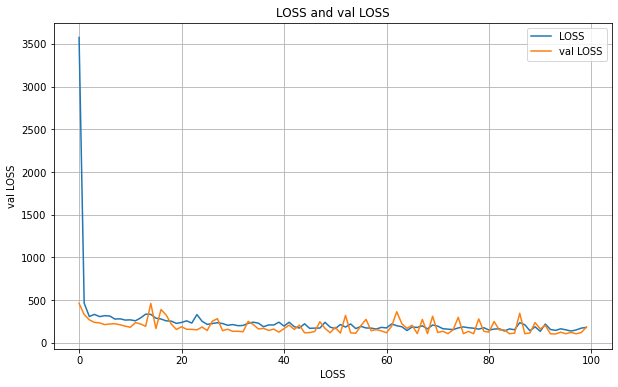

7/7 [==============================] - 0s 9ms/step


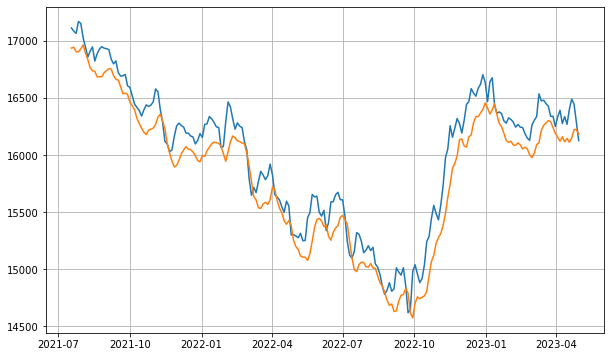

{'mae': 180.63881, 'mse': 44457.47, 'rmse': 210.8494, 'mape': 1.1285014, 'mase': 2.4856367}


<ipython-input-2-5c4b28aa2962>:6: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = pd.read_csv('./currency_data_10_years.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


Model: "1_model_USD"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2688      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,057
Trainable params: 13,057
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
     19/Unknown - 2s 3ms/step - loss: 2752.6213 - mae: 2751.6079 

INFO:tensorflow:Assets written to: saved_model/12\assets


INFO:tensorflow:Assets written to: saved_model/12\assets


31/31 [==============================] - 3s 54ms/step - loss: 1864.5924 - mae: 1863.6570 - val_loss: 249.6364 - val_mae: 248.9040
Epoch 2/100
23/31 [=====================>........] - ETA: 0s - loss: 311.6690 - mae: 311.0404

INFO:tensorflow:Assets written to: saved_model/12\assets


INFO:tensorflow:Assets written to: saved_model/12\assets


31/31 [==============================] - 1s 45ms/step - loss: 306.4668 - mae: 305.8687 - val_loss: 204.4315 - val_mae: 203.9568
Epoch 3/100
24/31 [======================>.......] - ETA: 0s - loss: 298.0094 - mae: 297.5989

INFO:tensorflow:Assets written to: saved_model/12\assets


INFO:tensorflow:Assets written to: saved_model/12\assets


31/31 [==============================] - 2s 46ms/step - loss: 307.1478 - mae: 306.7531 - val_loss: 173.6800 - val_mae: 173.3585
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 272.3073 - mae: 272.0321 - val_loss: 211.3807 - val_mae: 211.1488
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 268.4808 - mae: 268.2752 - val_loss: 185.9743 - val_mae: 185.7928
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 307.5858 - mae: 307.4202 - val_loss: 629.6205 - val_mae: 629.4695
Epoch 7/100
25/31 [=======================>......] - ETA: 0s - loss: 294.3679 - mae: 294.2233

INFO:tensorflow:Assets written to: saved_model/12\assets


INFO:tensorflow:Assets written to: saved_model/12\assets


31/31 [==============================] - 2s 48ms/step - loss: 294.0006 - mae: 293.8573 - val_loss: 160.9393 - val_mae: 160.8027
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 241.7959 - mae: 241.6657 - val_loss: 259.6747 - val_mae: 259.5469
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 281.0899 - mae: 280.9665 - val_loss: 265.1516 - val_mae: 265.0311
Epoch 10/100
31/31 [==============================] - 0s 5ms/step - loss: 241.9992 - mae: 241.8796 - val_loss: 174.2104 - val_mae: 174.0884
Epoch 11/100
22/31 [====================>.........] - ETA: 0s - loss: 246.5788 - mae: 246.4611

INFO:tensorflow:Assets written to: saved_model/12\assets


INFO:tensorflow:Assets written to: saved_model/12\assets


31/31 [==============================] - 2s 46ms/step - loss: 244.1294 - mae: 244.0120 - val_loss: 145.8708 - val_mae: 145.7542
Epoch 12/100
21/31 [===================>..........] - ETA: 0s - loss: 209.2703 - mae: 209.1535

INFO:tensorflow:Assets written to: saved_model/12\assets


INFO:tensorflow:Assets written to: saved_model/12\assets


31/31 [==============================] - 1s 43ms/step - loss: 223.8937 - mae: 223.7771 - val_loss: 140.5360 - val_mae: 140.4201
Epoch 13/100
31/31 [==============================] - 0s 5ms/step - loss: 214.5257 - mae: 214.4089 - val_loss: 142.0950 - val_mae: 141.9782
Epoch 14/100
31/31 [==============================] - 0s 5ms/step - loss: 241.2859 - mae: 241.1705 - val_loss: 211.9839 - val_mae: 211.8688
Epoch 15/100
31/31 [==============================] - 0s 5ms/step - loss: 210.0513 - mae: 209.9360 - val_loss: 308.6048 - val_mae: 308.4900
Epoch 16/100
31/31 [==============================] - 0s 5ms/step - loss: 225.5124 - mae: 225.3972 - val_loss: 144.2837 - val_mae: 144.1653
Epoch 17/100
31/31 [==============================] - 0s 5ms/step - loss: 202.9431 - mae: 202.8284 - val_loss: 164.3624 - val_mae: 164.2478
Epoch 18/100
31/31 [==============================] - 0s 4ms/step - loss: 186.7925 - mae: 186.6772 - val_loss: 219.3482 - val_mae: 219.2338
Epoch 19/100
31/31 [============

INFO:tensorflow:Assets written to: saved_model/12\assets


INFO:tensorflow:Assets written to: saved_model/12\assets


31/31 [==============================] - 1s 40ms/step - loss: 187.9029 - mae: 187.7867 - val_loss: 105.5497 - val_mae: 105.4349
Epoch 21/100
31/31 [==============================] - 0s 5ms/step - loss: 171.2807 - mae: 171.1653 - val_loss: 256.2798 - val_mae: 256.1649
Epoch 22/100
31/31 [==============================] - 0s 5ms/step - loss: 161.0258 - mae: 160.9102 - val_loss: 109.9839 - val_mae: 109.8661
Epoch 23/100
31/31 [==============================] - 0s 6ms/step - loss: 160.6603 - mae: 160.5448 - val_loss: 147.5361 - val_mae: 147.4208
Epoch 24/100
31/31 [==============================] - 0s 5ms/step - loss: 168.0110 - mae: 167.8956 - val_loss: 118.1668 - val_mae: 118.0518
Epoch 25/100
31/31 [==============================] - 0s 5ms/step - loss: 162.8734 - mae: 162.7578 - val_loss: 261.4110 - val_mae: 261.2961
Epoch 26/100
31/31 [==============================] - 0s 5ms/step - loss: 187.5406 - mae: 187.4249 - val_loss: 177.6831 - val_mae: 177.5676
Epoch 27/100
21/31 [============

INFO:tensorflow:Assets written to: saved_model/12\assets


INFO:tensorflow:Assets written to: saved_model/12\assets


31/31 [==============================] - 1s 41ms/step - loss: 170.9429 - mae: 170.8273 - val_loss: 87.8515 - val_mae: 87.7335
Epoch 28/100
31/31 [==============================] - 0s 4ms/step - loss: 148.7835 - mae: 148.6687 - val_loss: 244.4957 - val_mae: 244.3814
Epoch 29/100
31/31 [==============================] - 0s 4ms/step - loss: 244.0015 - mae: 243.8865 - val_loss: 129.7310 - val_mae: 129.6160
Epoch 30/100
31/31 [==============================] - 0s 4ms/step - loss: 151.7935 - mae: 151.6782 - val_loss: 108.2305 - val_mae: 108.1155
Epoch 31/100
31/31 [==============================] - 0s 4ms/step - loss: 153.6305 - mae: 153.5154 - val_loss: 175.2750 - val_mae: 175.1604
Epoch 32/100
31/31 [==============================] - 0s 4ms/step - loss: 147.2505 - mae: 147.1356 - val_loss: 183.6423 - val_mae: 183.5275
Epoch 33/100
31/31 [==============================] - 0s 4ms/step - loss: 168.0300 - mae: 167.9146 - val_loss: 205.4293 - val_mae: 205.3147
Epoch 34/100
31/31 [==============

INFO:tensorflow:Assets written to: saved_model/12\assets


INFO:tensorflow:Assets written to: saved_model/12\assets


31/31 [==============================] - 1s 38ms/step - loss: 204.0739 - mae: 203.9557 - val_loss: 82.9839 - val_mae: 82.8661
Epoch 38/100
31/31 [==============================] - 0s 4ms/step - loss: 153.1738 - mae: 153.0556 - val_loss: 187.8241 - val_mae: 187.7056
Epoch 39/100
31/31 [==============================] - 0s 6ms/step - loss: 171.3814 - mae: 171.2620 - val_loss: 160.5565 - val_mae: 160.4366
Epoch 40/100
31/31 [==============================] - 0s 6ms/step - loss: 158.5862 - mae: 158.4666 - val_loss: 196.8642 - val_mae: 196.7450
Epoch 41/100
31/31 [==============================] - 0s 5ms/step - loss: 166.6534 - mae: 166.5338 - val_loss: 124.7976 - val_mae: 124.6782
Epoch 42/100
31/31 [==============================] - 0s 6ms/step - loss: 138.7942 - mae: 138.6744 - val_loss: 189.4399 - val_mae: 189.3210
Epoch 43/100
31/31 [==============================] - 0s 5ms/step - loss: 148.4630 - mae: 148.3431 - val_loss: 125.2093 - val_mae: 125.0885
Epoch 44/100
31/31 [==============

INFO:tensorflow:Assets written to: saved_model/12\assets


INFO:tensorflow:Assets written to: saved_model/12\assets


31/31 [==============================] - 1s 45ms/step - loss: 127.8253 - mae: 127.7037 - val_loss: 76.7193 - val_mae: 76.5961
Epoch 50/100
31/31 [==============================] - 0s 4ms/step - loss: 189.2692 - mae: 189.1474 - val_loss: 78.5050 - val_mae: 78.3839
Epoch 51/100
31/31 [==============================] - 0s 4ms/step - loss: 165.0191 - mae: 164.8978 - val_loss: 144.4934 - val_mae: 144.3725
Epoch 52/100
31/31 [==============================] - 0s 5ms/step - loss: 113.1794 - mae: 113.0570 - val_loss: 186.4705 - val_mae: 186.3472
Epoch 53/100
25/31 [=======================>......] - ETA: 0s - loss: 152.4102 - mae: 152.2890

INFO:tensorflow:Assets written to: saved_model/12\assets


INFO:tensorflow:Assets written to: saved_model/12\assets


31/31 [==============================] - 2s 51ms/step - loss: 147.1226 - mae: 147.0014 - val_loss: 75.5401 - val_mae: 75.4187
Epoch 54/100
31/31 [==============================] - 0s 4ms/step - loss: 109.4675 - mae: 109.3460 - val_loss: 113.6459 - val_mae: 113.5249
Epoch 55/100
31/31 [==============================] - 0s 4ms/step - loss: 148.3729 - mae: 148.2518 - val_loss: 218.4166 - val_mae: 218.2959
Epoch 56/100
31/31 [==============================] - 0s 4ms/step - loss: 136.9375 - mae: 136.8164 - val_loss: 149.3264 - val_mae: 149.2059
Epoch 57/100
31/31 [==============================] - 0s 4ms/step - loss: 130.4880 - mae: 130.3673 - val_loss: 97.2113 - val_mae: 97.0912
Epoch 58/100
25/31 [=======================>......] - ETA: 0s - loss: 148.1422 - mae: 148.0211

INFO:tensorflow:Assets written to: saved_model/12\assets


INFO:tensorflow:Assets written to: saved_model/12\assets


31/31 [==============================] - 1s 39ms/step - loss: 146.9357 - mae: 146.8148 - val_loss: 73.0843 - val_mae: 72.9587
Epoch 59/100
31/31 [==============================] - 0s 4ms/step - loss: 140.5264 - mae: 140.4057 - val_loss: 93.0408 - val_mae: 92.9209
Epoch 60/100
31/31 [==============================] - 0s 5ms/step - loss: 149.9150 - mae: 149.7953 - val_loss: 73.8398 - val_mae: 73.7192
Epoch 61/100
31/31 [==============================] - 0s 5ms/step - loss: 144.4179 - mae: 144.2975 - val_loss: 75.5031 - val_mae: 75.3827
Epoch 62/100
31/31 [==============================] - 0s 5ms/step - loss: 125.1243 - mae: 125.0020 - val_loss: 128.3640 - val_mae: 128.2448
Epoch 63/100
31/31 [==============================] - 0s 5ms/step - loss: 102.4265 - mae: 102.3055 - val_loss: 146.7729 - val_mae: 146.6535
Epoch 64/100
31/31 [==============================] - 0s 6ms/step - loss: 121.5444 - mae: 121.4244 - val_loss: 101.6316 - val_mae: 101.5114
Epoch 65/100
31/31 [====================

INFO:tensorflow:Assets written to: saved_model/12\assets


INFO:tensorflow:Assets written to: saved_model/12\assets


31/31 [==============================] - 1s 41ms/step - loss: 131.8666 - mae: 131.7554 - val_loss: 68.6261 - val_mae: 68.5131
Epoch 91/100
31/31 [==============================] - 0s 5ms/step - loss: 122.7150 - mae: 122.6039 - val_loss: 96.0707 - val_mae: 95.9555
Epoch 92/100
31/31 [==============================] - 0s 4ms/step - loss: 154.0866 - mae: 153.9758 - val_loss: 174.5172 - val_mae: 174.4070
Epoch 93/100
31/31 [==============================] - 0s 4ms/step - loss: 146.8412 - mae: 146.7309 - val_loss: 79.0383 - val_mae: 78.9265
Epoch 94/100
31/31 [==============================] - 0s 4ms/step - loss: 155.0870 - mae: 154.9759 - val_loss: 384.3704 - val_mae: 384.2612
Epoch 95/100
31/31 [==============================] - 0s 4ms/step - loss: 136.8415 - mae: 136.7313 - val_loss: 182.7885 - val_mae: 182.6796
Epoch 96/100
31/31 [==============================] - 0s 4ms/step - loss: 132.0099 - mae: 131.9002 - val_loss: 81.5593 - val_mae: 81.4495
Epoch 97/100
31/31 [====================

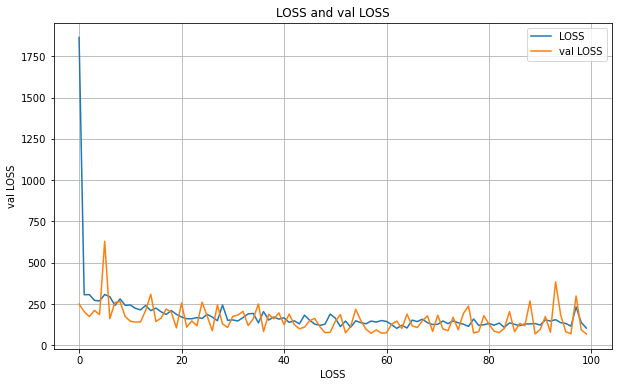

7/7 [==============================] - 0s 16ms/step


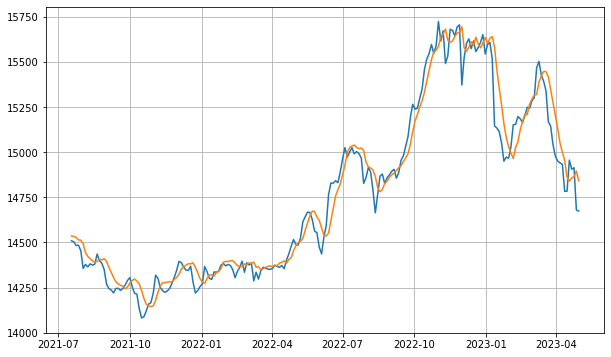

{'mae': 67.472534, 'mse': 9037.369, 'rmse': 95.06508, 'mape': 0.45450246, 'mase': 1.4730858}


<ipython-input-2-5c4b28aa2962>:6: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = pd.read_csv('./currency_data_10_years.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


Model: "1_model_JPY"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2688      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,057
Trainable params: 13,057
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
     23/Unknown - 1s 2ms/step - loss: 14.5269 - mae: 13.5553

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


31/31 [==============================] - 3s 52ms/step - loss: 12.0975 - mae: 11.1764 - val_loss: 3.2701 - val_mae: 2.5261
Epoch 2/100
23/31 [=====================>........] - ETA: 0s - loss: 3.5215 - mae: 2.9088

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


31/31 [==============================] - 1s 42ms/step - loss: 3.3772 - mae: 2.7921 - val_loss: 2.8269 - val_mae: 2.3585
Epoch 3/100
24/31 [======================>.......] - ETA: 0s - loss: 2.8883 - mae: 2.5053

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


31/31 [==============================] - 2s 52ms/step - loss: 2.8338 - mae: 2.4673 - val_loss: 2.6946 - val_mae: 2.4136
Epoch 4/100
21/31 [===================>..........] - ETA: 0s - loss: 2.7375 - mae: 2.4846

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


31/31 [==============================] - 2s 48ms/step - loss: 2.6600 - mae: 2.4241 - val_loss: 2.4255 - val_mae: 2.2384
Epoch 5/100
25/31 [=======================>......] - ETA: 0s - loss: 2.2485 - mae: 2.0775

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


31/31 [==============================] - 1s 41ms/step - loss: 2.2577 - mae: 2.0902 - val_loss: 2.1428 - val_mae: 1.9850
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 2.3740 - mae: 2.2590 - val_loss: 2.2626 - val_mae: 2.1722
Epoch 7/100
21/31 [===================>..........] - ETA: 0s - loss: 2.3036 - mae: 2.2140

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


31/31 [==============================] - 2s 55ms/step - loss: 2.1626 - mae: 2.0724 - val_loss: 1.8885 - val_mae: 1.7828
Epoch 8/100
31/31 [==============================] - 0s 6ms/step - loss: 2.0963 - mae: 2.0205 - val_loss: 2.0227 - val_mae: 1.9556
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 2.5220 - mae: 2.4666 - val_loss: 1.9324 - val_mae: 1.8759
Epoch 10/100
24/31 [======================>.......] - ETA: 0s - loss: 1.8334 - mae: 1.7605

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


31/31 [==============================] - 1s 41ms/step - loss: 1.8304 - mae: 1.7607 - val_loss: 1.8246 - val_mae: 1.7648
Epoch 11/100
17/31 [===============>..............] - ETA: 0s - loss: 1.8108 - mae: 1.7460

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


31/31 [==============================] - 2s 44ms/step - loss: 1.8710 - mae: 1.8112 - val_loss: 1.7047 - val_mae: 1.6328
Epoch 12/100
21/31 [===================>..........] - ETA: 0s - loss: 1.9113 - mae: 1.8554

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


31/31 [==============================] - 2s 57ms/step - loss: 1.8873 - mae: 1.8304 - val_loss: 1.6097 - val_mae: 1.5403
Epoch 13/100
31/31 [==============================] - 0s 5ms/step - loss: 1.6079 - mae: 1.5409 - val_loss: 1.9203 - val_mae: 1.8829
Epoch 14/100
31/31 [==============================] - 0s 5ms/step - loss: 1.6383 - mae: 1.5751 - val_loss: 1.7934 - val_mae: 1.7308
Epoch 15/100
20/31 [==================>...........] - ETA: 0s - loss: 1.8540 - mae: 1.8089

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


31/31 [==============================] - 1s 44ms/step - loss: 1.7206 - mae: 1.6686 - val_loss: 1.5836 - val_mae: 1.5203
Epoch 16/100
31/31 [==============================] - 0s 5ms/step - loss: 1.8852 - mae: 1.8457 - val_loss: 1.9305 - val_mae: 1.8998
Epoch 17/100
31/31 [==============================] - 0s 6ms/step - loss: 1.5452 - mae: 1.4847 - val_loss: 1.7429 - val_mae: 1.6907
Epoch 18/100
31/31 [==============================] - 0s 4ms/step - loss: 1.6294 - mae: 1.5828 - val_loss: 1.7876 - val_mae: 1.7439
Epoch 19/100
31/31 [==============================] - 0s 4ms/step - loss: 1.9976 - mae: 1.9655 - val_loss: 1.7685 - val_mae: 1.7251
Epoch 20/100
25/31 [=======================>......] - ETA: 0s - loss: 1.7291 - mae: 1.6894

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


31/31 [==============================] - 1s 40ms/step - loss: 1.6860 - mae: 1.6450 - val_loss: 1.4641 - val_mae: 1.4133
Epoch 21/100
17/31 [===============>..............] - ETA: 0s - loss: 1.7536 - mae: 1.7175

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


31/31 [==============================] - 1s 45ms/step - loss: 1.6657 - mae: 1.6254 - val_loss: 1.3795 - val_mae: 1.3418
Epoch 22/100
31/31 [==============================] - 0s 5ms/step - loss: 1.8155 - mae: 1.7906 - val_loss: 1.5305 - val_mae: 1.4935
Epoch 23/100
31/31 [==============================] - 0s 4ms/step - loss: 1.4687 - mae: 1.4178 - val_loss: 1.5300 - val_mae: 1.4941
Epoch 24/100
24/31 [======================>.......] - ETA: 0s - loss: 1.7581 - mae: 1.7336

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


31/31 [==============================] - 1s 45ms/step - loss: 1.7439 - mae: 1.7196 - val_loss: 1.3691 - val_mae: 1.3380
Epoch 25/100
31/31 [==============================] - 0s 4ms/step - loss: 1.4820 - mae: 1.4444 - val_loss: 1.4959 - val_mae: 1.4598
Epoch 26/100
31/31 [==============================] - 0s 5ms/step - loss: 1.4620 - mae: 1.4198 - val_loss: 1.4402 - val_mae: 1.4044
Epoch 27/100
25/31 [=======================>......] - ETA: 0s - loss: 1.4305 - mae: 1.3967

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


31/31 [==============================] - 1s 38ms/step - loss: 1.4387 - mae: 1.4019 - val_loss: 1.2929 - val_mae: 1.2540
Epoch 28/100
31/31 [==============================] - 0s 5ms/step - loss: 1.6877 - mae: 1.6699 - val_loss: 1.3064 - val_mae: 1.2697
Epoch 29/100
31/31 [==============================] - 0s 5ms/step - loss: 1.5164 - mae: 1.4960 - val_loss: 1.3751 - val_mae: 1.3532
Epoch 30/100
31/31 [==============================] - 0s 5ms/step - loss: 1.7408 - mae: 1.7298 - val_loss: 1.4384 - val_mae: 1.4110
Epoch 31/100
31/31 [==============================] - 0s 5ms/step - loss: 1.5918 - mae: 1.5735 - val_loss: 1.3926 - val_mae: 1.3756
Epoch 32/100
31/31 [==============================] - 0s 5ms/step - loss: 1.4705 - mae: 1.4549 - val_loss: 1.8015 - val_mae: 1.7993
Epoch 33/100
31/31 [==============================] - 0s 5ms/step - loss: 1.4278 - mae: 1.4062 - val_loss: 1.3247 - val_mae: 1.3099
Epoch 34/100
31/31 [==============================] - 0s 4ms/step - loss: 1.4629 - mae: 

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


31/31 [==============================] - 2s 49ms/step - loss: 1.3017 - mae: 1.2784 - val_loss: 1.2130 - val_mae: 1.1855
Epoch 36/100
31/31 [==============================] - 0s 5ms/step - loss: 1.3488 - mae: 1.3283 - val_loss: 1.5588 - val_mae: 1.5544
Epoch 37/100
31/31 [==============================] - 0s 5ms/step - loss: 1.4932 - mae: 1.4860 - val_loss: 1.5341 - val_mae: 1.5290
Epoch 38/100
31/31 [==============================] - 0s 5ms/step - loss: 1.6372 - mae: 1.6278 - val_loss: 1.4078 - val_mae: 1.3959
Epoch 39/100
31/31 [==============================] - 0s 4ms/step - loss: 1.5068 - mae: 1.5122 - val_loss: 1.7341 - val_mae: 1.7446
Epoch 40/100
24/31 [======================>.......] - ETA: 0s - loss: 1.3124 - mae: 1.2864

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


31/31 [==============================] - 1s 41ms/step - loss: 1.3620 - mae: 1.3396 - val_loss: 1.1908 - val_mae: 1.1732
Epoch 41/100
24/31 [======================>.......] - ETA: 0s - loss: 1.8005 - mae: 1.8161

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


31/31 [==============================] - 1s 39ms/step - loss: 1.6793 - mae: 1.6872 - val_loss: 1.1856 - val_mae: 1.1691
Epoch 42/100
31/31 [==============================] - 0s 4ms/step - loss: 1.5040 - mae: 1.5047 - val_loss: 1.4093 - val_mae: 1.4053
Epoch 43/100
31/31 [==============================] - 0s 4ms/step - loss: 1.5521 - mae: 1.5577 - val_loss: 1.2816 - val_mae: 1.2815
Epoch 44/100
24/31 [======================>.......] - ETA: 0s - loss: 1.5800 - mae: 1.5891

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


31/31 [==============================] - 1s 43ms/step - loss: 1.5406 - mae: 1.5453 - val_loss: 1.1759 - val_mae: 1.1627
Epoch 45/100
25/31 [=======================>......] - ETA: 0s - loss: 1.3038 - mae: 1.2985

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


31/31 [==============================] - 1s 39ms/step - loss: 1.2862 - mae: 1.2784 - val_loss: 1.1596 - val_mae: 1.1465
Epoch 46/100
31/31 [==============================] - 0s 4ms/step - loss: 1.4820 - mae: 1.4851 - val_loss: 1.3220 - val_mae: 1.3222
Epoch 47/100
31/31 [==============================] - 0s 4ms/step - loss: 1.5868 - mae: 1.6008 - val_loss: 2.3150 - val_mae: 2.3628
Epoch 48/100
31/31 [==============================] - 0s 5ms/step - loss: 1.4990 - mae: 1.5060 - val_loss: 1.2003 - val_mae: 1.1870
Epoch 49/100
20/31 [==================>...........] - ETA: 0s - loss: 1.2623 - mae: 1.2496

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


31/31 [==============================] - 1s 44ms/step - loss: 1.2632 - mae: 1.2510 - val_loss: 1.1534 - val_mae: 1.1417
Epoch 50/100
31/31 [==============================] - 0s 5ms/step - loss: 1.6170 - mae: 1.6279 - val_loss: 1.6951 - val_mae: 1.7186
Epoch 51/100
31/31 [==============================] - 0s 5ms/step - loss: 1.4441 - mae: 1.4537 - val_loss: 2.4350 - val_mae: 2.4964
Epoch 52/100
31/31 [==============================] - 0s 5ms/step - loss: 1.4337 - mae: 1.4372 - val_loss: 2.4891 - val_mae: 2.5550
Epoch 53/100
31/31 [==============================] - 0s 5ms/step - loss: 1.7850 - mae: 1.8156 - val_loss: 1.2144 - val_mae: 1.2245
Epoch 54/100
16/31 [==============>...............] - ETA: 0s - loss: 1.3636 - mae: 1.3741

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


31/31 [==============================] - 2s 50ms/step - loss: 1.4334 - mae: 1.4460 - val_loss: 1.1339 - val_mae: 1.1343
Epoch 55/100
31/31 [==============================] - 0s 4ms/step - loss: 1.3442 - mae: 1.3598 - val_loss: 1.5396 - val_mae: 1.5659
Epoch 56/100
31/31 [==============================] - 0s 5ms/step - loss: 1.2803 - mae: 1.2841 - val_loss: 1.2435 - val_mae: 1.2494
Epoch 57/100
31/31 [==============================] - 0s 4ms/step - loss: 1.2856 - mae: 1.2919 - val_loss: 1.3426 - val_mae: 1.3575
Epoch 58/100
24/31 [======================>.......] - ETA: 0s - loss: 1.1296 - mae: 1.1255

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


31/31 [==============================] - 1s 44ms/step - loss: 1.1519 - mae: 1.1493 - val_loss: 1.0774 - val_mae: 1.0780
Epoch 59/100
31/31 [==============================] - 0s 5ms/step - loss: 1.2307 - mae: 1.2399 - val_loss: 1.1799 - val_mae: 1.1857
Epoch 60/100
31/31 [==============================] - 0s 5ms/step - loss: 1.2825 - mae: 1.2955 - val_loss: 1.3366 - val_mae: 1.3562
Epoch 61/100
31/31 [==============================] - 0s 6ms/step - loss: 1.8135 - mae: 1.8517 - val_loss: 2.6657 - val_mae: 2.7511
Epoch 62/100
31/31 [==============================] - 0s 5ms/step - loss: 1.6863 - mae: 1.7288 - val_loss: 1.4863 - val_mae: 1.5194
Epoch 63/100
31/31 [==============================] - 0s 5ms/step - loss: 1.4951 - mae: 1.5325 - val_loss: 1.1464 - val_mae: 1.1670
Epoch 64/100
31/31 [==============================] - 0s 5ms/step - loss: 1.4248 - mae: 1.4566 - val_loss: 1.2235 - val_mae: 1.2482
Epoch 65/100
31/31 [==============================] - 0s 5ms/step - loss: 1.3822 - mae: 

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


31/31 [==============================] - 2s 55ms/step - loss: 1.1535 - mae: 1.1663 - val_loss: 1.0632 - val_mae: 1.0715
Epoch 67/100
31/31 [==============================] - 0s 5ms/step - loss: 1.4184 - mae: 1.4544 - val_loss: 1.0742 - val_mae: 1.0918
Epoch 68/100
31/31 [==============================] - 0s 5ms/step - loss: 1.3329 - mae: 1.3555 - val_loss: 1.1791 - val_mae: 1.2069
Epoch 69/100
31/31 [==============================] - 0s 4ms/step - loss: 1.2225 - mae: 1.2467 - val_loss: 1.0829 - val_mae: 1.1057
Epoch 70/100
31/31 [==============================] - 0s 5ms/step - loss: 1.2081 - mae: 1.2289 - val_loss: 1.2886 - val_mae: 1.3275
Epoch 71/100
21/31 [===================>..........] - ETA: 0s - loss: 1.3139 - mae: 1.3451

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


31/31 [==============================] - 2s 49ms/step - loss: 1.2661 - mae: 1.2913 - val_loss: 1.0174 - val_mae: 1.0360
Epoch 72/100
31/31 [==============================] - 0s 4ms/step - loss: 1.2876 - mae: 1.3250 - val_loss: 1.2101 - val_mae: 1.2365
Epoch 73/100
31/31 [==============================] - 0s 5ms/step - loss: 1.1798 - mae: 1.2050 - val_loss: 1.0919 - val_mae: 1.1201
Epoch 74/100
31/31 [==============================] - 0s 5ms/step - loss: 1.5083 - mae: 1.5694 - val_loss: 1.0686 - val_mae: 1.0961
Epoch 75/100
31/31 [==============================] - 0s 5ms/step - loss: 1.3768 - mae: 1.4228 - val_loss: 1.4247 - val_mae: 1.4783
Epoch 76/100
20/31 [==================>...........] - ETA: 0s - loss: 1.2771 - mae: 1.3123

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


31/31 [==============================] - 2s 54ms/step - loss: 1.3709 - mae: 1.4151 - val_loss: 1.0070 - val_mae: 1.0315
Epoch 77/100
31/31 [==============================] - 1s 5ms/step - loss: 1.2938 - mae: 1.3372 - val_loss: 2.0999 - val_mae: 2.1943
Epoch 78/100
31/31 [==============================] - 0s 5ms/step - loss: 1.6411 - mae: 1.6979 - val_loss: 1.5611 - val_mae: 1.6275
Epoch 79/100
31/31 [==============================] - 0s 5ms/step - loss: 1.3323 - mae: 1.3852 - val_loss: 1.1975 - val_mae: 1.2373
Epoch 80/100
31/31 [==============================] - 0s 5ms/step - loss: 1.3968 - mae: 1.4519 - val_loss: 1.4502 - val_mae: 1.5142
Epoch 81/100
31/31 [==============================] - 0s 7ms/step - loss: 1.2339 - mae: 1.2820 - val_loss: 1.0156 - val_mae: 1.0500
Epoch 82/100
18/31 [================>.............] - ETA: 0s - loss: 1.3200 - mae: 1.3727

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


31/31 [==============================] - 2s 54ms/step - loss: 1.4271 - mae: 1.4891 - val_loss: 0.9905 - val_mae: 1.0211
Epoch 83/100
31/31 [==============================] - 0s 5ms/step - loss: 1.4376 - mae: 1.4980 - val_loss: 1.1380 - val_mae: 1.1861
Epoch 84/100
31/31 [==============================] - 0s 5ms/step - loss: 1.1007 - mae: 1.1358 - val_loss: 1.1783 - val_mae: 1.2200
Epoch 85/100
31/31 [==============================] - 0s 5ms/step - loss: 1.2848 - mae: 1.3435 - val_loss: 1.0125 - val_mae: 1.0458
Epoch 86/100
31/31 [==============================] - 0s 4ms/step - loss: 1.5473 - mae: 1.6221 - val_loss: 1.3532 - val_mae: 1.4193
Epoch 87/100
24/31 [======================>.......] - ETA: 0s - loss: 1.1959 - mae: 1.2450

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


31/31 [==============================] - 2s 46ms/step - loss: 1.1411 - mae: 1.1836 - val_loss: 0.9764 - val_mae: 1.0169
Epoch 88/100
31/31 [==============================] - 0s 6ms/step - loss: 1.1670 - mae: 1.2169 - val_loss: 1.2261 - val_mae: 1.2826
Epoch 89/100
31/31 [==============================] - 0s 5ms/step - loss: 1.2260 - mae: 1.2780 - val_loss: 1.4399 - val_mae: 1.5211
Epoch 90/100
31/31 [==============================] - 0s 4ms/step - loss: 1.4131 - mae: 1.4868 - val_loss: 0.9870 - val_mae: 1.0265
Epoch 91/100
31/31 [==============================] - 0s 6ms/step - loss: 1.1228 - mae: 1.1680 - val_loss: 1.0165 - val_mae: 1.0646
Epoch 92/100
21/31 [===================>..........] - ETA: 0s - loss: 1.0530 - mae: 1.0916

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


31/31 [==============================] - 2s 62ms/step - loss: 1.0701 - mae: 1.1116 - val_loss: 0.9528 - val_mae: 0.9937
Epoch 93/100
31/31 [==============================] - 0s 4ms/step - loss: 1.0790 - mae: 1.1189 - val_loss: 1.0275 - val_mae: 1.0730
Epoch 94/100
20/31 [==================>...........] - ETA: 0s - loss: 0.9860 - mae: 1.0245

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


31/31 [==============================] - 2s 51ms/step - loss: 1.0197 - mae: 1.0595 - val_loss: 0.9293 - val_mae: 0.9703
Epoch 95/100
31/31 [==============================] - 0s 5ms/step - loss: 1.1394 - mae: 1.1934 - val_loss: 0.9434 - val_mae: 0.9845
Epoch 96/100
31/31 [==============================] - 0s 5ms/step - loss: 1.0970 - mae: 1.1479 - val_loss: 0.9989 - val_mae: 1.0481
Epoch 97/100
19/31 [=================>............] - ETA: 0s - loss: 1.2909 - mae: 1.3620

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


31/31 [==============================] - 2s 47ms/step - loss: 1.1697 - mae: 1.2279 - val_loss: 0.9290 - val_mae: 0.9746
Epoch 98/100
31/31 [==============================] - 0s 4ms/step - loss: 1.4793 - mae: 1.5630 - val_loss: 2.1405 - val_mae: 2.2719
Epoch 99/100
31/31 [==============================] - 0s 5ms/step - loss: 1.5017 - mae: 1.5929 - val_loss: 1.1326 - val_mae: 1.2073
Epoch 100/100
22/31 [====================>.........] - ETA: 0s - loss: 1.0894 - mae: 1.1417

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


7/7 [==============================] - 0s 9ms/step - loss: 0.9197 - mae: 0.9663


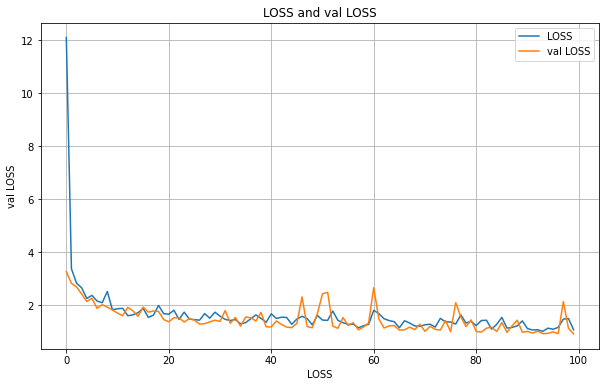

7/7 [==============================] - 0s 11ms/step


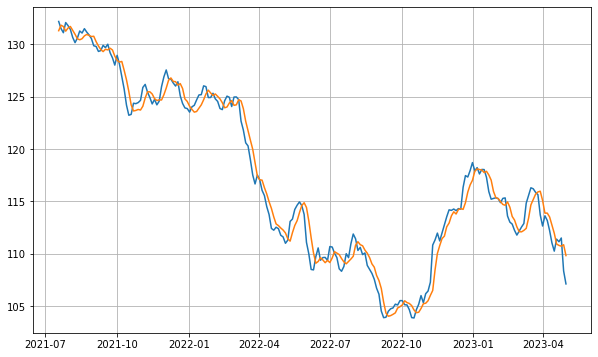

{'mae': 0.92260796, 'mse': 1.3885524, 'rmse': 1.1783686, 'mape': 0.7981184, 'mase': 1.4526467}


<ipython-input-2-5c4b28aa2962>:6: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = pd.read_csv('./currency_data_10_years.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


Model: "1_model_GBP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2688      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,057
Trainable params: 13,057
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
     20/Unknown - 2s 3ms/step - loss: 2665.3506 - mae: 2664.3828 

INFO:tensorflow:Assets written to: saved_model/14\assets


INFO:tensorflow:Assets written to: saved_model/14\assets


31/31 [==============================] - 3s 58ms/step - loss: 1961.6022 - mae: 1960.7026 - val_loss: 301.6818 - val_mae: 300.9797
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 429.3542 - mae: 428.7831 - val_loss: 491.5264 - val_mae: 491.0746
Epoch 3/100
21/31 [===================>..........] - ETA: 0s - loss: 435.2775 - mae: 434.8795

INFO:tensorflow:Assets written to: saved_model/14\assets


INFO:tensorflow:Assets written to: saved_model/14\assets


31/31 [==============================] - 2s 59ms/step - loss: 407.6172 - mae: 407.2412 - val_loss: 247.0755 - val_mae: 246.7691
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 320.3020 - mae: 320.0390 - val_loss: 350.0020 - val_mae: 349.7790
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 325.2487 - mae: 325.0502 - val_loss: 285.4803 - val_mae: 285.3050
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 316.6896 - mae: 316.5280 - val_loss: 247.3852 - val_mae: 247.2362
Epoch 7/100
22/31 [====================>.........] - ETA: 0s - loss: 298.5847 - mae: 298.4412

INFO:tensorflow:Assets written to: saved_model/14\assets


INFO:tensorflow:Assets written to: saved_model/14\assets


31/31 [==============================] - 2s 51ms/step - loss: 293.5376 - mae: 293.3961 - val_loss: 196.7190 - val_mae: 196.5846
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 289.0273 - mae: 288.8970 - val_loss: 271.4699 - val_mae: 271.3436
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 264.3726 - mae: 264.2475 - val_loss: 238.4037 - val_mae: 238.2809
Epoch 10/100
19/31 [=================>............] - ETA: 0s - loss: 298.4481 - mae: 298.3261

INFO:tensorflow:Assets written to: saved_model/14\assets


INFO:tensorflow:Assets written to: saved_model/14\assets


31/31 [==============================] - 1s 41ms/step - loss: 283.0713 - mae: 282.9498 - val_loss: 182.4620 - val_mae: 182.3391
Epoch 11/100
31/31 [==============================] - 0s 5ms/step - loss: 317.4648 - mae: 317.3450 - val_loss: 518.5702 - val_mae: 518.4518
Epoch 12/100
31/31 [==============================] - 0s 5ms/step - loss: 256.3106 - mae: 256.1928 - val_loss: 252.2655 - val_mae: 252.1482
Epoch 13/100
31/31 [==============================] - 0s 5ms/step - loss: 273.5877 - mae: 273.4705 - val_loss: 184.4400 - val_mae: 184.3219
Epoch 14/100
31/31 [==============================] - 0s 6ms/step - loss: 389.3759 - mae: 389.2595 - val_loss: 250.9184 - val_mae: 250.8024
Epoch 15/100
31/31 [==============================] - 0s 6ms/step - loss: 262.0955 - mae: 261.9797 - val_loss: 202.1573 - val_mae: 202.0417
Epoch 16/100
21/31 [===================>..........] - ETA: 0s - loss: 301.1807 - mae: 301.0651

INFO:tensorflow:Assets written to: saved_model/14\assets


INFO:tensorflow:Assets written to: saved_model/14\assets


31/31 [==============================] - 1s 42ms/step - loss: 280.1087 - mae: 279.9931 - val_loss: 163.9976 - val_mae: 163.8824
Epoch 17/100
19/31 [=================>............] - ETA: 0s - loss: 219.7852 - mae: 219.6700

INFO:tensorflow:Assets written to: saved_model/14\assets


INFO:tensorflow:Assets written to: saved_model/14\assets


31/31 [==============================] - 1s 42ms/step - loss: 261.6927 - mae: 261.5775 - val_loss: 160.2237 - val_mae: 160.1086
Epoch 18/100
31/31 [==============================] - 0s 5ms/step - loss: 249.4197 - mae: 249.3043 - val_loss: 169.0153 - val_mae: 168.9005
Epoch 19/100
22/31 [====================>.........] - ETA: 0s - loss: 240.7242 - mae: 240.6083

INFO:tensorflow:Assets written to: saved_model/14\assets


INFO:tensorflow:Assets written to: saved_model/14\assets


31/31 [==============================] - 1s 39ms/step - loss: 238.3151 - mae: 238.1996 - val_loss: 158.1349 - val_mae: 158.0195
Epoch 20/100
31/31 [==============================] - 0s 5ms/step - loss: 213.5181 - mae: 213.4032 - val_loss: 286.6986 - val_mae: 286.5842
Epoch 21/100
31/31 [==============================] - 1s 10ms/step - loss: 287.5632 - mae: 287.4482 - val_loss: 509.8419 - val_mae: 509.7274
Epoch 22/100
31/31 [==============================] - 0s 7ms/step - loss: 324.6240 - mae: 324.5097 - val_loss: 166.7863 - val_mae: 166.6698
Epoch 23/100
31/31 [==============================] - 0s 5ms/step - loss: 245.4385 - mae: 245.3241 - val_loss: 225.6685 - val_mae: 225.5520
Epoch 24/100
31/31 [==============================] - 0s 5ms/step - loss: 272.9065 - mae: 272.7920 - val_loss: 441.0738 - val_mae: 440.9601
Epoch 25/100
31/31 [==============================] - 0s 5ms/step - loss: 253.3036 - mae: 253.1895 - val_loss: 184.3530 - val_mae: 184.2395
Epoch 26/100
31/31 [===========

INFO:tensorflow:Assets written to: saved_model/14\assets


INFO:tensorflow:Assets written to: saved_model/14\assets


31/31 [==============================] - 2s 50ms/step - loss: 221.5326 - mae: 221.4189 - val_loss: 154.3559 - val_mae: 154.2405
Epoch 29/100
31/31 [==============================] - 0s 5ms/step - loss: 239.6897 - mae: 239.5758 - val_loss: 372.4047 - val_mae: 372.2915
Epoch 30/100
31/31 [==============================] - 0s 5ms/step - loss: 220.5967 - mae: 220.4824 - val_loss: 300.5504 - val_mae: 300.4355
Epoch 31/100
31/31 [==============================] - 0s 5ms/step - loss: 220.2794 - mae: 220.1654 - val_loss: 236.7077 - val_mae: 236.5942
Epoch 32/100
31/31 [==============================] - 0s 5ms/step - loss: 202.8900 - mae: 202.7775 - val_loss: 169.1410 - val_mae: 169.0271
Epoch 33/100
23/31 [=====================>........] - ETA: 0s - loss: 218.0868 - mae: 217.9740

INFO:tensorflow:Assets written to: saved_model/14\assets


INFO:tensorflow:Assets written to: saved_model/14\assets


31/31 [==============================] - 1s 38ms/step - loss: 219.4117 - mae: 219.2989 - val_loss: 143.6137 - val_mae: 143.4991
Epoch 34/100
31/31 [==============================] - 0s 4ms/step - loss: 218.4286 - mae: 218.3151 - val_loss: 170.4365 - val_mae: 170.3240
Epoch 35/100
31/31 [==============================] - 0s 5ms/step - loss: 243.7830 - mae: 243.6695 - val_loss: 179.0042 - val_mae: 178.8899
Epoch 36/100
31/31 [==============================] - 0s 5ms/step - loss: 213.1394 - mae: 213.0264 - val_loss: 254.8211 - val_mae: 254.7080
Epoch 37/100
31/31 [==============================] - 0s 5ms/step - loss: 211.5884 - mae: 211.4750 - val_loss: 155.2716 - val_mae: 155.1582
Epoch 38/100
31/31 [==============================] - 0s 5ms/step - loss: 228.6425 - mae: 228.5286 - val_loss: 157.9234 - val_mae: 157.8094
Epoch 39/100
31/31 [==============================] - 0s 5ms/step - loss: 197.0434 - mae: 196.9289 - val_loss: 161.2691 - val_mae: 161.1546
Epoch 40/100
23/31 [============

INFO:tensorflow:Assets written to: saved_model/14\assets


INFO:tensorflow:Assets written to: saved_model/14\assets


31/31 [==============================] - 1s 38ms/step - loss: 251.3423 - mae: 251.2278 - val_loss: 139.5320 - val_mae: 139.4155
Epoch 41/100
31/31 [==============================] - 0s 5ms/step - loss: 205.3654 - mae: 205.2518 - val_loss: 337.7646 - val_mae: 337.6512
Epoch 42/100
31/31 [==============================] - 0s 4ms/step - loss: 210.9230 - mae: 210.8089 - val_loss: 144.4053 - val_mae: 144.2885
Epoch 43/100
31/31 [==============================] - 0s 5ms/step - loss: 211.4663 - mae: 211.3524 - val_loss: 140.2191 - val_mae: 140.1045
Epoch 44/100
31/31 [==============================] - 0s 5ms/step - loss: 215.3977 - mae: 215.2835 - val_loss: 140.8237 - val_mae: 140.7104
Epoch 45/100
31/31 [==============================] - 0s 4ms/step - loss: 213.2768 - mae: 213.1634 - val_loss: 291.1223 - val_mae: 291.0092
Epoch 46/100
31/31 [==============================] - 0s 4ms/step - loss: 233.9448 - mae: 233.8311 - val_loss: 144.1047 - val_mae: 143.9911
Epoch 47/100
31/31 [============

INFO:tensorflow:Assets written to: saved_model/14\assets


INFO:tensorflow:Assets written to: saved_model/14\assets


31/31 [==============================] - 1s 38ms/step - loss: 212.6012 - mae: 212.4874 - val_loss: 137.3354 - val_mae: 137.2182
Epoch 51/100
31/31 [==============================] - 0s 5ms/step - loss: 335.7385 - mae: 335.6254 - val_loss: 142.4659 - val_mae: 142.3532
Epoch 52/100
31/31 [==============================] - 0s 5ms/step - loss: 260.3857 - mae: 260.2731 - val_loss: 140.7659 - val_mae: 140.6537
Epoch 53/100
31/31 [==============================] - 0s 5ms/step - loss: 228.1914 - mae: 228.0789 - val_loss: 159.8444 - val_mae: 159.7326
Epoch 54/100
31/31 [==============================] - 0s 5ms/step - loss: 186.4221 - mae: 186.3090 - val_loss: 141.1936 - val_mae: 141.0812
Epoch 55/100
23/31 [=====================>........] - ETA: 0s - loss: 190.4157 - mae: 190.3041

INFO:tensorflow:Assets written to: saved_model/14\assets


INFO:tensorflow:Assets written to: saved_model/14\assets


31/31 [==============================] - 1s 39ms/step - loss: 182.1116 - mae: 181.9991 - val_loss: 135.1886 - val_mae: 135.0773
Epoch 56/100
31/31 [==============================] - 0s 5ms/step - loss: 217.0847 - mae: 216.9726 - val_loss: 212.9707 - val_mae: 212.8597
Epoch 57/100
31/31 [==============================] - 0s 5ms/step - loss: 320.1462 - mae: 320.0350 - val_loss: 315.0014 - val_mae: 314.8909
Epoch 58/100
31/31 [==============================] - 0s 5ms/step - loss: 209.0855 - mae: 208.9747 - val_loss: 246.4124 - val_mae: 246.3019
Epoch 59/100
31/31 [==============================] - 0s 5ms/step - loss: 198.3350 - mae: 198.2242 - val_loss: 164.3402 - val_mae: 164.2301
Epoch 60/100
31/31 [==============================] - 0s 4ms/step - loss: 192.1655 - mae: 192.0555 - val_loss: 332.4466 - val_mae: 332.3366
Epoch 61/100
31/31 [==============================] - 0s 5ms/step - loss: 346.5701 - mae: 346.4605 - val_loss: 178.1768 - val_mae: 178.0656
Epoch 62/100
31/31 [============

INFO:tensorflow:Assets written to: saved_model/14\assets


INFO:tensorflow:Assets written to: saved_model/14\assets


31/31 [==============================] - 1s 38ms/step - loss: 204.9933 - mae: 204.8848 - val_loss: 133.0255 - val_mae: 132.9171
Epoch 65/100
31/31 [==============================] - 0s 5ms/step - loss: 185.7866 - mae: 185.6780 - val_loss: 163.6018 - val_mae: 163.4925
Epoch 66/100
23/31 [=====================>........] - ETA: 0s - loss: 210.9679 - mae: 210.8596

INFO:tensorflow:Assets written to: saved_model/14\assets


INFO:tensorflow:Assets written to: saved_model/14\assets


31/31 [==============================] - 1s 45ms/step - loss: 212.7615 - mae: 212.6531 - val_loss: 132.2228 - val_mae: 132.1122
Epoch 67/100
23/31 [=====================>........] - ETA: 0s - loss: 203.1878 - mae: 203.0794

INFO:tensorflow:Assets written to: saved_model/14\assets


INFO:tensorflow:Assets written to: saved_model/14\assets


31/31 [==============================] - 1s 38ms/step - loss: 209.1921 - mae: 209.0838 - val_loss: 131.5386 - val_mae: 131.4310
Epoch 68/100
31/31 [==============================] - 0s 5ms/step - loss: 260.5690 - mae: 260.4614 - val_loss: 131.9745 - val_mae: 131.8649
Epoch 69/100
31/31 [==============================] - 0s 4ms/step - loss: 216.6274 - mae: 216.5196 - val_loss: 199.8427 - val_mae: 199.7357
Epoch 70/100
31/31 [==============================] - 0s 5ms/step - loss: 169.3004 - mae: 169.1928 - val_loss: 203.4510 - val_mae: 203.3444
Epoch 71/100
31/31 [==============================] - 0s 5ms/step - loss: 186.1498 - mae: 186.0431 - val_loss: 173.2200 - val_mae: 173.1115
Epoch 72/100
31/31 [==============================] - 0s 5ms/step - loss: 239.5161 - mae: 239.4095 - val_loss: 302.1212 - val_mae: 302.0151
Epoch 73/100
31/31 [==============================] - 0s 5ms/step - loss: 185.8893 - mae: 185.7825 - val_loss: 160.3708 - val_mae: 160.2645
Epoch 74/100
23/31 [============

INFO:tensorflow:Assets written to: saved_model/14\assets


INFO:tensorflow:Assets written to: saved_model/14\assets


31/31 [==============================] - 1s 38ms/step - loss: 177.6750 - mae: 177.5685 - val_loss: 131.1863 - val_mae: 131.0808
Epoch 75/100
31/31 [==============================] - 0s 5ms/step - loss: 197.9407 - mae: 197.8344 - val_loss: 132.3717 - val_mae: 132.2664
Epoch 76/100
31/31 [==============================] - 0s 4ms/step - loss: 204.8871 - mae: 204.7820 - val_loss: 168.4948 - val_mae: 168.3875
Epoch 77/100
24/31 [======================>.......] - ETA: 0s - loss: 190.4884 - mae: 190.3829

INFO:tensorflow:Assets written to: saved_model/14\assets


INFO:tensorflow:Assets written to: saved_model/14\assets


31/31 [==============================] - 1s 37ms/step - loss: 199.6900 - mae: 199.5847 - val_loss: 129.8917 - val_mae: 129.7868
Epoch 78/100
31/31 [==============================] - 0s 5ms/step - loss: 190.0065 - mae: 189.9014 - val_loss: 161.5572 - val_mae: 161.4500
Epoch 79/100
23/31 [=====================>........] - ETA: 0s - loss: 197.1831 - mae: 197.0787

INFO:tensorflow:Assets written to: saved_model/14\assets


INFO:tensorflow:Assets written to: saved_model/14\assets


31/31 [==============================] - 1s 38ms/step - loss: 189.4241 - mae: 189.3198 - val_loss: 129.7138 - val_mae: 129.6096
Epoch 80/100
31/31 [==============================] - 0s 5ms/step - loss: 165.0064 - mae: 164.9018 - val_loss: 145.9082 - val_mae: 145.8037
Epoch 81/100
31/31 [==============================] - 0s 5ms/step - loss: 210.6641 - mae: 210.5601 - val_loss: 244.1696 - val_mae: 244.0660
Epoch 82/100
31/31 [==============================] - 0s 5ms/step - loss: 174.1266 - mae: 174.0227 - val_loss: 170.9494 - val_mae: 170.8459
Epoch 83/100
22/31 [====================>.........] - ETA: 0s - loss: 201.5075 - mae: 201.4030

INFO:tensorflow:Assets written to: saved_model/14\assets


INFO:tensorflow:Assets written to: saved_model/14\assets


31/31 [==============================] - 1s 38ms/step - loss: 204.4642 - mae: 204.3600 - val_loss: 127.1379 - val_mae: 127.0348
Epoch 84/100
31/31 [==============================] - 0s 4ms/step - loss: 173.0935 - mae: 172.9904 - val_loss: 130.4075 - val_mae: 130.3041
Epoch 85/100
31/31 [==============================] - 0s 5ms/step - loss: 171.4358 - mae: 171.3323 - val_loss: 129.8792 - val_mae: 129.7766
Epoch 86/100
31/31 [==============================] - 0s 5ms/step - loss: 185.2435 - mae: 185.1407 - val_loss: 218.6680 - val_mae: 218.5656
Epoch 87/100
31/31 [==============================] - 0s 5ms/step - loss: 180.7773 - mae: 180.6741 - val_loss: 127.7615 - val_mae: 127.6595
Epoch 88/100
31/31 [==============================] - 0s 4ms/step - loss: 203.1552 - mae: 203.0526 - val_loss: 128.8380 - val_mae: 128.7362
Epoch 89/100
31/31 [==============================] - 0s 5ms/step - loss: 208.9480 - mae: 208.8460 - val_loss: 230.0509 - val_mae: 229.9496
Epoch 90/100
31/31 [============

INFO:tensorflow:Assets written to: saved_model/14\assets


INFO:tensorflow:Assets written to: saved_model/14\assets


7/7 [==============================] - 0s 8ms/step - loss: 126.2023 - mae: 126.1044


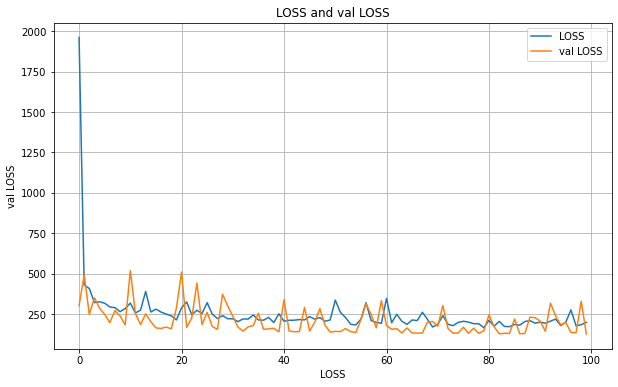

7/7 [==============================] - 0s 10ms/step


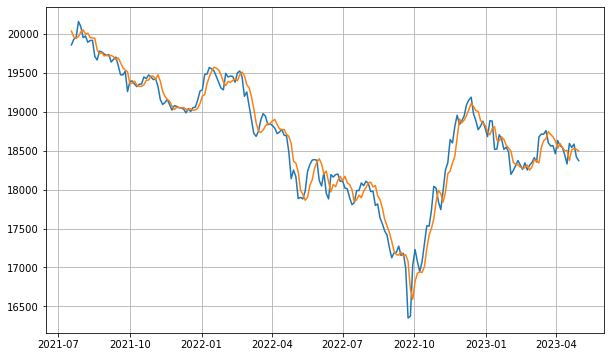

{'mae': 120.95159, 'mse': 26205.834, 'rmse': 161.88216, 'mape': 0.65856224, 'mase': 1.2748902}
Model: "1_model_SGD"


<ipython-input-2-5c4b28aa2962>:6: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = pd.read_csv('./currency_data_10_years.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2688      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,057
Trainable params: 13,057
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
     21/Unknown - 1s 3ms/step - loss: 2660.4636 - mae: 2659.4883 

INFO:tensorflow:Assets written to: saved_model/15\assets


INFO:tensorflow:Assets written to: saved_model/15\assets


31/31 [==============================] - 3s 48ms/step - loss: 1925.9399 - mae: 1925.0304 - val_loss: 125.1382 - val_mae: 124.4356
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 177.3288 - mae: 176.7665 - val_loss: 168.4234 - val_mae: 167.9894
Epoch 3/100
19/31 [=================>............] - ETA: 0s - loss: 196.4742 - mae: 196.0932

INFO:tensorflow:Assets written to: saved_model/15\assets


INFO:tensorflow:Assets written to: saved_model/15\assets


31/31 [==============================] - 1s 39ms/step - loss: 175.4126 - mae: 175.0606 - val_loss: 121.6455 - val_mae: 121.3691
Epoch 4/100
23/31 [=====================>........] - ETA: 0s - loss: 161.5218 - mae: 161.2815

INFO:tensorflow:Assets written to: saved_model/15\assets


INFO:tensorflow:Assets written to: saved_model/15\assets


31/31 [==============================] - 1s 39ms/step - loss: 156.0815 - mae: 155.8525 - val_loss: 117.5323 - val_mae: 117.3480
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 165.7977 - mae: 165.6401 - val_loss: 118.8545 - val_mae: 118.7235
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 147.6869 - mae: 147.5719 - val_loss: 118.0404 - val_mae: 117.9401
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 164.4247 - mae: 164.3327 - val_loss: 434.9349 - val_mae: 434.8516
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 188.2613 - mae: 188.1829 - val_loss: 144.5970 - val_mae: 144.5235
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 132.8181 - mae: 132.7452 - val_loss: 148.4641 - val_mae: 148.3960
Epoch 10/100
31/31 [==============================] - 0s 5ms/step - loss: 137.6847 - mae: 137.6173 - val_loss: 152.8939 - val_mae: 152.8282
Epoch 11/100
23/31 [=================

INFO:tensorflow:Assets written to: saved_model/15\assets


INFO:tensorflow:Assets written to: saved_model/15\assets


31/31 [==============================] - 1s 38ms/step - loss: 136.8506 - mae: 136.7855 - val_loss: 103.3202 - val_mae: 103.2568
Epoch 12/100
31/31 [==============================] - 0s 5ms/step - loss: 121.7488 - mae: 121.6852 - val_loss: 131.5822 - val_mae: 131.5193
Epoch 13/100
23/31 [=====================>........] - ETA: 0s - loss: 115.4146 - mae: 115.3510

INFO:tensorflow:Assets written to: saved_model/15\assets


INFO:tensorflow:Assets written to: saved_model/15\assets


31/31 [==============================] - 2s 46ms/step - loss: 118.2729 - mae: 118.2090 - val_loss: 98.3182 - val_mae: 98.2529
Epoch 14/100
31/31 [==============================] - 0s 5ms/step - loss: 126.5410 - mae: 126.4779 - val_loss: 104.8669 - val_mae: 104.8029
Epoch 15/100
31/31 [==============================] - 0s 5ms/step - loss: 123.9737 - mae: 123.9113 - val_loss: 114.3097 - val_mae: 114.2471
Epoch 16/100
23/31 [=====================>........] - ETA: 0s - loss: 121.9055 - mae: 121.8428

INFO:tensorflow:Assets written to: saved_model/15\assets


INFO:tensorflow:Assets written to: saved_model/15\assets


31/31 [==============================] - 1s 38ms/step - loss: 123.9191 - mae: 123.8565 - val_loss: 90.2454 - val_mae: 90.1813
Epoch 17/100
31/31 [==============================] - 0s 5ms/step - loss: 118.7277 - mae: 118.6638 - val_loss: 116.2117 - val_mae: 116.1494
Epoch 18/100
31/31 [==============================] - 0s 5ms/step - loss: 139.2978 - mae: 139.2347 - val_loss: 137.8663 - val_mae: 137.8032
Epoch 19/100
31/31 [==============================] - 0s 4ms/step - loss: 126.0089 - mae: 125.9467 - val_loss: 136.3658 - val_mae: 136.3016
Epoch 20/100
23/31 [=====================>........] - ETA: 0s - loss: 115.7846 - mae: 115.7221

INFO:tensorflow:Assets written to: saved_model/15\assets


INFO:tensorflow:Assets written to: saved_model/15\assets


31/31 [==============================] - 1s 38ms/step - loss: 111.1504 - mae: 111.0876 - val_loss: 81.1242 - val_mae: 81.0613
Epoch 21/100
31/31 [==============================] - 0s 5ms/step - loss: 102.1896 - mae: 102.1272 - val_loss: 168.6071 - val_mae: 168.5425
Epoch 22/100
31/31 [==============================] - 0s 5ms/step - loss: 119.9826 - mae: 119.9201 - val_loss: 85.0259 - val_mae: 84.9636
Epoch 23/100
22/31 [====================>.........] - ETA: 0s - loss: 91.0491 - mae: 90.9853

INFO:tensorflow:Assets written to: saved_model/15\assets


INFO:tensorflow:Assets written to: saved_model/15\assets


31/31 [==============================] - 1s 38ms/step - loss: 99.8590 - mae: 99.7955 - val_loss: 75.6155 - val_mae: 75.5523
Epoch 24/100
23/31 [=====================>........] - ETA: 0s - loss: 103.1598 - mae: 103.0956

INFO:tensorflow:Assets written to: saved_model/15\assets


INFO:tensorflow:Assets written to: saved_model/15\assets


31/31 [==============================] - 1s 38ms/step - loss: 104.9789 - mae: 104.9151 - val_loss: 70.8120 - val_mae: 70.7464
Epoch 25/100
31/31 [==============================] - 0s 5ms/step - loss: 111.5826 - mae: 111.5188 - val_loss: 76.1389 - val_mae: 76.0722
Epoch 26/100
31/31 [==============================] - 0s 5ms/step - loss: 97.5944 - mae: 97.5308 - val_loss: 103.0657 - val_mae: 103.0005
Epoch 27/100
31/31 [==============================] - 0s 4ms/step - loss: 102.5812 - mae: 102.5166 - val_loss: 112.5073 - val_mae: 112.4429
Epoch 28/100
23/31 [=====================>........] - ETA: 0s - loss: 98.4054 - mae: 98.3406  

INFO:tensorflow:Assets written to: saved_model/15\assets


INFO:tensorflow:Assets written to: saved_model/15\assets


31/31 [==============================] - 1s 38ms/step - loss: 94.6961 - mae: 94.6314 - val_loss: 68.1836 - val_mae: 68.1178
Epoch 29/100
23/31 [=====================>........] - ETA: 0s - loss: 114.0989 - mae: 114.0341

INFO:tensorflow:Assets written to: saved_model/15\assets


INFO:tensorflow:Assets written to: saved_model/15\assets


31/31 [==============================] - 1s 39ms/step - loss: 116.2766 - mae: 116.2121 - val_loss: 66.0999 - val_mae: 66.0364
Epoch 30/100
22/31 [====================>.........] - ETA: 0s - loss: 95.3474 - mae: 95.2839

INFO:tensorflow:Assets written to: saved_model/15\assets


INFO:tensorflow:Assets written to: saved_model/15\assets


31/31 [==============================] - 2s 46ms/step - loss: 92.7254 - mae: 92.6612 - val_loss: 64.9564 - val_mae: 64.8922
Epoch 31/100
31/31 [==============================] - 0s 5ms/step - loss: 116.8770 - mae: 116.8129 - val_loss: 128.6611 - val_mae: 128.5974
Epoch 32/100
31/31 [==============================] - 0s 5ms/step - loss: 95.0981 - mae: 95.0326 - val_loss: 80.2556 - val_mae: 80.1902
Epoch 33/100
31/31 [==============================] - 0s 5ms/step - loss: 108.1085 - mae: 108.0444 - val_loss: 114.4572 - val_mae: 114.3934
Epoch 34/100
31/31 [==============================] - 0s 5ms/step - loss: 98.4078 - mae: 98.3426 - val_loss: 75.8404 - val_mae: 75.7710
Epoch 35/100
31/31 [==============================] - 0s 5ms/step - loss: 92.2129 - mae: 92.1460 - val_loss: 79.8369 - val_mae: 79.7715
Epoch 36/100
31/31 [==============================] - 0s 5ms/step - loss: 78.7239 - mae: 78.6570 - val_loss: 68.4959 - val_mae: 68.4262
Epoch 37/100
31/31 [==============================] 

INFO:tensorflow:Assets written to: saved_model/15\assets


INFO:tensorflow:Assets written to: saved_model/15\assets


31/31 [==============================] - 1s 38ms/step - loss: 69.3491 - mae: 69.2749 - val_loss: 54.6699 - val_mae: 54.5968
Epoch 47/100
31/31 [==============================] - 0s 5ms/step - loss: 74.9629 - mae: 74.8895 - val_loss: 69.1642 - val_mae: 69.0880
Epoch 48/100
31/31 [==============================] - 0s 5ms/step - loss: 79.5824 - mae: 79.5081 - val_loss: 67.2578 - val_mae: 67.1842
Epoch 49/100
31/31 [==============================] - 0s 5ms/step - loss: 98.4236 - mae: 98.3476 - val_loss: 58.8954 - val_mae: 58.8180
Epoch 50/100
31/31 [==============================] - 0s 5ms/step - loss: 86.2973 - mae: 86.2229 - val_loss: 55.3771 - val_mae: 55.3012
Epoch 51/100
31/31 [==============================] - 0s 5ms/step - loss: 80.2862 - mae: 80.2100 - val_loss: 90.0101 - val_mae: 89.9360
Epoch 52/100
31/31 [==============================] - 0s 5ms/step - loss: 96.4950 - mae: 96.4205 - val_loss: 241.5713 - val_mae: 241.4971
Epoch 53/100
31/31 [==============================] - 0s 5

INFO:tensorflow:Assets written to: saved_model/15\assets


INFO:tensorflow:Assets written to: saved_model/15\assets


31/31 [==============================] - 1s 38ms/step - loss: 77.3351 - mae: 77.2597 - val_loss: 53.4805 - val_mae: 53.4068
Epoch 67/100
31/31 [==============================] - 0s 5ms/step - loss: 85.7883 - mae: 85.7140 - val_loss: 75.9756 - val_mae: 75.9016
Epoch 68/100
31/31 [==============================] - 0s 5ms/step - loss: 86.0617 - mae: 85.9882 - val_loss: 152.5217 - val_mae: 152.4486
Epoch 69/100
31/31 [==============================] - 0s 5ms/step - loss: 88.7036 - mae: 88.6294 - val_loss: 81.9823 - val_mae: 81.9066
Epoch 70/100
31/31 [==============================] - 0s 5ms/step - loss: 84.5221 - mae: 84.4490 - val_loss: 59.9902 - val_mae: 59.9151
Epoch 71/100
31/31 [==============================] - 0s 5ms/step - loss: 91.5666 - mae: 91.4933 - val_loss: 117.3404 - val_mae: 117.2685
Epoch 72/100
31/31 [==============================] - 0s 5ms/step - loss: 84.5626 - mae: 84.4898 - val_loss: 114.6113 - val_mae: 114.5395
Epoch 73/100
31/31 [==============================] - 

INFO:tensorflow:Assets written to: saved_model/15\assets


INFO:tensorflow:Assets written to: saved_model/15\assets


31/31 [==============================] - 1s 38ms/step - loss: 81.8653 - mae: 81.7922 - val_loss: 52.5480 - val_mae: 52.4769
Epoch 75/100
31/31 [==============================] - 0s 5ms/step - loss: 70.0770 - mae: 70.0050 - val_loss: 83.4636 - val_mae: 83.3913
Epoch 76/100
31/31 [==============================] - 0s 5ms/step - loss: 76.1000 - mae: 76.0284 - val_loss: 119.9616 - val_mae: 119.8908
Epoch 77/100
31/31 [==============================] - 0s 5ms/step - loss: 103.6040 - mae: 103.5313 - val_loss: 120.5711 - val_mae: 120.5004
Epoch 78/100
31/31 [==============================] - 0s 4ms/step - loss: 106.8127 - mae: 106.7416 - val_loss: 52.6831 - val_mae: 52.6132
Epoch 79/100
31/31 [==============================] - 0s 5ms/step - loss: 69.5360 - mae: 69.4652 - val_loss: 81.0004 - val_mae: 80.9293
Epoch 80/100
31/31 [==============================] - 0s 5ms/step - loss: 94.8138 - mae: 94.7429 - val_loss: 118.6401 - val_mae: 118.5704
Epoch 81/100
22/31 [====================>.........

INFO:tensorflow:Assets written to: saved_model/15\assets


INFO:tensorflow:Assets written to: saved_model/15\assets


31/31 [==============================] - 1s 38ms/step - loss: 72.4103 - mae: 72.3398 - val_loss: 51.5752 - val_mae: 51.5058
Epoch 82/100
31/31 [==============================] - 0s 5ms/step - loss: 76.2275 - mae: 76.1575 - val_loss: 114.4546 - val_mae: 114.3853
Epoch 83/100
31/31 [==============================] - 0s 5ms/step - loss: 99.4269 - mae: 99.3565 - val_loss: 206.6416 - val_mae: 206.5725
Epoch 84/100
31/31 [==============================] - 0s 5ms/step - loss: 136.0594 - mae: 135.9905 - val_loss: 60.1628 - val_mae: 60.0946
Epoch 85/100
31/31 [==============================] - 0s 5ms/step - loss: 75.0018 - mae: 74.9328 - val_loss: 62.5905 - val_mae: 62.5194
Epoch 86/100
31/31 [==============================] - 0s 5ms/step - loss: 80.3079 - mae: 80.2374 - val_loss: 54.8063 - val_mae: 54.7338
Epoch 87/100
31/31 [==============================] - 0s 5ms/step - loss: 65.3433 - mae: 65.2738 - val_loss: 52.7542 - val_mae: 52.6848
Epoch 88/100
31/31 [==============================] - 

INFO:tensorflow:Assets written to: saved_model/15\assets


INFO:tensorflow:Assets written to: saved_model/15\assets


31/31 [==============================] - 1s 37ms/step - loss: 81.4887 - mae: 81.4194 - val_loss: 51.1103 - val_mae: 51.0412
Epoch 91/100
31/31 [==============================] - 0s 5ms/step - loss: 66.7487 - mae: 66.6804 - val_loss: 57.5432 - val_mae: 57.4710
Epoch 92/100
23/31 [=====================>........] - ETA: 0s - loss: 77.7369 - mae: 77.6671

INFO:tensorflow:Assets written to: saved_model/15\assets


INFO:tensorflow:Assets written to: saved_model/15\assets


31/31 [==============================] - 1s 44ms/step - loss: 73.4183 - mae: 73.3482 - val_loss: 49.3190 - val_mae: 49.2515
Epoch 93/100
31/31 [==============================] - 0s 5ms/step - loss: 80.1793 - mae: 80.1113 - val_loss: 49.3994 - val_mae: 49.3308
Epoch 94/100
31/31 [==============================] - 0s 5ms/step - loss: 74.9946 - mae: 74.9260 - val_loss: 95.1413 - val_mae: 95.0742
Epoch 95/100
31/31 [==============================] - 0s 5ms/step - loss: 73.1670 - mae: 73.0971 - val_loss: 49.4305 - val_mae: 49.3621
Epoch 96/100
31/31 [==============================] - 0s 5ms/step - loss: 74.5857 - mae: 74.5175 - val_loss: 98.9151 - val_mae: 98.8483
Epoch 97/100
31/31 [==============================] - 0s 5ms/step - loss: 67.3243 - mae: 67.2567 - val_loss: 75.5114 - val_mae: 75.4450
Epoch 98/100
31/31 [==============================] - 0s 5ms/step - loss: 71.2313 - mae: 71.1634 - val_loss: 70.9352 - val_mae: 70.8686
Epoch 99/100
23/31 [=====================>........] - ETA: 0

INFO:tensorflow:Assets written to: saved_model/15\assets


INFO:tensorflow:Assets written to: saved_model/15\assets


31/31 [==============================] - 1s 37ms/step - loss: 64.1708 - mae: 64.1035 - val_loss: 48.9058 - val_mae: 48.8385
Epoch 100/100
7/7 [==============================] - 0s 7ms/step - loss: 61.7944 - mae: 61.7266


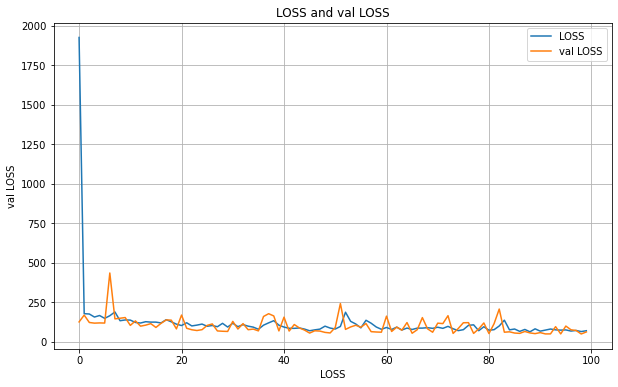

7/7 [==============================] - 0s 10ms/step


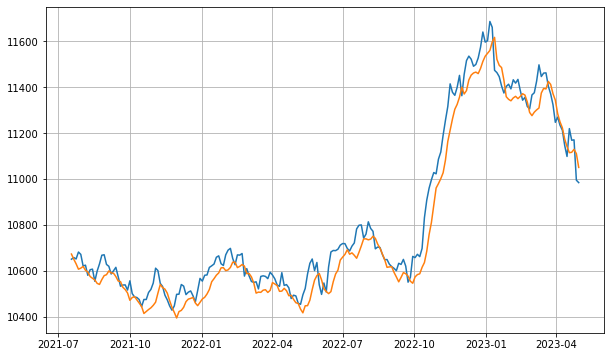

{'mae': 59.54666, 'mse': 5704.9136, 'rmse': 75.530876, 'mape': 0.5461812, 'mase': 1.8414965}


<ipython-input-2-5c4b28aa2962>:6: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = pd.read_csv('./currency_data_10_years.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


Model: "1_model_AUD"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2688      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,057
Trainable params: 13,057
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
     21/Unknown - 1s 3ms/step - loss: 3903.8792 - mae: 3902.8997 

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


31/31 [==============================] - 3s 48ms/step - loss: 2848.8008 - mae: 2847.8872 - val_loss: 185.3338 - val_mae: 184.6320
Epoch 2/100
23/31 [=====================>........] - ETA: 0s - loss: 231.5840 - mae: 230.9929

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


31/31 [==============================] - 1s 40ms/step - loss: 219.8228 - mae: 219.2643 - val_loss: 174.9394 - val_mae: 174.5126
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 192.9796 - mae: 192.6377 - val_loss: 196.6943 - val_mae: 196.4301
Epoch 4/100
23/31 [=====================>........] - ETA: 0s - loss: 204.5652 - mae: 204.3398

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


31/31 [==============================] - 1s 38ms/step - loss: 200.9283 - mae: 200.7139 - val_loss: 173.0317 - val_mae: 172.8618
Epoch 5/100
23/31 [=====================>........] - ETA: 0s - loss: 198.7155 - mae: 198.5698

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


31/31 [==============================] - 2s 45ms/step - loss: 198.4897 - mae: 198.3506 - val_loss: 169.7851 - val_mae: 169.6721
Epoch 6/100
23/31 [=====================>........] - ETA: 0s - loss: 178.8809 - mae: 178.7806

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


31/31 [==============================] - 1s 38ms/step - loss: 183.3749 - mae: 183.2783 - val_loss: 166.7648 - val_mae: 166.6824
Epoch 7/100
22/31 [====================>.........] - ETA: 0s - loss: 177.6168 - mae: 177.5415

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


31/31 [==============================] - 1s 39ms/step - loss: 175.4463 - mae: 175.3735 - val_loss: 164.6057 - val_mae: 164.5417
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 176.7357 - mae: 176.6757 - val_loss: 201.4550 - val_mae: 201.4008
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 182.0238 - mae: 181.9718 - val_loss: 165.1049 - val_mae: 165.0564
Epoch 10/100
23/31 [=====================>........] - ETA: 0s - loss: 166.6729 - mae: 166.6244

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


31/31 [==============================] - 1s 38ms/step - loss: 168.3721 - mae: 168.3243 - val_loss: 163.4170 - val_mae: 163.3691
Epoch 11/100
31/31 [==============================] - 0s 5ms/step - loss: 171.1402 - mae: 171.0960 - val_loss: 181.1137 - val_mae: 181.0705
Epoch 12/100
23/31 [=====================>........] - ETA: 0s - loss: 180.2576 - mae: 180.2140

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


31/31 [==============================] - 1s 39ms/step - loss: 174.1522 - mae: 174.1090 - val_loss: 162.8043 - val_mae: 162.7626
Epoch 13/100
23/31 [=====================>........] - ETA: 0s - loss: 158.0239 - mae: 157.9811

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


31/31 [==============================] - 1s 38ms/step - loss: 157.8926 - mae: 157.8492 - val_loss: 154.1147 - val_mae: 154.0738
Epoch 14/100
31/31 [==============================] - 0s 5ms/step - loss: 186.5239 - mae: 186.4821 - val_loss: 155.4707 - val_mae: 155.4271
Epoch 15/100
31/31 [==============================] - 0s 5ms/step - loss: 177.5819 - mae: 177.5421 - val_loss: 192.2878 - val_mae: 192.2483
Epoch 16/100
23/31 [=====================>........] - ETA: 0s - loss: 152.3213 - mae: 152.2821

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


31/31 [==============================] - 2s 45ms/step - loss: 153.0883 - mae: 153.0490 - val_loss: 145.3079 - val_mae: 145.2673
Epoch 17/100
31/31 [==============================] - 0s 5ms/step - loss: 160.5335 - mae: 160.4949 - val_loss: 211.5545 - val_mae: 211.5162
Epoch 18/100
31/31 [==============================] - 0s 5ms/step - loss: 209.9503 - mae: 209.9120 - val_loss: 326.5194 - val_mae: 326.4819
Epoch 19/100
31/31 [==============================] - 0s 5ms/step - loss: 228.2707 - mae: 228.2329 - val_loss: 214.4957 - val_mae: 214.4587
Epoch 20/100
31/31 [==============================] - 0s 5ms/step - loss: 182.4301 - mae: 182.3929 - val_loss: 158.0454 - val_mae: 158.0085
Epoch 21/100
22/31 [====================>.........] - ETA: 0s - loss: 186.5445 - mae: 186.5075

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


31/31 [==============================] - 1s 38ms/step - loss: 188.4616 - mae: 188.4248 - val_loss: 143.6015 - val_mae: 143.5657
Epoch 22/100
31/31 [==============================] - 0s 5ms/step - loss: 166.1998 - mae: 166.1639 - val_loss: 223.8596 - val_mae: 223.8242
Epoch 23/100
31/31 [==============================] - 0s 5ms/step - loss: 157.1065 - mae: 157.0700 - val_loss: 155.2845 - val_mae: 155.2493
Epoch 24/100
31/31 [==============================] - 0s 5ms/step - loss: 157.8416 - mae: 157.8065 - val_loss: 147.6963 - val_mae: 147.6616
Epoch 25/100
23/31 [=====================>........] - ETA: 0s - loss: 149.2995 - mae: 149.2638

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


31/31 [==============================] - 1s 38ms/step - loss: 147.2932 - mae: 147.2574 - val_loss: 133.6447 - val_mae: 133.6086
Epoch 26/100
31/31 [==============================] - 0s 5ms/step - loss: 143.5525 - mae: 143.5184 - val_loss: 170.4349 - val_mae: 170.4011
Epoch 27/100
31/31 [==============================] - 0s 5ms/step - loss: 154.1561 - mae: 154.1222 - val_loss: 143.6139 - val_mae: 143.5806
Epoch 28/100
31/31 [==============================] - 0s 5ms/step - loss: 142.4220 - mae: 142.3887 - val_loss: 140.7428 - val_mae: 140.7096
Epoch 29/100
22/31 [====================>.........] - ETA: 0s - loss: 145.3534 - mae: 145.3201

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


31/31 [==============================] - 1s 38ms/step - loss: 144.6728 - mae: 144.6395 - val_loss: 126.6177 - val_mae: 126.5845
Epoch 30/100
23/31 [=====================>........] - ETA: 0s - loss: 138.2794 - mae: 138.2453

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


31/31 [==============================] - 1s 41ms/step - loss: 138.8346 - mae: 138.8007 - val_loss: 124.8681 - val_mae: 124.8321
Epoch 31/100
31/31 [==============================] - 0s 5ms/step - loss: 138.0172 - mae: 137.9836 - val_loss: 156.3381 - val_mae: 156.3056
Epoch 32/100
31/31 [==============================] - 0s 5ms/step - loss: 200.1380 - mae: 200.1055 - val_loss: 137.2319 - val_mae: 137.1998
Epoch 33/100
23/31 [=====================>........] - ETA: 0s - loss: 125.4654 - mae: 125.4327

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


31/31 [==============================] - 1s 41ms/step - loss: 123.6936 - mae: 123.6605 - val_loss: 123.1789 - val_mae: 123.1446
Epoch 34/100
31/31 [==============================] - 0s 5ms/step - loss: 141.7755 - mae: 141.7430 - val_loss: 156.5633 - val_mae: 156.5289
Epoch 35/100
23/31 [=====================>........] - ETA: 0s - loss: 132.2572 - mae: 132.2241

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


31/31 [==============================] - 2s 45ms/step - loss: 130.0608 - mae: 130.0272 - val_loss: 119.1882 - val_mae: 119.1516
Epoch 36/100
31/31 [==============================] - 0s 5ms/step - loss: 135.8552 - mae: 135.8211 - val_loss: 129.1882 - val_mae: 129.1529
Epoch 37/100
31/31 [==============================] - 0s 5ms/step - loss: 143.4115 - mae: 143.3757 - val_loss: 190.8776 - val_mae: 190.8427
Epoch 38/100
21/31 [===================>..........] - ETA: 0s - loss: 136.1870 - mae: 136.1516

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


31/31 [==============================] - 1s 38ms/step - loss: 138.4318 - mae: 138.3962 - val_loss: 117.4995 - val_mae: 117.4632
Epoch 39/100
23/31 [=====================>........] - ETA: 0s - loss: 115.4732 - mae: 115.4362

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


31/31 [==============================] - 1s 39ms/step - loss: 126.7506 - mae: 126.7138 - val_loss: 113.1305 - val_mae: 113.0892
Epoch 40/100
31/31 [==============================] - 0s 5ms/step - loss: 130.4087 - mae: 130.3716 - val_loss: 116.8287 - val_mae: 116.7898
Epoch 41/100
31/31 [==============================] - 0s 5ms/step - loss: 113.1426 - mae: 113.1042 - val_loss: 132.1429 - val_mae: 132.1025
Epoch 42/100
31/31 [==============================] - 0s 5ms/step - loss: 131.0477 - mae: 131.0099 - val_loss: 179.5374 - val_mae: 179.5001
Epoch 43/100
31/31 [==============================] - 0s 5ms/step - loss: 150.4048 - mae: 150.3664 - val_loss: 113.3061 - val_mae: 113.2664
Epoch 44/100
23/31 [=====================>........] - ETA: 0s - loss: 116.9471 - mae: 116.9086

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


31/31 [==============================] - 1s 38ms/step - loss: 113.7390 - mae: 113.7005 - val_loss: 107.0730 - val_mae: 107.0323
Epoch 45/100
31/31 [==============================] - 0s 5ms/step - loss: 126.9566 - mae: 126.9180 - val_loss: 109.6424 - val_mae: 109.6005
Epoch 46/100
31/31 [==============================] - 0s 5ms/step - loss: 124.0357 - mae: 123.9973 - val_loss: 119.9634 - val_mae: 119.9255
Epoch 47/100
31/31 [==============================] - 0s 5ms/step - loss: 115.8564 - mae: 115.8165 - val_loss: 112.8026 - val_mae: 112.7642
Epoch 48/100
31/31 [==============================] - 0s 5ms/step - loss: 124.5031 - mae: 124.4637 - val_loss: 126.2439 - val_mae: 126.2053
Epoch 49/100
31/31 [==============================] - 0s 5ms/step - loss: 116.0876 - mae: 116.0487 - val_loss: 149.2477 - val_mae: 149.2094
Epoch 50/100
31/31 [==============================] - 0s 5ms/step - loss: 130.7007 - mae: 130.6614 - val_loss: 116.6837 - val_mae: 116.6451
Epoch 51/100
31/31 [============

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


31/31 [==============================] - 1s 38ms/step - loss: 132.6115 - mae: 132.5737 - val_loss: 102.7947 - val_mae: 102.7580
Epoch 53/100
31/31 [==============================] - 0s 5ms/step - loss: 115.1950 - mae: 115.1577 - val_loss: 155.3240 - val_mae: 155.2872
Epoch 54/100
31/31 [==============================] - 0s 5ms/step - loss: 204.4006 - mae: 204.3640 - val_loss: 243.4744 - val_mae: 243.4386
Epoch 55/100
31/31 [==============================] - 0s 5ms/step - loss: 147.3714 - mae: 147.3348 - val_loss: 108.3524 - val_mae: 108.3160
Epoch 56/100
31/31 [==============================] - 0s 5ms/step - loss: 109.1736 - mae: 109.1374 - val_loss: 105.3281 - val_mae: 105.2931
Epoch 57/100
22/31 [====================>.........] - ETA: 0s - loss: 117.4262 - mae: 117.3896

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


31/31 [==============================] - 1s 39ms/step - loss: 114.1298 - mae: 114.0921 - val_loss: 101.1569 - val_mae: 101.1199
Epoch 58/100
31/31 [==============================] - 0s 5ms/step - loss: 101.6863 - mae: 101.6508 - val_loss: 109.6322 - val_mae: 109.5976
Epoch 59/100
31/31 [==============================] - 0s 5ms/step - loss: 103.9380 - mae: 103.9029 - val_loss: 137.1661 - val_mae: 137.1316
Epoch 60/100
31/31 [==============================] - 0s 5ms/step - loss: 116.7126 - mae: 116.6777 - val_loss: 103.7635 - val_mae: 103.7276
Epoch 61/100
31/31 [==============================] - 0s 5ms/step - loss: 109.9689 - mae: 109.9333 - val_loss: 117.9422 - val_mae: 117.9075
Epoch 62/100
31/31 [==============================] - 0s 4ms/step - loss: 102.3674 - mae: 102.3323 - val_loss: 122.5182 - val_mae: 122.4834
Epoch 63/100
31/31 [==============================] - 0s 5ms/step - loss: 115.0115 - mae: 114.9757 - val_loss: 134.3329 - val_mae: 134.2973
Epoch 64/100
31/31 [============

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


31/31 [==============================] - 1s 45ms/step - loss: 106.5573 - mae: 106.5235 - val_loss: 100.0321 - val_mae: 100.0001
Epoch 70/100
23/31 [=====================>........] - ETA: 0s - loss: 115.8224 - mae: 115.7901

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


31/31 [==============================] - 1s 38ms/step - loss: 121.7647 - mae: 121.7325 - val_loss: 99.3022 - val_mae: 99.2710
Epoch 71/100
22/31 [====================>.........] - ETA: 0s - loss: 112.4402 - mae: 112.4086

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


31/31 [==============================] - 1s 38ms/step - loss: 108.6161 - mae: 108.5848 - val_loss: 98.6913 - val_mae: 98.6599
Epoch 72/100
23/31 [=====================>........] - ETA: 0s - loss: 140.2720 - mae: 140.2399

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


31/31 [==============================] - 1s 39ms/step - loss: 129.2775 - mae: 129.2456 - val_loss: 94.9268 - val_mae: 94.8965
Epoch 73/100
31/31 [==============================] - 0s 5ms/step - loss: 163.6142 - mae: 163.5836 - val_loss: 95.2056 - val_mae: 95.1740
Epoch 74/100
31/31 [==============================] - 0s 5ms/step - loss: 109.1167 - mae: 109.0861 - val_loss: 95.7296 - val_mae: 95.6981
Epoch 75/100
31/31 [==============================] - 0s 5ms/step - loss: 147.6866 - mae: 147.6557 - val_loss: 162.5501 - val_mae: 162.5199
Epoch 76/100
31/31 [==============================] - 0s 5ms/step - loss: 113.5373 - mae: 113.5072 - val_loss: 157.9263 - val_mae: 157.8974
Epoch 77/100
31/31 [==============================] - 0s 5ms/step - loss: 110.2118 - mae: 110.1821 - val_loss: 138.9215 - val_mae: 138.8929
Epoch 78/100
31/31 [==============================] - 0s 5ms/step - loss: 123.9860 - mae: 123.9573 - val_loss: 97.2571 - val_mae: 97.2285
Epoch 79/100
31/31 [====================

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


31/31 [==============================] - 1s 38ms/step - loss: 99.6658 - mae: 99.6376 - val_loss: 89.8359 - val_mae: 89.8111
Epoch 91/100
31/31 [==============================] - 0s 5ms/step - loss: 95.2547 - mae: 95.2295 - val_loss: 115.3907 - val_mae: 115.3638
Epoch 92/100
31/31 [==============================] - 0s 5ms/step - loss: 116.4894 - mae: 116.4641 - val_loss: 108.8689 - val_mae: 108.8420
Epoch 93/100
31/31 [==============================] - 0s 5ms/step - loss: 107.8278 - mae: 107.8028 - val_loss: 98.5294 - val_mae: 98.5052
Epoch 94/100
31/31 [==============================] - 0s 5ms/step - loss: 116.8048 - mae: 116.7793 - val_loss: 96.0082 - val_mae: 95.9844
Epoch 95/100
31/31 [==============================] - 0s 5ms/step - loss: 104.5985 - mae: 104.5751 - val_loss: 106.7560 - val_mae: 106.7329
Epoch 96/100
23/31 [=====================>........] - ETA: 0s - loss: 103.2053 - mae: 103.1807

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


31/31 [==============================] - 1s 38ms/step - loss: 100.0675 - mae: 100.0430 - val_loss: 88.7951 - val_mae: 88.7694
Epoch 97/100
23/31 [=====================>........] - ETA: 0s - loss: 89.7298 - mae: 89.7056

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


31/31 [==============================] - 1s 39ms/step - loss: 88.6564 - mae: 88.6326 - val_loss: 88.6838 - val_mae: 88.6590
Epoch 98/100
31/31 [==============================] - 0s 5ms/step - loss: 96.3806 - mae: 96.3576 - val_loss: 131.5644 - val_mae: 131.5420
Epoch 99/100
31/31 [==============================] - 0s 5ms/step - loss: 105.6042 - mae: 105.5806 - val_loss: 95.2089 - val_mae: 95.1851
Epoch 100/100
22/31 [====================>.........] - ETA: 0s - loss: 98.1573 - mae: 98.1354  

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


7/7 [==============================] - 0s 7ms/step - loss: 87.4760 - mae: 87.4542


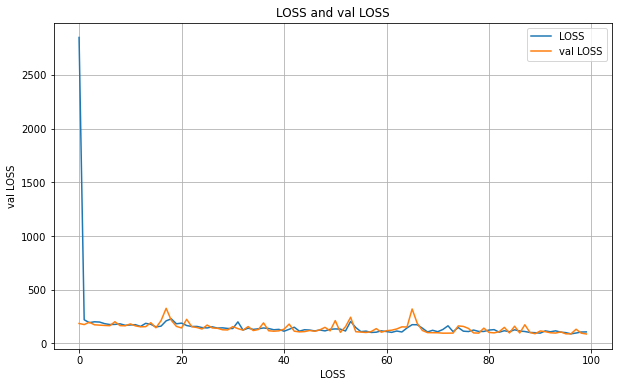

7/7 [==============================] - 0s 10ms/step


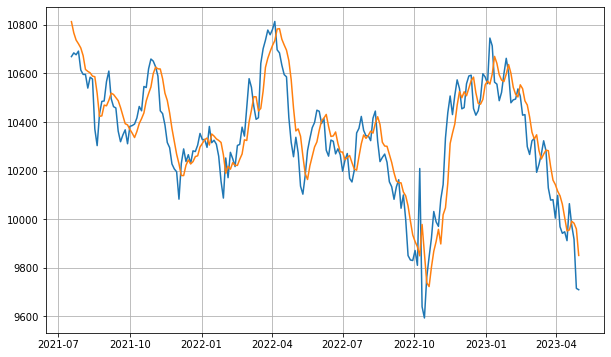

{'mae': 86.117905, 'mse': 11781.028, 'rmse': 108.54044, 'mape': 0.83638036, 'mase': 1.3875268}


<ipython-input-2-5c4b28aa2962>:6: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = pd.read_csv('./currency_data_10_years.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


Model: "1_model_CNY"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2688      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,057
Trainable params: 13,057
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
     21/Unknown - 1s 3ms/step - loss: 261.4631 - mae: 260.5075 

INFO:tensorflow:Assets written to: saved_model/17\assets


INFO:tensorflow:Assets written to: saved_model/17\assets


31/31 [==============================] - 3s 47ms/step - loss: 191.4564 - mae: 190.5671 - val_loss: 26.5012 - val_mae: 25.8246
Epoch 2/100
22/31 [====================>.........] - ETA: 0s - loss: 43.8524 - mae: 43.2850

INFO:tensorflow:Assets written to: saved_model/17\assets


INFO:tensorflow:Assets written to: saved_model/17\assets


31/31 [==============================] - 1s 40ms/step - loss: 40.3333 - mae: 39.8025 - val_loss: 25.7149 - val_mae: 25.3157
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 34.3136 - mae: 33.9979 - val_loss: 48.4060 - val_mae: 48.1691
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 41.6476 - mae: 41.4547 - val_loss: 30.5519 - val_mae: 30.4037
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 34.0653 - mae: 33.9453 - val_loss: 26.5369 - val_mae: 26.4427
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 34.5163 - mae: 34.4377 - val_loss: 37.1981 - val_mae: 37.1375
Epoch 7/100
23/31 [=====================>........] - ETA: 0s - loss: 37.6740 - mae: 37.6146

INFO:tensorflow:Assets written to: saved_model/17\assets


INFO:tensorflow:Assets written to: saved_model/17\assets


31/31 [==============================] - 1s 38ms/step - loss: 35.0761 - mae: 35.0189 - val_loss: 23.0064 - val_mae: 22.9592
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 34.2105 - mae: 34.1682 - val_loss: 30.0654 - val_mae: 30.0295
Epoch 9/100
23/31 [=====================>........] - ETA: 0s - loss: 27.5138 - mae: 27.4767

INFO:tensorflow:Assets written to: saved_model/17\assets


INFO:tensorflow:Assets written to: saved_model/17\assets


31/31 [==============================] - 1s 38ms/step - loss: 27.6303 - mae: 27.5946 - val_loss: 21.1684 - val_mae: 21.1354
Epoch 10/100
31/31 [==============================] - 0s 5ms/step - loss: 35.0974 - mae: 35.0672 - val_loss: 21.2614 - val_mae: 21.2317
Epoch 11/100
31/31 [==============================] - 0s 5ms/step - loss: 36.4142 - mae: 36.3882 - val_loss: 52.2548 - val_mae: 52.2311
Epoch 12/100
23/31 [=====================>........] - ETA: 0s - loss: 36.8183 - mae: 36.7925

INFO:tensorflow:Assets written to: saved_model/17\assets


INFO:tensorflow:Assets written to: saved_model/17\assets


31/31 [==============================] - 1s 45ms/step - loss: 34.5541 - mae: 34.5290 - val_loss: 20.2656 - val_mae: 20.2412
Epoch 13/100
31/31 [==============================] - 0s 5ms/step - loss: 40.1211 - mae: 40.0987 - val_loss: 34.5294 - val_mae: 34.5049
Epoch 14/100
31/31 [==============================] - 0s 5ms/step - loss: 30.6577 - mae: 30.6346 - val_loss: 27.0421 - val_mae: 27.0203
Epoch 15/100
31/31 [==============================] - 0s 5ms/step - loss: 29.4937 - mae: 29.4712 - val_loss: 34.0166 - val_mae: 33.9949
Epoch 16/100
31/31 [==============================] - 0s 5ms/step - loss: 38.6852 - mae: 38.6638 - val_loss: 25.0875 - val_mae: 25.0642
Epoch 17/100
31/31 [==============================] - 0s 4ms/step - loss: 38.4098 - mae: 38.3908 - val_loss: 57.0399 - val_mae: 57.0233
Epoch 18/100
31/31 [==============================] - 0s 5ms/step - loss: 31.5172 - mae: 31.4970 - val_loss: 60.1940 - val_mae: 60.1780
Epoch 19/100
31/31 [==============================] - 0s 5ms

INFO:tensorflow:Assets written to: saved_model/17\assets


INFO:tensorflow:Assets written to: saved_model/17\assets


31/31 [==============================] - 1s 38ms/step - loss: 26.8299 - mae: 26.8126 - val_loss: 18.9483 - val_mae: 18.9337
Epoch 26/100
23/31 [=====================>........] - ETA: 0s - loss: 23.2909 - mae: 23.2748

INFO:tensorflow:Assets written to: saved_model/17\assets


INFO:tensorflow:Assets written to: saved_model/17\assets


31/31 [==============================] - 1s 38ms/step - loss: 22.5699 - mae: 22.5534 - val_loss: 18.4746 - val_mae: 18.4468
Epoch 27/100
22/31 [====================>.........] - ETA: 0s - loss: 24.1755 - mae: 24.1570

INFO:tensorflow:Assets written to: saved_model/17\assets


INFO:tensorflow:Assets written to: saved_model/17\assets


31/31 [==============================] - 1s 39ms/step - loss: 23.9122 - mae: 23.8948 - val_loss: 17.5588 - val_mae: 17.5372
Epoch 28/100
31/31 [==============================] - 0s 5ms/step - loss: 28.9319 - mae: 28.9169 - val_loss: 21.7902 - val_mae: 21.7784
Epoch 29/100
23/31 [=====================>........] - ETA: 0s - loss: 24.4465 - mae: 24.4328

INFO:tensorflow:Assets written to: saved_model/17\assets


INFO:tensorflow:Assets written to: saved_model/17\assets


31/31 [==============================] - 1s 38ms/step - loss: 23.4332 - mae: 23.4183 - val_loss: 16.8197 - val_mae: 16.8000
Epoch 30/100
31/31 [==============================] - 0s 5ms/step - loss: 23.4044 - mae: 23.3906 - val_loss: 21.6212 - val_mae: 21.6101
Epoch 31/100
23/31 [=====================>........] - ETA: 0s - loss: 21.5504 - mae: 21.5363

INFO:tensorflow:Assets written to: saved_model/17\assets


INFO:tensorflow:Assets written to: saved_model/17\assets


31/31 [==============================] - 1s 39ms/step - loss: 22.9059 - mae: 22.8928 - val_loss: 16.3882 - val_mae: 16.3676
Epoch 32/100
31/31 [==============================] - 0s 5ms/step - loss: 22.9271 - mae: 22.9128 - val_loss: 24.2004 - val_mae: 24.1909
Epoch 33/100
31/31 [==============================] - 0s 5ms/step - loss: 27.4575 - mae: 27.4468 - val_loss: 17.9712 - val_mae: 17.9586
Epoch 34/100
31/31 [==============================] - 0s 5ms/step - loss: 26.5333 - mae: 26.5233 - val_loss: 48.0563 - val_mae: 48.0483
Epoch 35/100
31/31 [==============================] - 0s 5ms/step - loss: 32.0996 - mae: 32.0883 - val_loss: 17.2388 - val_mae: 17.2258
Epoch 36/100
31/31 [==============================] - 0s 5ms/step - loss: 22.3193 - mae: 22.3067 - val_loss: 26.9097 - val_mae: 26.9019
Epoch 37/100
31/31 [==============================] - 0s 5ms/step - loss: 24.8888 - mae: 24.8771 - val_loss: 20.9469 - val_mae: 20.9387
Epoch 38/100
31/31 [==============================] - 0s 5ms

INFO:tensorflow:Assets written to: saved_model/17\assets


INFO:tensorflow:Assets written to: saved_model/17\assets


31/31 [==============================] - 2s 45ms/step - loss: 21.0848 - mae: 21.0728 - val_loss: 15.1948 - val_mae: 15.1800
Epoch 41/100
31/31 [==============================] - 0s 5ms/step - loss: 20.3279 - mae: 20.3143 - val_loss: 16.4289 - val_mae: 16.4179
Epoch 42/100
31/31 [==============================] - 0s 5ms/step - loss: 26.6368 - mae: 26.6273 - val_loss: 16.9398 - val_mae: 16.9280
Epoch 43/100
31/31 [==============================] - 0s 5ms/step - loss: 19.3264 - mae: 19.3145 - val_loss: 16.2708 - val_mae: 16.2610
Epoch 44/100
31/31 [==============================] - 0s 5ms/step - loss: 20.3638 - mae: 20.3524 - val_loss: 16.3418 - val_mae: 16.3301
Epoch 45/100
31/31 [==============================] - 0s 5ms/step - loss: 21.4564 - mae: 21.4429 - val_loss: 48.9229 - val_mae: 48.9164
Epoch 46/100
31/31 [==============================] - 0s 5ms/step - loss: 44.3809 - mae: 44.3720 - val_loss: 46.6651 - val_mae: 46.6579
Epoch 47/100
31/31 [==============================] - 0s 5ms

INFO:tensorflow:Assets written to: saved_model/17\assets


INFO:tensorflow:Assets written to: saved_model/17\assets


31/31 [==============================] - 1s 42ms/step - loss: 21.7973 - mae: 21.7870 - val_loss: 14.5983 - val_mae: 14.5799
Epoch 53/100
31/31 [==============================] - 0s 5ms/step - loss: 21.6880 - mae: 21.6778 - val_loss: 15.2346 - val_mae: 15.2209
Epoch 54/100
31/31 [==============================] - 0s 5ms/step - loss: 20.6761 - mae: 20.6655 - val_loss: 37.5199 - val_mae: 37.5144
Epoch 55/100
23/31 [=====================>........] - ETA: 0s - loss: 19.4561 - mae: 19.4468

INFO:tensorflow:Assets written to: saved_model/17\assets


INFO:tensorflow:Assets written to: saved_model/17\assets


31/31 [==============================] - 1s 38ms/step - loss: 18.6588 - mae: 18.6489 - val_loss: 13.8280 - val_mae: 13.8119
Epoch 56/100
31/31 [==============================] - 0s 5ms/step - loss: 21.6218 - mae: 21.6137 - val_loss: 15.8124 - val_mae: 15.7932
Epoch 57/100
31/31 [==============================] - 0s 4ms/step - loss: 20.5395 - mae: 20.5329 - val_loss: 14.6104 - val_mae: 14.5947
Epoch 58/100
31/31 [==============================] - 0s 5ms/step - loss: 18.0455 - mae: 18.0345 - val_loss: 17.3163 - val_mae: 17.3116
Epoch 59/100
31/31 [==============================] - 0s 5ms/step - loss: 16.6319 - mae: 16.6213 - val_loss: 24.1991 - val_mae: 24.1922
Epoch 60/100
31/31 [==============================] - 0s 5ms/step - loss: 20.8539 - mae: 20.8446 - val_loss: 16.9226 - val_mae: 16.9153
Epoch 61/100
31/31 [==============================] - 0s 5ms/step - loss: 19.0130 - mae: 19.0052 - val_loss: 31.9531 - val_mae: 31.9492
Epoch 62/100
31/31 [==============================] - 0s 5ms

INFO:tensorflow:Assets written to: saved_model/17\assets


INFO:tensorflow:Assets written to: saved_model/17\assets


31/31 [==============================] - 1s 38ms/step - loss: 24.0225 - mae: 24.0204 - val_loss: 12.8196 - val_mae: 12.8118
Epoch 71/100
31/31 [==============================] - 0s 4ms/step - loss: 16.4731 - mae: 16.4673 - val_loss: 14.4821 - val_mae: 14.4774
Epoch 72/100
31/31 [==============================] - 0s 5ms/step - loss: 19.6324 - mae: 19.6327 - val_loss: 27.6168 - val_mae: 27.6182
Epoch 73/100
31/31 [==============================] - 0s 5ms/step - loss: 32.7313 - mae: 32.7322 - val_loss: 46.0313 - val_mae: 46.0355
Epoch 74/100
31/31 [==============================] - 0s 5ms/step - loss: 38.0327 - mae: 38.0359 - val_loss: 23.0800 - val_mae: 23.0830
Epoch 75/100
31/31 [==============================] - 0s 5ms/step - loss: 25.4559 - mae: 25.4573 - val_loss: 25.9618 - val_mae: 25.9674
Epoch 76/100
31/31 [==============================] - 0s 5ms/step - loss: 19.7001 - mae: 19.7011 - val_loss: 13.4022 - val_mae: 13.4001
Epoch 77/100
31/31 [==============================] - 0s 5ms

INFO:tensorflow:Assets written to: saved_model/17\assets


INFO:tensorflow:Assets written to: saved_model/17\assets


31/31 [==============================] - 1s 39ms/step - loss: 23.9164 - mae: 23.9222 - val_loss: 12.5548 - val_mae: 12.5618
Epoch 90/100
19/31 [=================>............] - ETA: 0s - loss: 14.7110 - mae: 14.7160

INFO:tensorflow:Assets written to: saved_model/17\assets


INFO:tensorflow:Assets written to: saved_model/17\assets


31/31 [==============================] - 1s 40ms/step - loss: 14.2613 - mae: 14.2645 - val_loss: 12.5149 - val_mae: 12.5205
Epoch 91/100
31/31 [==============================] - 0s 5ms/step - loss: 14.8213 - mae: 14.8265 - val_loss: 16.6668 - val_mae: 16.6775
Epoch 92/100
31/31 [==============================] - 0s 5ms/step - loss: 16.3755 - mae: 16.3811 - val_loss: 14.0526 - val_mae: 14.0607
Epoch 93/100
31/31 [==============================] - 0s 4ms/step - loss: 16.7893 - mae: 16.7957 - val_loss: 27.4764 - val_mae: 27.4894
Epoch 94/100
31/31 [==============================] - 0s 5ms/step - loss: 15.8447 - mae: 15.8488 - val_loss: 22.6237 - val_mae: 22.6356
Epoch 95/100
31/31 [==============================] - 0s 6ms/step - loss: 15.3985 - mae: 15.4047 - val_loss: 13.5699 - val_mae: 13.5765
Epoch 96/100
24/31 [======================>.......] - ETA: 0s - loss: 24.7460 - mae: 24.7577

INFO:tensorflow:Assets written to: saved_model/17\assets


INFO:tensorflow:Assets written to: saved_model/17\assets


31/31 [==============================] - 1s 38ms/step - loss: 25.2478 - mae: 25.2589 - val_loss: 12.0740 - val_mae: 12.0854
Epoch 97/100
31/31 [==============================] - 0s 5ms/step - loss: 20.6983 - mae: 20.7090 - val_loss: 14.3844 - val_mae: 14.3934
Epoch 98/100
31/31 [==============================] - 0s 5ms/step - loss: 15.9530 - mae: 15.9602 - val_loss: 18.9202 - val_mae: 18.9329
Epoch 99/100
23/31 [=====================>........] - ETA: 0s - loss: 17.2799 - mae: 17.2909

INFO:tensorflow:Assets written to: saved_model/17\assets


INFO:tensorflow:Assets written to: saved_model/17\assets


31/31 [==============================] - 1s 45ms/step - loss: 16.7198 - mae: 16.7289 - val_loss: 12.0185 - val_mae: 12.0245
Epoch 100/100
7/7 [==============================] - 0s 7ms/step - loss: 15.2067 - mae: 15.2159


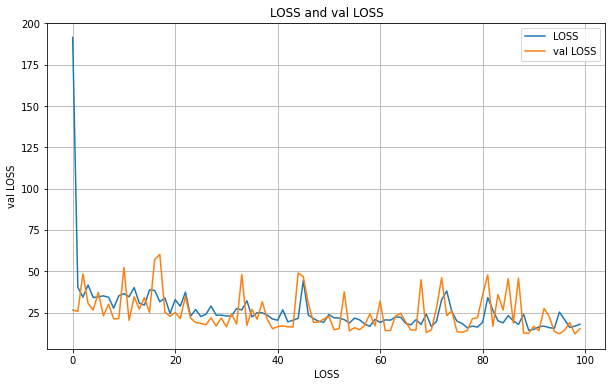

7/7 [==============================] - 0s 10ms/step


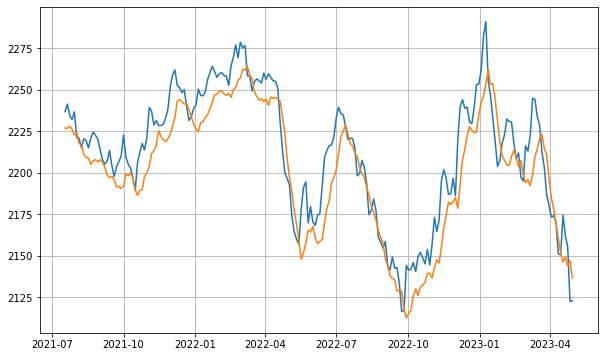

{'mae': 14.643979, 'mse': 321.45572, 'rmse': 17.929186, 'mape': 0.66090965, 'mase': 1.9727017}
Model: "1_model_CAD"


<ipython-input-2-5c4b28aa2962>:6: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = pd.read_csv('./currency_data_10_years.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2688      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,057
Trainable params: 13,057
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
     20/Unknown - 1s 3ms/step - loss: 1320.7032 - mae: 1319.7180

INFO:tensorflow:Assets written to: saved_model/18\assets


INFO:tensorflow:Assets written to: saved_model/18\assets


31/31 [==============================] - 3s 48ms/step - loss: 938.5983 - mae: 937.6812 - val_loss: 116.4772 - val_mae: 115.7557
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 175.7897 - mae: 175.2023 - val_loss: 117.5117 - val_mae: 117.0464
Epoch 3/100
16/31 [==============>...............] - ETA: 0s - loss: 163.4421 - mae: 163.0201

INFO:tensorflow:Assets written to: saved_model/18\assets


INFO:tensorflow:Assets written to: saved_model/18\assets


31/31 [==============================] - 1s 39ms/step - loss: 166.8614 - mae: 166.4743 - val_loss: 104.0186 - val_mae: 103.7026
Epoch 4/100
22/31 [====================>.........] - ETA: 0s - loss: 177.4563 - mae: 177.1729

INFO:tensorflow:Assets written to: saved_model/18\assets


INFO:tensorflow:Assets written to: saved_model/18\assets


31/31 [==============================] - 1s 38ms/step - loss: 170.5995 - mae: 170.3278 - val_loss: 97.4603 - val_mae: 97.2296
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 150.5078 - mae: 150.3036 - val_loss: 248.4545 - val_mae: 248.2741
Epoch 6/100
22/31 [====================>.........] - ETA: 0s - loss: 149.9090 - mae: 149.7374

INFO:tensorflow:Assets written to: saved_model/18\assets


INFO:tensorflow:Assets written to: saved_model/18\assets


31/31 [==============================] - 2s 48ms/step - loss: 147.5963 - mae: 147.4291 - val_loss: 95.0848 - val_mae: 94.9325
Epoch 7/100
31/31 [==============================] - 0s 7ms/step - loss: 177.0613 - mae: 176.9167 - val_loss: 216.2741 - val_mae: 216.1377
Epoch 8/100
19/31 [=================>............] - ETA: 0s - loss: 146.4697 - mae: 146.3359

INFO:tensorflow:Assets written to: saved_model/18\assets


INFO:tensorflow:Assets written to: saved_model/18\assets


31/31 [==============================] - 2s 44ms/step - loss: 138.8480 - mae: 138.7156 - val_loss: 89.5559 - val_mae: 89.4262
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 149.1702 - mae: 149.0442 - val_loss: 154.0336 - val_mae: 153.9108
Epoch 10/100
31/31 [==============================] - 0s 5ms/step - loss: 162.1022 - mae: 161.9794 - val_loss: 108.2225 - val_mae: 108.1026
Epoch 11/100
31/31 [==============================] - 0s 4ms/step - loss: 162.6336 - mae: 162.5125 - val_loss: 221.8320 - val_mae: 221.7140
Epoch 12/100
31/31 [==============================] - 0s 5ms/step - loss: 169.9575 - mae: 169.8398 - val_loss: 207.9958 - val_mae: 207.8791
Epoch 13/100
31/31 [==============================] - 0s 4ms/step - loss: 172.9753 - mae: 172.8577 - val_loss: 234.7058 - val_mae: 234.5900
Epoch 14/100
31/31 [==============================] - 0s 5ms/step - loss: 210.9578 - mae: 210.8421 - val_loss: 134.3162 - val_mae: 134.2006
Epoch 15/100
31/31 [===============

INFO:tensorflow:Assets written to: saved_model/18\assets


INFO:tensorflow:Assets written to: saved_model/18\assets


31/31 [==============================] - 1s 38ms/step - loss: 133.1049 - mae: 132.9928 - val_loss: 82.3507 - val_mae: 82.2375
Epoch 26/100
31/31 [==============================] - 0s 5ms/step - loss: 118.1692 - mae: 118.0570 - val_loss: 111.5335 - val_mae: 111.4217
Epoch 27/100
31/31 [==============================] - 0s 4ms/step - loss: 114.3811 - mae: 114.2693 - val_loss: 192.5438 - val_mae: 192.4320
Epoch 28/100
31/31 [==============================] - 0s 5ms/step - loss: 141.8580 - mae: 141.7461 - val_loss: 179.2680 - val_mae: 179.1566
Epoch 29/100
31/31 [==============================] - 0s 5ms/step - loss: 168.4747 - mae: 168.3635 - val_loss: 295.4347 - val_mae: 295.3238
Epoch 30/100
31/31 [==============================] - 0s 5ms/step - loss: 149.8559 - mae: 149.7452 - val_loss: 205.9789 - val_mae: 205.8687
Epoch 31/100
31/31 [==============================] - 0s 4ms/step - loss: 134.6171 - mae: 134.5068 - val_loss: 103.8461 - val_mae: 103.7356
Epoch 32/100
31/31 [==============

INFO:tensorflow:Assets written to: saved_model/18\assets


INFO:tensorflow:Assets written to: saved_model/18\assets


31/31 [==============================] - 1s 38ms/step - loss: 124.8226 - mae: 124.7113 - val_loss: 71.4507 - val_mae: 71.3403
Epoch 34/100
31/31 [==============================] - 0s 5ms/step - loss: 124.5004 - mae: 124.3892 - val_loss: 129.0073 - val_mae: 128.8967
Epoch 35/100
31/31 [==============================] - 0s 4ms/step - loss: 123.2428 - mae: 123.1316 - val_loss: 206.3250 - val_mae: 206.2140
Epoch 36/100
31/31 [==============================] - 0s 4ms/step - loss: 122.7670 - mae: 122.6550 - val_loss: 85.2113 - val_mae: 85.0993
Epoch 37/100
31/31 [==============================] - 0s 5ms/step - loss: 121.4400 - mae: 121.3266 - val_loss: 72.6743 - val_mae: 72.5586
Epoch 38/100
31/31 [==============================] - 0s 5ms/step - loss: 113.6770 - mae: 113.5622 - val_loss: 91.7798 - val_mae: 91.6667
Epoch 39/100
31/31 [==============================] - 0s 5ms/step - loss: 112.2172 - mae: 112.1035 - val_loss: 84.6663 - val_mae: 84.5524
Epoch 40/100
31/31 [======================

INFO:tensorflow:Assets written to: saved_model/18\assets


INFO:tensorflow:Assets written to: saved_model/18\assets


31/31 [==============================] - 1s 38ms/step - loss: 145.5699 - mae: 145.4524 - val_loss: 68.7734 - val_mae: 68.6528
Epoch 48/100
31/31 [==============================] - 0s 4ms/step - loss: 98.8848 - mae: 98.7662 - val_loss: 275.2774 - val_mae: 275.1599
Epoch 49/100
31/31 [==============================] - 0s 5ms/step - loss: 193.7995 - mae: 193.6824 - val_loss: 285.6741 - val_mae: 285.5570
Epoch 50/100
31/31 [==============================] - 1s 8ms/step - loss: 122.3498 - mae: 122.2329 - val_loss: 115.0799 - val_mae: 114.9622
Epoch 51/100
31/31 [==============================] - 0s 5ms/step - loss: 140.4146 - mae: 140.2982 - val_loss: 102.2028 - val_mae: 102.0854
Epoch 52/100
31/31 [==============================] - 0s 5ms/step - loss: 101.4771 - mae: 101.3605 - val_loss: 74.1822 - val_mae: 74.0660
Epoch 53/100
31/31 [==============================] - 0s 6ms/step - loss: 134.5748 - mae: 134.4579 - val_loss: 103.0949 - val_mae: 102.9777
Epoch 54/100
31/31 [==================

INFO:tensorflow:Assets written to: saved_model/18\assets


INFO:tensorflow:Assets written to: saved_model/18\assets


31/31 [==============================] - 1s 40ms/step - loss: 123.5089 - mae: 123.3940 - val_loss: 65.1825 - val_mae: 65.0684
Epoch 61/100
31/31 [==============================] - 0s 5ms/step - loss: 107.5691 - mae: 107.4544 - val_loss: 66.7553 - val_mae: 66.6396
Epoch 62/100
31/31 [==============================] - 0s 6ms/step - loss: 119.3298 - mae: 119.2154 - val_loss: 425.1966 - val_mae: 425.0829
Epoch 63/100
31/31 [==============================] - 0s 5ms/step - loss: 149.2251 - mae: 149.1102 - val_loss: 71.9389 - val_mae: 71.8254
Epoch 64/100
31/31 [==============================] - 0s 5ms/step - loss: 144.4326 - mae: 144.3184 - val_loss: 140.5715 - val_mae: 140.4584
Epoch 65/100
31/31 [==============================] - 0s 5ms/step - loss: 179.5276 - mae: 179.4137 - val_loss: 80.1558 - val_mae: 80.0399
Epoch 66/100
31/31 [==============================] - 0s 6ms/step - loss: 95.5449 - mae: 95.4320 - val_loss: 67.6389 - val_mae: 67.5250
Epoch 67/100
31/31 [========================

INFO:tensorflow:Assets written to: saved_model/18\assets


INFO:tensorflow:Assets written to: saved_model/18\assets


31/31 [==============================] - 1s 38ms/step - loss: 111.9611 - mae: 111.8526 - val_loss: 63.6838 - val_mae: 63.5760
Epoch 80/100
31/31 [==============================] - 0s 5ms/step - loss: 102.6814 - mae: 102.5733 - val_loss: 93.2656 - val_mae: 93.1564
Epoch 81/100
31/31 [==============================] - 0s 4ms/step - loss: 93.0992 - mae: 92.9904 - val_loss: 65.6775 - val_mae: 65.5655
Epoch 82/100
31/31 [==============================] - 0s 5ms/step - loss: 83.7181 - mae: 83.6100 - val_loss: 95.0664 - val_mae: 94.9586
Epoch 83/100
23/31 [=====================>........] - ETA: 0s - loss: 106.2292 - mae: 106.1211

INFO:tensorflow:Assets written to: saved_model/18\assets


INFO:tensorflow:Assets written to: saved_model/18\assets


31/31 [==============================] - 2s 46ms/step - loss: 102.3662 - mae: 102.2582 - val_loss: 60.9596 - val_mae: 60.8500
Epoch 84/100
23/31 [=====================>........] - ETA: 0s - loss: 91.0201 - mae: 90.9131

INFO:tensorflow:Assets written to: saved_model/18\assets


INFO:tensorflow:Assets written to: saved_model/18\assets


31/31 [==============================] - 1s 38ms/step - loss: 93.4879 - mae: 93.3809 - val_loss: 60.5845 - val_mae: 60.4746
Epoch 85/100
31/31 [==============================] - 0s 5ms/step - loss: 82.7841 - mae: 82.6772 - val_loss: 62.5119 - val_mae: 62.4048
Epoch 86/100
31/31 [==============================] - 0s 6ms/step - loss: 80.2760 - mae: 80.1678 - val_loss: 129.5503 - val_mae: 129.4434
Epoch 87/100
31/31 [==============================] - 0s 5ms/step - loss: 89.4884 - mae: 89.3808 - val_loss: 97.8996 - val_mae: 97.7937
Epoch 88/100
31/31 [==============================] - 0s 5ms/step - loss: 106.7662 - mae: 106.6598 - val_loss: 81.5909 - val_mae: 81.4856
Epoch 89/100
31/31 [==============================] - 0s 5ms/step - loss: 86.5325 - mae: 86.4257 - val_loss: 61.4969 - val_mae: 61.3920
Epoch 90/100
31/31 [==============================] - 0s 5ms/step - loss: 130.7232 - mae: 130.6184 - val_loss: 126.0024 - val_mae: 125.8958
Epoch 91/100
31/31 [==============================] 

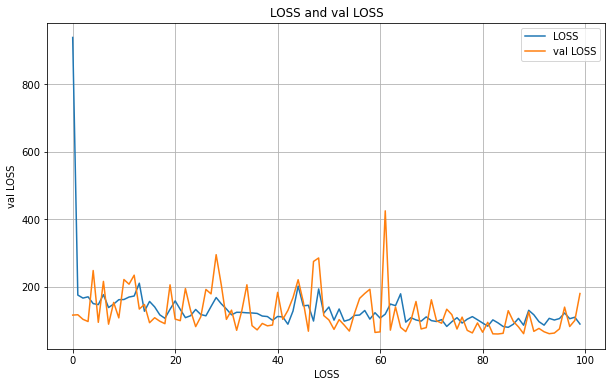

7/7 [==============================] - 0s 11ms/step


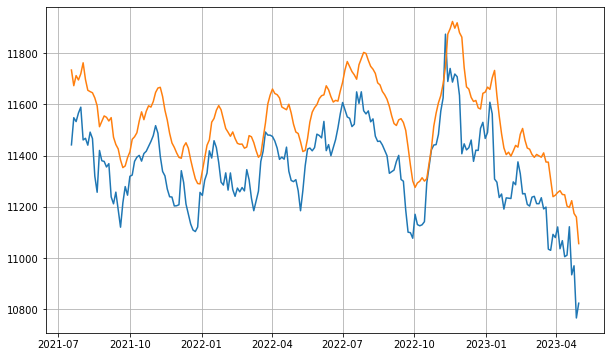

{'mae': 182.59077, 'mse': 38881.832, 'rmse': 197.18477, 'mape': 1.6124388, 'mase': 3.8425694}


<ipython-input-2-5c4b28aa2962>:6: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = pd.read_csv('./currency_data_10_years.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


Model: "1_model_MYR"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2688      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,057
Trainable params: 13,057
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
     30/Unknown - 2s 4ms/step - loss: 924.0857 - mae: 923.1819  

INFO:tensorflow:Assets written to: saved_model/19\assets


INFO:tensorflow:Assets written to: saved_model/19\assets


31/31 [==============================] - 3s 54ms/step - loss: 909.3437 - mae: 908.4442 - val_loss: 177.5312 - val_mae: 176.8427
Epoch 2/100
23/31 [=====================>........] - ETA: 0s - loss: 82.1613 - mae: 81.5801  

INFO:tensorflow:Assets written to: saved_model/19\assets


INFO:tensorflow:Assets written to: saved_model/19\assets


31/31 [==============================] - 1s 41ms/step - loss: 77.3564 - mae: 76.8057 - val_loss: 38.4904 - val_mae: 38.0615
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 59.9427 - mae: 59.6028 - val_loss: 52.0767 - val_mae: 51.8128
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 55.2982 - mae: 55.0826 - val_loss: 45.3593 - val_mae: 45.1897
Epoch 5/100
20/31 [==================>...........] - ETA: 0s - loss: 61.0732 - mae: 60.9192

INFO:tensorflow:Assets written to: saved_model/19\assets


INFO:tensorflow:Assets written to: saved_model/19\assets


31/31 [==============================] - 2s 45ms/step - loss: 57.6931 - mae: 57.5482 - val_loss: 34.8054 - val_mae: 34.6846
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 55.3134 - mae: 55.2093 - val_loss: 41.1470 - val_mae: 41.0573
Epoch 7/100
31/31 [==============================] - 1s 9ms/step - loss: 57.5328 - mae: 57.4529 - val_loss: 41.9839 - val_mae: 41.9117
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 62.5792 - mae: 62.5116 - val_loss: 57.7220 - val_mae: 57.6591
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 52.4165 - mae: 52.3548 - val_loss: 36.1989 - val_mae: 36.1413
Epoch 10/100
28/31 [==========================>...] - ETA: 0s - loss: 48.2612 - mae: 48.2045

INFO:tensorflow:Assets written to: saved_model/19\assets


INFO:tensorflow:Assets written to: saved_model/19\assets


31/31 [==============================] - 2s 56ms/step - loss: 47.8073 - mae: 47.7509 - val_loss: 32.3768 - val_mae: 32.3173
Epoch 11/100
20/31 [==================>...........] - ETA: 0s - loss: 45.6429 - mae: 45.5858

INFO:tensorflow:Assets written to: saved_model/19\assets


INFO:tensorflow:Assets written to: saved_model/19\assets


31/31 [==============================] - 1s 39ms/step - loss: 45.7231 - mae: 45.6674 - val_loss: 31.0068 - val_mae: 30.9485
Epoch 12/100
24/31 [======================>.......] - ETA: 0s - loss: 46.1769 - mae: 46.1243

INFO:tensorflow:Assets written to: saved_model/19\assets


INFO:tensorflow:Assets written to: saved_model/19\assets


31/31 [==============================] - 1s 39ms/step - loss: 46.1500 - mae: 46.0979 - val_loss: 30.1011 - val_mae: 30.0452
Epoch 13/100
31/31 [==============================] - 0s 5ms/step - loss: 52.1638 - mae: 52.1134 - val_loss: 52.7524 - val_mae: 52.6979
Epoch 14/100
31/31 [==============================] - 0s 5ms/step - loss: 51.7901 - mae: 51.7402 - val_loss: 30.2837 - val_mae: 30.2232
Epoch 15/100
31/31 [==============================] - 0s 5ms/step - loss: 46.2620 - mae: 46.2112 - val_loss: 56.5627 - val_mae: 56.5154
Epoch 16/100
31/31 [==============================] - 0s 4ms/step - loss: 47.8779 - mae: 47.8286 - val_loss: 30.6208 - val_mae: 30.5717
Epoch 17/100
31/31 [==============================] - 0s 5ms/step - loss: 53.7843 - mae: 53.7357 - val_loss: 47.7518 - val_mae: 47.7054
Epoch 18/100
31/31 [==============================] - 0s 5ms/step - loss: 53.3365 - mae: 53.2886 - val_loss: 30.9343 - val_mae: 30.8844
Epoch 19/100
31/31 [==============================] - 0s 5ms

INFO:tensorflow:Assets written to: saved_model/19\assets


INFO:tensorflow:Assets written to: saved_model/19\assets


31/31 [==============================] - 1s 39ms/step - loss: 41.6278 - mae: 41.5821 - val_loss: 28.1694 - val_mae: 28.1242
Epoch 22/100
31/31 [==============================] - 0s 5ms/step - loss: 51.9047 - mae: 51.8586 - val_loss: 92.0935 - val_mae: 92.0494
Epoch 23/100
31/31 [==============================] - 0s 5ms/step - loss: 58.8121 - mae: 58.7657 - val_loss: 56.5929 - val_mae: 56.5499
Epoch 24/100
22/31 [====================>.........] - ETA: 0s - loss: 41.3083 - mae: 41.2633

INFO:tensorflow:Assets written to: saved_model/19\assets


INFO:tensorflow:Assets written to: saved_model/19\assets


31/31 [==============================] - 2s 50ms/step - loss: 41.3950 - mae: 41.3506 - val_loss: 27.4324 - val_mae: 27.3811
Epoch 25/100
31/31 [==============================] - 0s 5ms/step - loss: 37.8898 - mae: 37.8447 - val_loss: 35.1659 - val_mae: 35.1235
Epoch 26/100
31/31 [==============================] - 0s 5ms/step - loss: 45.7381 - mae: 45.6942 - val_loss: 48.7092 - val_mae: 48.6650
Epoch 27/100
22/31 [====================>.........] - ETA: 0s - loss: 46.7786 - mae: 46.7340

INFO:tensorflow:Assets written to: saved_model/19\assets


INFO:tensorflow:Assets written to: saved_model/19\assets


31/31 [==============================] - 1s 40ms/step - loss: 43.8977 - mae: 43.8524 - val_loss: 25.7550 - val_mae: 25.7136
Epoch 28/100
31/31 [==============================] - 0s 7ms/step - loss: 41.5531 - mae: 41.5085 - val_loss: 26.4676 - val_mae: 26.4257
Epoch 29/100
31/31 [==============================] - 0s 5ms/step - loss: 37.7037 - mae: 37.6594 - val_loss: 34.5728 - val_mae: 34.5314
Epoch 30/100
19/31 [=================>............] - ETA: 0s - loss: 40.5782 - mae: 40.5345

INFO:tensorflow:Assets written to: saved_model/19\assets


INFO:tensorflow:Assets written to: saved_model/19\assets


31/31 [==============================] - 2s 77ms/step - loss: 44.2692 - mae: 44.2261 - val_loss: 23.4967 - val_mae: 23.4517
Epoch 31/100
31/31 [==============================] - 0s 5ms/step - loss: 45.4792 - mae: 45.4350 - val_loss: 33.7250 - val_mae: 33.6847
Epoch 32/100
31/31 [==============================] - 0s 5ms/step - loss: 36.1326 - mae: 36.0891 - val_loss: 36.4140 - val_mae: 36.3727
Epoch 33/100
31/31 [==============================] - 0s 5ms/step - loss: 43.9591 - mae: 43.9165 - val_loss: 48.2814 - val_mae: 48.2406
Epoch 34/100
31/31 [==============================] - 0s 5ms/step - loss: 33.3331 - mae: 33.2897 - val_loss: 36.5889 - val_mae: 36.5492
Epoch 35/100
31/31 [==============================] - 0s 5ms/step - loss: 36.5689 - mae: 36.5271 - val_loss: 51.8092 - val_mae: 51.7692
Epoch 36/100
31/31 [==============================] - 0s 5ms/step - loss: 40.6316 - mae: 40.5899 - val_loss: 38.3223 - val_mae: 38.2798
Epoch 37/100
31/31 [==============================] - 0s 5ms

INFO:tensorflow:Assets written to: saved_model/19\assets


INFO:tensorflow:Assets written to: saved_model/19\assets


31/31 [==============================] - 1s 39ms/step - loss: 40.1677 - mae: 40.1253 - val_loss: 21.9725 - val_mae: 21.9300
Epoch 40/100
31/31 [==============================] - 0s 5ms/step - loss: 41.7259 - mae: 41.6827 - val_loss: 28.7811 - val_mae: 28.7395
Epoch 41/100
31/31 [==============================] - 0s 5ms/step - loss: 45.6583 - mae: 45.6156 - val_loss: 62.7190 - val_mae: 62.6785
Epoch 42/100
31/31 [==============================] - 0s 5ms/step - loss: 43.3084 - mae: 43.2670 - val_loss: 32.3632 - val_mae: 32.3211
Epoch 43/100
31/31 [==============================] - 0s 5ms/step - loss: 35.9943 - mae: 35.9508 - val_loss: 25.2626 - val_mae: 25.2175
Epoch 44/100
31/31 [==============================] - 0s 5ms/step - loss: 47.2295 - mae: 47.1871 - val_loss: 26.1483 - val_mae: 26.1068
Epoch 45/100
31/31 [==============================] - 0s 5ms/step - loss: 48.7932 - mae: 48.7524 - val_loss: 53.2580 - val_mae: 53.2193
Epoch 46/100
31/31 [==============================] - 0s 5ms

INFO:tensorflow:Assets written to: saved_model/19\assets


INFO:tensorflow:Assets written to: saved_model/19\assets


31/31 [==============================] - 1s 39ms/step - loss: 37.5864 - mae: 37.5417 - val_loss: 20.4774 - val_mae: 20.4344
Epoch 49/100
31/31 [==============================] - 0s 5ms/step - loss: 32.0087 - mae: 31.9614 - val_loss: 33.8512 - val_mae: 33.8066
Epoch 50/100
31/31 [==============================] - 0s 5ms/step - loss: 32.2056 - mae: 32.1622 - val_loss: 51.8706 - val_mae: 51.8301
Epoch 51/100
31/31 [==============================] - 0s 5ms/step - loss: 41.7555 - mae: 41.7139 - val_loss: 36.6915 - val_mae: 36.6510
Epoch 52/100
31/31 [==============================] - 0s 5ms/step - loss: 34.2728 - mae: 34.2314 - val_loss: 26.1705 - val_mae: 26.1255
Epoch 53/100
31/31 [==============================] - 0s 5ms/step - loss: 31.6527 - mae: 31.6075 - val_loss: 29.0152 - val_mae: 28.9755
Epoch 54/100
31/31 [==============================] - 0s 5ms/step - loss: 35.1568 - mae: 35.1142 - val_loss: 20.5264 - val_mae: 20.4799
Epoch 55/100
31/31 [==============================] - 0s 5ms

INFO:tensorflow:Assets written to: saved_model/19\assets


INFO:tensorflow:Assets written to: saved_model/19\assets


31/31 [==============================] - 1s 38ms/step - loss: 34.8738 - mae: 34.8349 - val_loss: 20.3303 - val_mae: 20.2878
Epoch 60/100
31/31 [==============================] - 0s 5ms/step - loss: 31.2190 - mae: 31.1776 - val_loss: 28.8788 - val_mae: 28.8393
Epoch 61/100
31/31 [==============================] - 0s 5ms/step - loss: 38.1305 - mae: 38.0900 - val_loss: 42.8721 - val_mae: 42.8347
Epoch 62/100
21/31 [===================>..........] - ETA: 0s - loss: 38.2583 - mae: 38.2199

INFO:tensorflow:Assets written to: saved_model/19\assets


INFO:tensorflow:Assets written to: saved_model/19\assets


31/31 [==============================] - 1s 39ms/step - loss: 36.6659 - mae: 36.6265 - val_loss: 18.7648 - val_mae: 18.7187
Epoch 63/100
31/31 [==============================] - 0s 4ms/step - loss: 32.5394 - mae: 32.5023 - val_loss: 43.9826 - val_mae: 43.9464
Epoch 64/100
31/31 [==============================] - 0s 5ms/step - loss: 45.4382 - mae: 45.4019 - val_loss: 38.2720 - val_mae: 38.2348
Epoch 65/100
31/31 [==============================] - 0s 5ms/step - loss: 29.4759 - mae: 29.4359 - val_loss: 19.2429 - val_mae: 19.1956
Epoch 66/100
31/31 [==============================] - 0s 5ms/step - loss: 37.5524 - mae: 37.5165 - val_loss: 43.0904 - val_mae: 43.0543
Epoch 67/100
31/31 [==============================] - 0s 5ms/step - loss: 30.9194 - mae: 30.8825 - val_loss: 20.1704 - val_mae: 20.1319
Epoch 68/100
23/31 [=====================>........] - ETA: 0s - loss: 30.4192 - mae: 30.3833

INFO:tensorflow:Assets written to: saved_model/19\assets


INFO:tensorflow:Assets written to: saved_model/19\assets


31/31 [==============================] - 1s 39ms/step - loss: 30.2698 - mae: 30.2335 - val_loss: 18.7173 - val_mae: 18.6785
Epoch 69/100
31/31 [==============================] - 0s 5ms/step - loss: 32.1598 - mae: 32.1242 - val_loss: 28.5413 - val_mae: 28.5075
Epoch 70/100
31/31 [==============================] - 0s 4ms/step - loss: 65.3134 - mae: 65.2809 - val_loss: 48.8412 - val_mae: 48.8075
Epoch 71/100
31/31 [==============================] - 0s 5ms/step - loss: 39.2112 - mae: 39.1789 - val_loss: 48.9916 - val_mae: 48.9597
Epoch 72/100
31/31 [==============================] - 0s 5ms/step - loss: 40.7870 - mae: 40.7541 - val_loss: 76.4269 - val_mae: 76.3965
Epoch 73/100
31/31 [==============================] - 0s 5ms/step - loss: 53.8235 - mae: 53.7919 - val_loss: 22.2892 - val_mae: 22.2565
Epoch 74/100
31/31 [==============================] - 0s 5ms/step - loss: 31.2968 - mae: 31.2645 - val_loss: 28.3283 - val_mae: 28.2922
Epoch 75/100
31/31 [==============================] - 0s 5ms

INFO:tensorflow:Assets written to: saved_model/19\assets


INFO:tensorflow:Assets written to: saved_model/19\assets


31/31 [==============================] - 1s 38ms/step - loss: 30.9860 - mae: 30.9571 - val_loss: 17.8734 - val_mae: 17.8431
Epoch 87/100
31/31 [==============================] - 0s 5ms/step - loss: 29.8369 - mae: 29.8074 - val_loss: 23.4755 - val_mae: 23.4501
Epoch 88/100
31/31 [==============================] - 0s 4ms/step - loss: 30.6117 - mae: 30.5815 - val_loss: 36.0860 - val_mae: 36.0618
Epoch 89/100
31/31 [==============================] - 0s 4ms/step - loss: 30.6025 - mae: 30.5728 - val_loss: 34.9181 - val_mae: 34.8922
Epoch 90/100
31/31 [==============================] - 0s 4ms/step - loss: 32.5478 - mae: 32.5218 - val_loss: 18.0711 - val_mae: 18.0427
Epoch 91/100
31/31 [==============================] - 0s 4ms/step - loss: 31.7663 - mae: 31.7390 - val_loss: 61.3915 - val_mae: 61.3684
Epoch 92/100
31/31 [==============================] - 0s 4ms/step - loss: 52.7950 - mae: 52.7718 - val_loss: 27.8252 - val_mae: 27.8029
Epoch 93/100
31/31 [==============================] - 0s 5ms

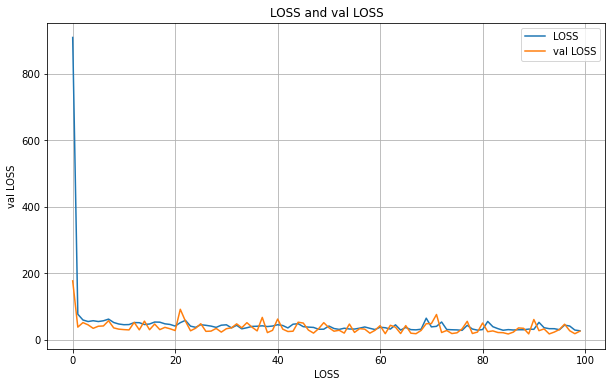

7/7 [==============================] - 0s 9ms/step


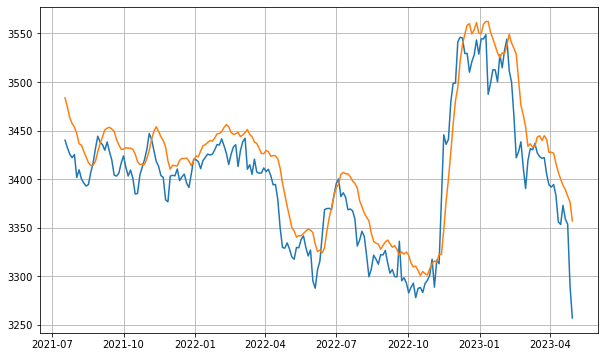

{'mae': 26.192617, 'mse': 1027.6882, 'rmse': 32.057575, 'mape': 0.7721124, 'mase': 2.309118}
Model: "1_model_RUB"


<ipython-input-2-5c4b28aa2962>:6: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = pd.read_csv('./currency_data_10_years.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2688      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,057
Trainable params: 13,057
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
     23/Unknown - 1s 2ms/step - loss: 66.8303 - mae: 65.8335 

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


31/31 [==============================] - 3s 46ms/step - loss: 52.9860 - mae: 52.0301 - val_loss: 19.1533 - val_mae: 18.3751
Epoch 2/100
24/31 [======================>.......] - ETA: 0s - loss: 9.2560 - mae: 8.5568 

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


31/31 [==============================] - 1s 39ms/step - loss: 8.7256 - mae: 8.0493 - val_loss: 13.7055 - val_mae: 13.1444
Epoch 3/100
24/31 [======================>.......] - ETA: 0s - loss: 7.6326 - mae: 7.1168

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


31/31 [==============================] - 1s 38ms/step - loss: 7.4312 - mae: 6.9290 - val_loss: 13.2782 - val_mae: 12.8476
Epoch 4/100
24/31 [======================>.......] - ETA: 0s - loss: 6.6845 - mae: 6.2725

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


31/31 [==============================] - 1s 38ms/step - loss: 6.5261 - mae: 6.1235 - val_loss: 12.5494 - val_mae: 12.1896
Epoch 5/100
24/31 [======================>.......] - ETA: 0s - loss: 6.2322 - mae: 5.8945

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


31/31 [==============================] - 1s 44ms/step - loss: 6.1119 - mae: 5.7771 - val_loss: 11.2389 - val_mae: 10.9337
Epoch 6/100
24/31 [======================>.......] - ETA: 0s - loss: 5.9493 - mae: 5.6459

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


31/31 [==============================] - 1s 37ms/step - loss: 6.1170 - mae: 5.8186 - val_loss: 10.9532 - val_mae: 10.6660
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 5.9768 - mae: 5.7021 - val_loss: 11.6985 - val_mae: 11.4462
Epoch 8/100
25/31 [=======================>......] - ETA: 0s - loss: 6.2299 - mae: 5.9697

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


31/31 [==============================] - 1s 37ms/step - loss: 6.1817 - mae: 5.9236 - val_loss: 9.6788 - val_mae: 9.4233
Epoch 9/100
25/31 [=======================>......] - ETA: 0s - loss: 4.7913 - mae: 4.5318

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


31/31 [==============================] - 1s 38ms/step - loss: 4.6906 - mae: 4.4299 - val_loss: 9.1412 - val_mae: 8.8887
Epoch 10/100
31/31 [==============================] - 0s 4ms/step - loss: 5.5521 - mae: 5.3061 - val_loss: 9.3438 - val_mae: 9.1099
Epoch 11/100
31/31 [==============================] - 0s 4ms/step - loss: 7.6555 - mae: 7.4202 - val_loss: 10.3884 - val_mae: 10.1593
Epoch 12/100
31/31 [==============================] - 0s 4ms/step - loss: 5.4439 - mae: 5.2087 - val_loss: 9.8880 - val_mae: 9.6569
Epoch 13/100
31/31 [==============================] - 0s 4ms/step - loss: 4.9416 - mae: 4.7026 - val_loss: 9.9284 - val_mae: 9.7013
Epoch 14/100
31/31 [==============================] - 0s 4ms/step - loss: 4.0390 - mae: 3.7936 - val_loss: 9.2152 - val_mae: 8.9842
Epoch 15/100
31/31 [==============================] - 0s 4ms/step - loss: 4.0628 - mae: 3.8199 - val_loss: 9.2912 - val_mae: 9.0678
Epoch 16/100
31/31 [==============================] - 0s 4ms/step - loss: 5.4257 - mae

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


31/31 [==============================] - 1s 37ms/step - loss: 3.6363 - mae: 3.3921 - val_loss: 8.7485 - val_mae: 8.5173
Epoch 18/100
25/31 [=======================>......] - ETA: 0s - loss: 3.5965 - mae: 3.3554

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


31/31 [==============================] - 1s 38ms/step - loss: 3.6460 - mae: 3.4068 - val_loss: 8.6703 - val_mae: 8.4461
Epoch 19/100
31/31 [==============================] - 0s 4ms/step - loss: 3.9160 - mae: 3.6859 - val_loss: 8.6794 - val_mae: 8.4610
Epoch 20/100
24/31 [======================>.......] - ETA: 0s - loss: 4.1381 - mae: 3.9111

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


31/31 [==============================] - 1s 38ms/step - loss: 4.0144 - mae: 3.7861 - val_loss: 8.5125 - val_mae: 8.2925
Epoch 21/100
31/31 [==============================] - 0s 4ms/step - loss: 3.6597 - mae: 3.4285 - val_loss: 9.6913 - val_mae: 9.4854
Epoch 22/100
31/31 [==============================] - 0s 4ms/step - loss: 3.9529 - mae: 3.7330 - val_loss: 8.6444 - val_mae: 8.4304
Epoch 23/100
31/31 [==============================] - 0s 4ms/step - loss: 3.6754 - mae: 3.4511 - val_loss: 9.5657 - val_mae: 9.3656
Epoch 24/100
31/31 [==============================] - 0s 4ms/step - loss: 4.1469 - mae: 3.9315 - val_loss: 8.8691 - val_mae: 8.6645
Epoch 25/100
31/31 [==============================] - 0s 4ms/step - loss: 3.6099 - mae: 3.3900 - val_loss: 9.5521 - val_mae: 9.3578
Epoch 26/100
25/31 [=======================>......] - ETA: 0s - loss: 3.6673 - mae: 3.4536

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


31/31 [==============================] - 1s 43ms/step - loss: 3.6402 - mae: 3.4245 - val_loss: 8.3231 - val_mae: 8.1188
Epoch 27/100
24/31 [======================>.......] - ETA: 0s - loss: 4.3302 - mae: 4.1209

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


31/31 [==============================] - 1s 37ms/step - loss: 4.0827 - mae: 3.8730 - val_loss: 8.2681 - val_mae: 8.0576
Epoch 28/100
31/31 [==============================] - 0s 4ms/step - loss: 3.9470 - mae: 3.7395 - val_loss: 8.8746 - val_mae: 8.6844
Epoch 29/100
25/31 [=======================>......] - ETA: 0s - loss: 3.4821 - mae: 3.2745

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


31/31 [==============================] - 1s 38ms/step - loss: 3.4547 - mae: 3.2446 - val_loss: 8.0818 - val_mae: 7.8696
Epoch 30/100
31/31 [==============================] - 0s 4ms/step - loss: 4.5583 - mae: 4.3665 - val_loss: 8.4082 - val_mae: 8.2084
Epoch 31/100
31/31 [==============================] - 0s 5ms/step - loss: 3.7748 - mae: 3.5682 - val_loss: 9.5295 - val_mae: 9.3495
Epoch 32/100
31/31 [==============================] - 0s 5ms/step - loss: 3.5040 - mae: 3.3020 - val_loss: 9.3431 - val_mae: 9.1619
Epoch 33/100
24/31 [======================>.......] - ETA: 0s - loss: 4.5401 - mae: 4.3448

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


31/31 [==============================] - 1s 36ms/step - loss: 4.2337 - mae: 4.0351 - val_loss: 8.0208 - val_mae: 7.8181
Epoch 34/100
31/31 [==============================] - 0s 4ms/step - loss: 3.7505 - mae: 3.5526 - val_loss: 8.4286 - val_mae: 8.2374
Epoch 35/100
31/31 [==============================] - 0s 4ms/step - loss: 4.0055 - mae: 3.8122 - val_loss: 9.6895 - val_mae: 9.5138
Epoch 36/100
31/31 [==============================] - 0s 4ms/step - loss: 3.7114 - mae: 3.5192 - val_loss: 8.2703 - val_mae: 8.0813
Epoch 37/100
31/31 [==============================] - 0s 4ms/step - loss: 3.6719 - mae: 3.4778 - val_loss: 8.1339 - val_mae: 7.9482
Epoch 38/100
24/31 [======================>.......] - ETA: 0s - loss: 3.1664 - mae: 2.9631

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


31/31 [==============================] - 1s 38ms/step - loss: 3.2151 - mae: 3.0127 - val_loss: 7.9899 - val_mae: 7.8102
Epoch 39/100
31/31 [==============================] - 0s 4ms/step - loss: 3.4244 - mae: 3.2329 - val_loss: 8.2537 - val_mae: 8.0785
Epoch 40/100
31/31 [==============================] - 0s 4ms/step - loss: 4.3428 - mae: 4.1670 - val_loss: 10.1626 - val_mae: 10.0030
Epoch 41/100
31/31 [==============================] - 0s 4ms/step - loss: 3.4210 - mae: 3.2361 - val_loss: 9.2458 - val_mae: 9.0898
Epoch 42/100
31/31 [==============================] - 0s 4ms/step - loss: 3.5856 - mae: 3.3933 - val_loss: 8.1348 - val_mae: 7.9646
Epoch 43/100
31/31 [==============================] - 0s 4ms/step - loss: 3.5255 - mae: 3.3405 - val_loss: 8.5136 - val_mae: 8.3515
Epoch 44/100
31/31 [==============================] - 0s 4ms/step - loss: 3.2796 - mae: 3.0958 - val_loss: 8.2856 - val_mae: 8.1199
Epoch 45/100
24/31 [======================>.......] - ETA: 0s - loss: 3.2765 - mae: 3.

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


31/31 [==============================] - 1s 37ms/step - loss: 3.2792 - mae: 3.0968 - val_loss: 7.8802 - val_mae: 7.6983
Epoch 46/100
24/31 [======================>.......] - ETA: 0s - loss: 3.5826 - mae: 3.4040

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


31/31 [==============================] - 1s 44ms/step - loss: 3.5419 - mae: 3.3618 - val_loss: 7.7875 - val_mae: 7.6077
Epoch 47/100
31/31 [==============================] - 0s 4ms/step - loss: 3.4937 - mae: 3.3174 - val_loss: 8.7733 - val_mae: 8.6252
Epoch 48/100
31/31 [==============================] - 0s 4ms/step - loss: 4.2801 - mae: 4.1190 - val_loss: 7.8418 - val_mae: 7.6706
Epoch 49/100
22/31 [====================>.........] - ETA: 0s - loss: 3.4974 - mae: 3.3301

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


31/31 [==============================] - 1s 38ms/step - loss: 3.2963 - mae: 3.1252 - val_loss: 7.7447 - val_mae: 7.5776
Epoch 50/100
31/31 [==============================] - 0s 4ms/step - loss: 4.3525 - mae: 4.1836 - val_loss: 12.2017 - val_mae: 12.0657
Epoch 51/100
31/31 [==============================] - 0s 4ms/step - loss: 6.3020 - mae: 6.1508 - val_loss: 8.8133 - val_mae: 8.6692
Epoch 52/100
31/31 [==============================] - 0s 4ms/step - loss: 3.9435 - mae: 3.7804 - val_loss: 9.2809 - val_mae: 9.1400
Epoch 53/100
24/31 [======================>.......] - ETA: 0s - loss: 3.2816 - mae: 3.1108

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


31/31 [==============================] - 1s 37ms/step - loss: 3.2619 - mae: 3.0888 - val_loss: 7.6740 - val_mae: 7.5040
Epoch 54/100
31/31 [==============================] - 0s 4ms/step - loss: 3.1617 - mae: 2.9910 - val_loss: 7.6955 - val_mae: 7.5385
Epoch 55/100
31/31 [==============================] - 0s 4ms/step - loss: 3.2399 - mae: 3.0730 - val_loss: 8.4520 - val_mae: 8.3168
Epoch 56/100
24/31 [======================>.......] - ETA: 0s - loss: 3.5655 - mae: 3.4068

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


31/31 [==============================] - 1s 38ms/step - loss: 3.5882 - mae: 3.4273 - val_loss: 7.5981 - val_mae: 7.4430
Epoch 57/100
31/31 [==============================] - 0s 4ms/step - loss: 3.5207 - mae: 3.3644 - val_loss: 7.6110 - val_mae: 7.4553
Epoch 58/100
31/31 [==============================] - 0s 4ms/step - loss: 3.7377 - mae: 3.5816 - val_loss: 8.5475 - val_mae: 8.4110
Epoch 59/100
24/31 [======================>.......] - ETA: 0s - loss: 3.2890 - mae: 3.1267

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


31/31 [==============================] - 1s 37ms/step - loss: 3.2555 - mae: 3.0959 - val_loss: 7.5765 - val_mae: 7.4255
Epoch 60/100
31/31 [==============================] - 0s 4ms/step - loss: 4.9685 - mae: 4.8341 - val_loss: 7.8685 - val_mae: 7.7093
Epoch 61/100
31/31 [==============================] - 0s 4ms/step - loss: 3.1619 - mae: 3.0070 - val_loss: 8.4453 - val_mae: 8.3173
Epoch 62/100
31/31 [==============================] - 0s 4ms/step - loss: 3.5394 - mae: 3.3942 - val_loss: 9.6897 - val_mae: 9.5677
Epoch 63/100
31/31 [==============================] - 0s 4ms/step - loss: 5.6997 - mae: 5.5698 - val_loss: 7.9343 - val_mae: 7.7930
Epoch 64/100
31/31 [==============================] - 0s 4ms/step - loss: 3.5662 - mae: 3.4210 - val_loss: 10.6534 - val_mae: 10.5349
Epoch 65/100
31/31 [==============================] - 0s 4ms/step - loss: 4.0995 - mae: 3.9619 - val_loss: 7.6343 - val_mae: 7.4980
Epoch 66/100
31/31 [==============================] - 0s 4ms/step - loss: 3.5939 - mae

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


31/31 [==============================] - 1s 37ms/step - loss: 3.3315 - mae: 3.1940 - val_loss: 7.4940 - val_mae: 7.3615
Epoch 70/100
31/31 [==============================] - 0s 4ms/step - loss: 3.1589 - mae: 3.0217 - val_loss: 7.6359 - val_mae: 7.5084
Epoch 71/100
31/31 [==============================] - 0s 4ms/step - loss: 2.9348 - mae: 2.7933 - val_loss: 8.0143 - val_mae: 7.9000
Epoch 72/100
24/31 [======================>.......] - ETA: 0s - loss: 3.2039 - mae: 3.0634

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


31/31 [==============================] - 1s 45ms/step - loss: 3.1375 - mae: 2.9955 - val_loss: 7.4080 - val_mae: 7.2804
Epoch 73/100
31/31 [==============================] - 0s 4ms/step - loss: 3.0649 - mae: 2.9284 - val_loss: 7.4091 - val_mae: 7.2758
Epoch 74/100
31/31 [==============================] - 0s 4ms/step - loss: 3.0346 - mae: 2.8930 - val_loss: 7.7373 - val_mae: 7.6261
Epoch 75/100
31/31 [==============================] - 0s 4ms/step - loss: 3.5282 - mae: 3.4050 - val_loss: 7.4320 - val_mae: 7.3037
Epoch 76/100
31/31 [==============================] - 0s 4ms/step - loss: 4.2915 - mae: 4.1801 - val_loss: 7.6343 - val_mae: 7.5041
Epoch 77/100
24/31 [======================>.......] - ETA: 0s - loss: 2.9447 - mae: 2.8083

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


31/31 [==============================] - 1s 41ms/step - loss: 2.8624 - mae: 2.7251 - val_loss: 7.3280 - val_mae: 7.2054
Epoch 78/100
31/31 [==============================] - 0s 4ms/step - loss: 2.8408 - mae: 2.7074 - val_loss: 8.1039 - val_mae: 7.9984
Epoch 79/100
31/31 [==============================] - 0s 5ms/step - loss: 3.0460 - mae: 2.9244 - val_loss: 8.0309 - val_mae: 7.9347
Epoch 80/100
31/31 [==============================] - 0s 4ms/step - loss: 3.7420 - mae: 3.6348 - val_loss: 7.8242 - val_mae: 7.7210
Epoch 81/100
31/31 [==============================] - 0s 4ms/step - loss: 2.9905 - mae: 2.8716 - val_loss: 7.3557 - val_mae: 7.2412
Epoch 82/100
31/31 [==============================] - 0s 4ms/step - loss: 4.5834 - mae: 4.4812 - val_loss: 8.2831 - val_mae: 8.1829
Epoch 83/100
31/31 [==============================] - 0s 4ms/step - loss: 3.0156 - mae: 2.8919 - val_loss: 7.3788 - val_mae: 7.2658
Epoch 84/100
31/31 [==============================] - 0s 4ms/step - loss: 3.4590 - mae: 

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


31/31 [==============================] - 1s 37ms/step - loss: 2.8930 - mae: 2.7843 - val_loss: 7.2095 - val_mae: 7.1081
Epoch 93/100
31/31 [==============================] - 0s 4ms/step - loss: 2.7751 - mae: 2.6625 - val_loss: 7.4493 - val_mae: 7.3710
Epoch 94/100
31/31 [==============================] - 0s 4ms/step - loss: 2.6521 - mae: 2.5405 - val_loss: 7.2146 - val_mae: 7.1187
Epoch 95/100
31/31 [==============================] - 0s 4ms/step - loss: 3.2827 - mae: 3.1846 - val_loss: 7.3514 - val_mae: 7.2576
Epoch 96/100
31/31 [==============================] - 0s 4ms/step - loss: 2.9968 - mae: 2.9004 - val_loss: 7.2787 - val_mae: 7.1868
Epoch 97/100
31/31 [==============================] - 0s 5ms/step - loss: 2.9750 - mae: 2.8767 - val_loss: 7.7294 - val_mae: 7.6579
Epoch 98/100
31/31 [==============================] - 0s 5ms/step - loss: 2.9496 - mae: 2.8544 - val_loss: 7.2268 - val_mae: 7.1343
Epoch 99/100
31/31 [==============================] - 0s 4ms/step - loss: 2.8412 - mae: 

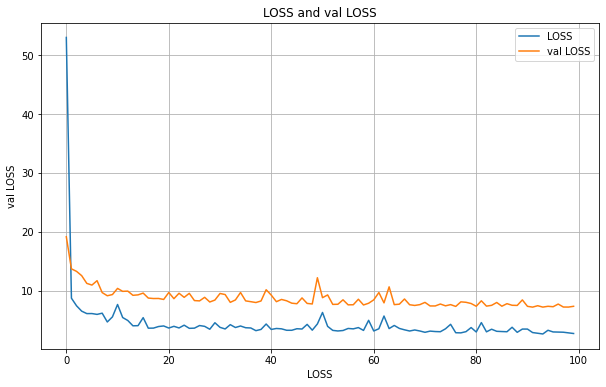

7/7 [==============================] - 0s 10ms/step


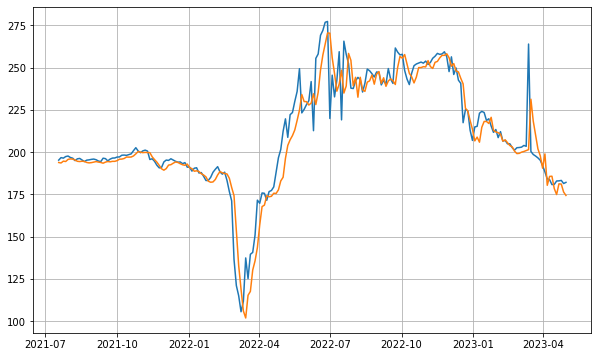

{'mae': 6.745857, 'mse': 127.11177, 'rmse': 11.274385, 'mape': 3.3450115, 'mase': 1.2464164}


In [8]:
count = 0
eval_models_1 = {}

for i in range(1,11):
    time, series, currency = open_file(i)

    split_time = 1000
    window_size = 20
    batch_size = 32
    shuffle_buffer_size = 1000

    train_set, valid_set = prepared_data(series, time, split_time, window_size, batch_size, shuffle_buffer_size)

    model = first_model(train_set, valid_set, window_size)
    evaluate_model(model, series, split_time, window_size, batch_size, count, eval_models_1, currency[count])
    
    count += 1

<ipython-input-2-5c4b28aa2962>:6: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = pd.read_csv('./currency_data_10_years.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


Model: "2_model_EUR"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               5376      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 48,641
Trainable params: 48,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
     19/Unknown - 1s 3ms/step - loss: 3

INFO:tensorflow:Assets written to: saved_model/21\assets


INFO:tensorflow:Assets written to: saved_model/21\assets


31/31 [==============================] - 3s 47ms/step - loss: 2132.5942 - mae: 2133.0942 - val_loss: 372.6602 - val_mae: 373.1602
Epoch 2/100
19/31 [=================>............] - ETA: 0s - loss: 438.4350 - mae: 438.9350

INFO:tensorflow:Assets written to: saved_model/21\assets


INFO:tensorflow:Assets written to: saved_model/21\assets


31/31 [==============================] - 1s 40ms/step - loss: 399.7536 - mae: 400.2536 - val_loss: 245.2262 - val_mae: 245.7255
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 320.7758 - mae: 321.2756 - val_loss: 270.7418 - val_mae: 271.2418
Epoch 4/100
19/31 [=================>............] - ETA: 0s - loss: 294.1802 - mae: 294.6802

INFO:tensorflow:Assets written to: saved_model/21\assets


INFO:tensorflow:Assets written to: saved_model/21\assets


31/31 [==============================] - 2s 45ms/step - loss: 313.8637 - mae: 314.3637 - val_loss: 217.1785 - val_mae: 217.6784
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 334.4953 - mae: 334.9953 - val_loss: 230.5304 - val_mae: 231.0304
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 333.9688 - mae: 334.4683 - val_loss: 407.8642 - val_mae: 408.3642
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 320.9867 - mae: 321.4860 - val_loss: 218.1069 - val_mae: 218.6069
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 397.4796 - mae: 397.9795 - val_loss: 458.8398 - val_mae: 459.3398
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 302.1783 - mae: 302.6780 - val_loss: 217.5056 - val_mae: 218.0056
Epoch 10/100
31/31 [==============================] - 0s 5ms/step - loss: 273.3882 - mae: 273.8868 - val_loss: 232.6352 - val_mae: 233.1352
Epoch 11/100
31/31 [=================

INFO:tensorflow:Assets written to: saved_model/21\assets


INFO:tensorflow:Assets written to: saved_model/21\assets


31/31 [==============================] - 1s 38ms/step - loss: 248.6082 - mae: 249.1076 - val_loss: 179.3433 - val_mae: 179.8420
Epoch 13/100
31/31 [==============================] - 0s 5ms/step - loss: 275.4799 - mae: 275.9799 - val_loss: 197.1899 - val_mae: 197.6896
Epoch 14/100
19/31 [=================>............] - ETA: 0s - loss: 284.0641 - mae: 284.5641

INFO:tensorflow:Assets written to: saved_model/21\assets


INFO:tensorflow:Assets written to: saved_model/21\assets


31/31 [==============================] - 1s 40ms/step - loss: 262.1500 - mae: 262.6496 - val_loss: 162.1140 - val_mae: 162.6140
Epoch 15/100
31/31 [==============================] - 0s 5ms/step - loss: 334.8248 - mae: 335.3246 - val_loss: 251.8857 - val_mae: 252.3857
Epoch 16/100
31/31 [==============================] - 0s 5ms/step - loss: 278.0951 - mae: 278.5950 - val_loss: 225.0849 - val_mae: 225.5830
Epoch 17/100
31/31 [==============================] - 0s 5ms/step - loss: 250.9671 - mae: 251.4669 - val_loss: 443.8543 - val_mae: 444.3543
Epoch 18/100
31/31 [==============================] - 0s 5ms/step - loss: 292.7638 - mae: 293.2637 - val_loss: 186.0355 - val_mae: 186.5355
Epoch 19/100
19/31 [=================>............] - ETA: 0s - loss: 260.4093 - mae: 260.9093

INFO:tensorflow:Assets written to: saved_model/21\assets


INFO:tensorflow:Assets written to: saved_model/21\assets


31/31 [==============================] - 1s 39ms/step - loss: 274.1719 - mae: 274.6719 - val_loss: 152.9701 - val_mae: 153.4700
Epoch 20/100
31/31 [==============================] - 0s 5ms/step - loss: 307.2672 - mae: 307.7668 - val_loss: 184.3701 - val_mae: 184.8696
Epoch 21/100
19/31 [=================>............] - ETA: 0s - loss: 208.5238 - mae: 209.0231

INFO:tensorflow:Assets written to: saved_model/21\assets


INFO:tensorflow:Assets written to: saved_model/21\assets


31/31 [==============================] - 1s 39ms/step - loss: 225.3396 - mae: 225.8389 - val_loss: 143.6787 - val_mae: 144.1787
Epoch 22/100
31/31 [==============================] - 0s 5ms/step - loss: 228.8733 - mae: 229.3729 - val_loss: 158.4450 - val_mae: 158.9439
Epoch 23/100
31/31 [==============================] - 0s 5ms/step - loss: 239.5570 - mae: 240.0569 - val_loss: 153.3440 - val_mae: 153.8433
Epoch 24/100
20/31 [==================>...........] - ETA: 0s - loss: 180.8175 - mae: 181.3168

INFO:tensorflow:Assets written to: saved_model/21\assets


INFO:tensorflow:Assets written to: saved_model/21\assets


31/31 [==============================] - 1s 40ms/step - loss: 183.2396 - mae: 183.7391 - val_loss: 137.3192 - val_mae: 137.8169
Epoch 25/100
19/31 [=================>............] - ETA: 0s - loss: 191.9983 - mae: 192.4977

INFO:tensorflow:Assets written to: saved_model/21\assets


INFO:tensorflow:Assets written to: saved_model/21\assets


31/31 [==============================] - 1s 45ms/step - loss: 196.0403 - mae: 196.5390 - val_loss: 130.0847 - val_mae: 130.5846
Epoch 26/100
31/31 [==============================] - 0s 5ms/step - loss: 212.3581 - mae: 212.8579 - val_loss: 346.8235 - val_mae: 347.3235
Epoch 27/100
31/31 [==============================] - 0s 5ms/step - loss: 203.2715 - mae: 203.7706 - val_loss: 139.8650 - val_mae: 140.3650
Epoch 28/100
31/31 [==============================] - 0s 5ms/step - loss: 208.3435 - mae: 208.8431 - val_loss: 186.8497 - val_mae: 187.3497
Epoch 29/100
31/31 [==============================] - 0s 5ms/step - loss: 223.1420 - mae: 223.6413 - val_loss: 295.1463 - val_mae: 295.6463
Epoch 30/100
19/31 [=================>............] - ETA: 0s - loss: 206.1600 - mae: 206.6598

INFO:tensorflow:Assets written to: saved_model/21\assets


INFO:tensorflow:Assets written to: saved_model/21\assets


31/31 [==============================] - 1s 38ms/step - loss: 201.2567 - mae: 201.7563 - val_loss: 124.4501 - val_mae: 124.9501
Epoch 31/100
31/31 [==============================] - 0s 5ms/step - loss: 237.9595 - mae: 238.4595 - val_loss: 278.5811 - val_mae: 279.0805
Epoch 32/100
19/31 [=================>............] - ETA: 0s - loss: 261.6655 - mae: 262.1655

INFO:tensorflow:Assets written to: saved_model/21\assets


INFO:tensorflow:Assets written to: saved_model/21\assets


31/31 [==============================] - 1s 39ms/step - loss: 261.4254 - mae: 261.9253 - val_loss: 121.6252 - val_mae: 122.1252
Epoch 33/100
31/31 [==============================] - 0s 5ms/step - loss: 200.4231 - mae: 200.9229 - val_loss: 129.2656 - val_mae: 129.7656
Epoch 34/100
31/31 [==============================] - 0s 5ms/step - loss: 170.3782 - mae: 170.8777 - val_loss: 169.4918 - val_mae: 169.9918
Epoch 35/100
31/31 [==============================] - 0s 5ms/step - loss: 193.2526 - mae: 193.7516 - val_loss: 161.0293 - val_mae: 161.5293
Epoch 36/100
19/31 [=================>............] - ETA: 0s - loss: 190.3057 - mae: 190.8057

INFO:tensorflow:Assets written to: saved_model/21\assets


INFO:tensorflow:Assets written to: saved_model/21\assets


31/31 [==============================] - 1s 39ms/step - loss: 188.0635 - mae: 188.5632 - val_loss: 117.5743 - val_mae: 118.0741
Epoch 37/100
31/31 [==============================] - 0s 5ms/step - loss: 183.3240 - mae: 183.8234 - val_loss: 227.5500 - val_mae: 228.0500
Epoch 38/100
31/31 [==============================] - 0s 5ms/step - loss: 198.9045 - mae: 199.4037 - val_loss: 193.0459 - val_mae: 193.5459
Epoch 39/100
19/31 [=================>............] - ETA: 0s - loss: 210.7832 - mae: 211.2823

INFO:tensorflow:Assets written to: saved_model/21\assets


INFO:tensorflow:Assets written to: saved_model/21\assets


31/31 [==============================] - 1s 39ms/step - loss: 216.7397 - mae: 217.2392 - val_loss: 113.9109 - val_mae: 114.4083
Epoch 40/100
31/31 [==============================] - 0s 5ms/step - loss: 203.3540 - mae: 203.8530 - val_loss: 213.9857 - val_mae: 214.4836
Epoch 41/100
31/31 [==============================] - 0s 5ms/step - loss: 222.0575 - mae: 222.5568 - val_loss: 128.6449 - val_mae: 129.1442
Epoch 42/100
31/31 [==============================] - 0s 5ms/step - loss: 167.3351 - mae: 167.8345 - val_loss: 173.5149 - val_mae: 174.0149
Epoch 43/100
31/31 [==============================] - 0s 5ms/step - loss: 176.2439 - mae: 176.7433 - val_loss: 300.6402 - val_mae: 301.1402
Epoch 44/100
19/31 [=================>............] - ETA: 0s - loss: 215.4818 - mae: 215.9813

INFO:tensorflow:Assets written to: saved_model/21\assets


INFO:tensorflow:Assets written to: saved_model/21\assets


31/31 [==============================] - 2s 46ms/step - loss: 236.8662 - mae: 237.3659 - val_loss: 113.6660 - val_mae: 114.1650
Epoch 45/100
31/31 [==============================] - 0s 5ms/step - loss: 159.0653 - mae: 159.5649 - val_loss: 202.2418 - val_mae: 202.7404
Epoch 46/100
31/31 [==============================] - 0s 5ms/step - loss: 175.4668 - mae: 175.9654 - val_loss: 145.9853 - val_mae: 146.4851
Epoch 47/100
31/31 [==============================] - 0s 5ms/step - loss: 190.9112 - mae: 191.4110 - val_loss: 232.9558 - val_mae: 233.4558
Epoch 48/100
31/31 [==============================] - 0s 6ms/step - loss: 229.4910 - mae: 229.9906 - val_loss: 143.5884 - val_mae: 144.0879
Epoch 49/100
31/31 [==============================] - 0s 5ms/step - loss: 180.2782 - mae: 180.7773 - val_loss: 140.4528 - val_mae: 140.9528
Epoch 50/100
31/31 [==============================] - 0s 5ms/step - loss: 215.9205 - mae: 216.4201 - val_loss: 345.9036 - val_mae: 346.4036
Epoch 51/100
31/31 [============

INFO:tensorflow:Assets written to: saved_model/21\assets


INFO:tensorflow:Assets written to: saved_model/21\assets


31/31 [==============================] - 1s 45ms/step - loss: 211.2037 - mae: 211.7033 - val_loss: 113.4432 - val_mae: 113.9432
Epoch 53/100
31/31 [==============================] - 0s 5ms/step - loss: 195.7288 - mae: 196.2283 - val_loss: 353.0488 - val_mae: 353.5488
Epoch 54/100
31/31 [==============================] - 0s 5ms/step - loss: 210.1219 - mae: 210.6210 - val_loss: 309.1780 - val_mae: 309.6780
Epoch 55/100
31/31 [==============================] - 0s 5ms/step - loss: 235.7184 - mae: 236.2178 - val_loss: 318.9771 - val_mae: 319.4771
Epoch 56/100
31/31 [==============================] - 0s 5ms/step - loss: 195.0242 - mae: 195.5238 - val_loss: 201.9608 - val_mae: 202.4608
Epoch 57/100
31/31 [==============================] - 0s 5ms/step - loss: 163.6334 - mae: 164.1326 - val_loss: 128.5211 - val_mae: 129.0192
Epoch 58/100
31/31 [==============================] - 0s 5ms/step - loss: 199.9883 - mae: 200.4882 - val_loss: 140.8545 - val_mae: 141.3545
Epoch 59/100
31/31 [============

INFO:tensorflow:Assets written to: saved_model/21\assets


INFO:tensorflow:Assets written to: saved_model/21\assets


31/31 [==============================] - 1s 38ms/step - loss: 188.4010 - mae: 188.9008 - val_loss: 105.3936 - val_mae: 105.8936
Epoch 65/100
31/31 [==============================] - 0s 5ms/step - loss: 167.3923 - mae: 167.8923 - val_loss: 264.8048 - val_mae: 265.3048
Epoch 66/100
31/31 [==============================] - 0s 5ms/step - loss: 199.1485 - mae: 199.6483 - val_loss: 127.8203 - val_mae: 128.3199
Epoch 67/100
31/31 [==============================] - 0s 5ms/step - loss: 189.8484 - mae: 190.3483 - val_loss: 345.2428 - val_mae: 345.7428
Epoch 68/100
31/31 [==============================] - 0s 5ms/step - loss: 170.2665 - mae: 170.7662 - val_loss: 224.7282 - val_mae: 225.2282
Epoch 69/100
31/31 [==============================] - 0s 5ms/step - loss: 159.7095 - mae: 160.2089 - val_loss: 220.9516 - val_mae: 221.4516
Epoch 70/100
31/31 [==============================] - 0s 5ms/step - loss: 159.1065 - mae: 159.6051 - val_loss: 121.6907 - val_mae: 122.1907
Epoch 71/100
31/31 [============

INFO:tensorflow:Assets written to: saved_model/21\assets


INFO:tensorflow:Assets written to: saved_model/21\assets


31/31 [==============================] - 1s 39ms/step - loss: 142.1541 - mae: 142.6537 - val_loss: 105.1470 - val_mae: 105.6451
Epoch 75/100
31/31 [==============================] - 0s 5ms/step - loss: 133.0965 - mae: 133.5961 - val_loss: 138.0833 - val_mae: 138.5833
Epoch 76/100
31/31 [==============================] - 0s 5ms/step - loss: 215.7520 - mae: 216.2517 - val_loss: 202.6419 - val_mae: 203.1419
Epoch 77/100
31/31 [==============================] - 0s 5ms/step - loss: 185.0794 - mae: 185.5791 - val_loss: 139.2000 - val_mae: 139.7000
Epoch 78/100
31/31 [==============================] - 0s 5ms/step - loss: 149.8725 - mae: 150.3725 - val_loss: 105.6303 - val_mae: 106.1299
Epoch 79/100
31/31 [==============================] - 0s 5ms/step - loss: 150.8679 - mae: 151.3670 - val_loss: 239.5771 - val_mae: 240.0771
Epoch 80/100
31/31 [==============================] - 0s 5ms/step - loss: 165.5732 - mae: 166.0727 - val_loss: 231.3895 - val_mae: 231.8895
Epoch 81/100
31/31 [============

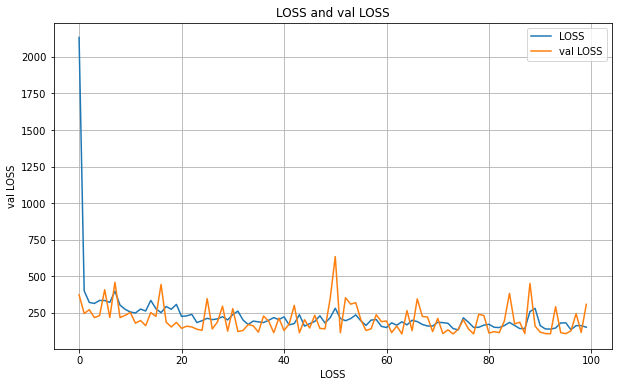

7/7 [==============================] - 0s 9ms/step


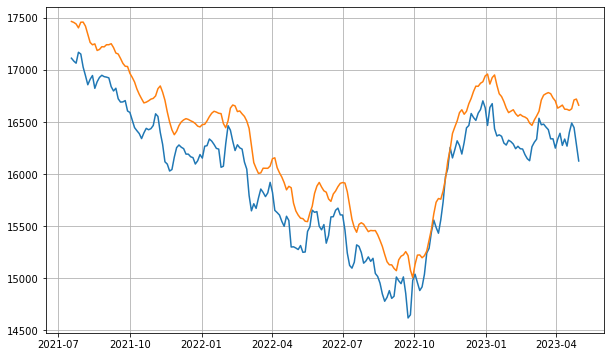

{'mae': 312.08652, 'mse': 112480.78, 'rmse': 335.38153, 'mape': 1.9520098, 'mase': 4.294391}
Model: "2_model_USD"


<ipython-input-2-5c4b28aa2962>:6: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = pd.read_csv('./currency_data_10_years.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               5376      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 48,641
Trainable params: 48,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
     19/Unknown - 1s 3ms/step - loss: 5561.3770 - mae: 5561.

INFO:tensorflow:Assets written to: saved_model/22\assets


INFO:tensorflow:Assets written to: saved_model/22\assets


31/31 [==============================] - 3s 48ms/step - loss: 3680.3635 - mae: 3680.8633 - val_loss: 325.3427 - val_mae: 325.8427
Epoch 2/100
18/31 [================>.............] - ETA: 0s - loss: 300.2604 - mae: 300.7592

INFO:tensorflow:Assets written to: saved_model/22\assets


INFO:tensorflow:Assets written to: saved_model/22\assets


31/31 [==============================] - 2s 49ms/step - loss: 280.0155 - mae: 280.5144 - val_loss: 197.2416 - val_mae: 197.7416
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 240.3206 - mae: 240.8191 - val_loss: 220.8051 - val_mae: 221.3050
Epoch 4/100
19/31 [=================>............] - ETA: 0s - loss: 253.0984 - mae: 253.5975

INFO:tensorflow:Assets written to: saved_model/22\assets


INFO:tensorflow:Assets written to: saved_model/22\assets


31/31 [==============================] - 1s 39ms/step - loss: 237.8142 - mae: 238.3136 - val_loss: 139.8949 - val_mae: 140.3918
Epoch 5/100
18/31 [================>.............] - ETA: 0s - loss: 208.5443 - mae: 209.0442

INFO:tensorflow:Assets written to: saved_model/22\assets


INFO:tensorflow:Assets written to: saved_model/22\assets


31/31 [==============================] - 1s 40ms/step - loss: 222.5582 - mae: 223.0579 - val_loss: 135.6381 - val_mae: 136.1377
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 352.3210 - mae: 352.8205 - val_loss: 586.4467 - val_mae: 586.9467
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 367.0372 - mae: 367.5371 - val_loss: 187.8582 - val_mae: 188.3582
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 299.0793 - mae: 299.5789 - val_loss: 281.5431 - val_mae: 282.0429
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 229.5155 - mae: 230.0143 - val_loss: 205.6118 - val_mae: 206.1107
Epoch 10/100
31/31 [==============================] - 0s 5ms/step - loss: 236.4721 - mae: 236.9719 - val_loss: 295.4248 - val_mae: 295.9240
Epoch 11/100
31/31 [==============================] - 0s 5ms/step - loss: 248.6654 - mae: 249.1654 - val_loss: 155.8807 - val_mae: 156.3792
Epoch 12/100
19/31 [================

INFO:tensorflow:Assets written to: saved_model/22\assets


INFO:tensorflow:Assets written to: saved_model/22\assets


31/31 [==============================] - 1s 39ms/step - loss: 208.8726 - mae: 209.3715 - val_loss: 121.1610 - val_mae: 121.6587
Epoch 13/100
20/31 [==================>...........] - ETA: 0s - loss: 224.8550 - mae: 225.3548

INFO:tensorflow:Assets written to: saved_model/22\assets


INFO:tensorflow:Assets written to: saved_model/22\assets


31/31 [==============================] - 1s 40ms/step - loss: 219.2100 - mae: 219.7093 - val_loss: 120.4684 - val_mae: 120.9655
Epoch 14/100
31/31 [==============================] - 0s 5ms/step - loss: 228.0923 - mae: 228.5910 - val_loss: 287.7931 - val_mae: 288.2931
Epoch 15/100
31/31 [==============================] - 0s 5ms/step - loss: 251.2441 - mae: 251.7440 - val_loss: 163.1825 - val_mae: 163.6825
Epoch 16/100
31/31 [==============================] - 0s 5ms/step - loss: 319.1348 - mae: 319.6348 - val_loss: 175.7384 - val_mae: 176.2384
Epoch 17/100
31/31 [==============================] - 0s 5ms/step - loss: 215.2119 - mae: 215.7106 - val_loss: 122.7023 - val_mae: 123.2023
Epoch 18/100
31/31 [==============================] - 0s 5ms/step - loss: 176.8801 - mae: 177.3794 - val_loss: 343.7332 - val_mae: 344.2332
Epoch 19/100
31/31 [==============================] - 0s 5ms/step - loss: 240.6857 - mae: 241.1849 - val_loss: 166.4711 - val_mae: 166.9703
Epoch 20/100
31/31 [============

INFO:tensorflow:Assets written to: saved_model/22\assets


INFO:tensorflow:Assets written to: saved_model/22\assets


31/31 [==============================] - 1s 39ms/step - loss: 194.5616 - mae: 195.0603 - val_loss: 108.6684 - val_mae: 109.1684
Epoch 23/100
31/31 [==============================] - 0s 5ms/step - loss: 214.5858 - mae: 215.0849 - val_loss: 114.3311 - val_mae: 114.8311
Epoch 24/100
31/31 [==============================] - 0s 5ms/step - loss: 161.4158 - mae: 161.9143 - val_loss: 125.6695 - val_mae: 126.1695
Epoch 25/100
31/31 [==============================] - 0s 5ms/step - loss: 168.2666 - mae: 168.7666 - val_loss: 129.5196 - val_mae: 130.0182
Epoch 26/100
20/31 [==================>...........] - ETA: 0s - loss: 159.2553 - mae: 159.7545

INFO:tensorflow:Assets written to: saved_model/22\assets


INFO:tensorflow:Assets written to: saved_model/22\assets


31/31 [==============================] - 2s 46ms/step - loss: 153.0487 - mae: 153.5482 - val_loss: 95.3167 - val_mae: 95.8160
Epoch 27/100
31/31 [==============================] - 0s 5ms/step - loss: 192.1144 - mae: 192.6134 - val_loss: 253.0678 - val_mae: 253.5678
Epoch 28/100
31/31 [==============================] - 0s 5ms/step - loss: 200.8153 - mae: 201.3141 - val_loss: 202.9476 - val_mae: 203.4459
Epoch 29/100
31/31 [==============================] - 0s 6ms/step - loss: 198.2106 - mae: 198.7106 - val_loss: 95.5152 - val_mae: 96.0137
Epoch 30/100
31/31 [==============================] - 0s 5ms/step - loss: 216.6902 - mae: 217.1894 - val_loss: 103.7099 - val_mae: 104.2099
Epoch 31/100
31/31 [==============================] - 0s 5ms/step - loss: 135.5920 - mae: 136.0914 - val_loss: 252.4232 - val_mae: 252.9232
Epoch 32/100
31/31 [==============================] - 0s 5ms/step - loss: 170.5879 - mae: 171.0876 - val_loss: 99.1429 - val_mae: 99.6429
Epoch 33/100
31/31 [==================

INFO:tensorflow:Assets written to: saved_model/22\assets


INFO:tensorflow:Assets written to: saved_model/22\assets


31/31 [==============================] - 1s 39ms/step - loss: 216.2254 - mae: 216.7244 - val_loss: 89.2890 - val_mae: 89.7880
Epoch 40/100
31/31 [==============================] - 0s 5ms/step - loss: 155.2572 - mae: 155.7567 - val_loss: 256.4579 - val_mae: 256.9579
Epoch 41/100
31/31 [==============================] - 0s 5ms/step - loss: 182.8235 - mae: 183.3224 - val_loss: 219.2296 - val_mae: 219.7296
Epoch 42/100
31/31 [==============================] - 0s 5ms/step - loss: 260.1806 - mae: 260.6801 - val_loss: 158.0214 - val_mae: 158.5196
Epoch 43/100
31/31 [==============================] - 0s 5ms/step - loss: 185.8575 - mae: 186.3564 - val_loss: 200.7178 - val_mae: 201.2178
Epoch 44/100
31/31 [==============================] - 0s 5ms/step - loss: 190.3872 - mae: 190.8868 - val_loss: 325.4193 - val_mae: 325.9193
Epoch 45/100
31/31 [==============================] - 0s 5ms/step - loss: 232.9513 - mae: 233.4513 - val_loss: 157.2387 - val_mae: 157.7382
Epoch 46/100
31/31 [==============

INFO:tensorflow:Assets written to: saved_model/22\assets


INFO:tensorflow:Assets written to: saved_model/22\assets


31/31 [==============================] - 1s 39ms/step - loss: 118.0120 - mae: 118.5106 - val_loss: 89.2561 - val_mae: 89.7554
Epoch 56/100
31/31 [==============================] - 0s 5ms/step - loss: 137.7940 - mae: 138.2931 - val_loss: 98.1424 - val_mae: 98.6413
Epoch 57/100
31/31 [==============================] - 0s 5ms/step - loss: 220.7612 - mae: 221.2608 - val_loss: 171.5634 - val_mae: 172.0634
Epoch 58/100
31/31 [==============================] - 0s 5ms/step - loss: 146.1348 - mae: 146.6343 - val_loss: 175.1591 - val_mae: 175.6591
Epoch 59/100
31/31 [==============================] - 0s 5ms/step - loss: 158.7997 - mae: 159.2991 - val_loss: 100.7462 - val_mae: 101.2448
Epoch 60/100
31/31 [==============================] - 0s 5ms/step - loss: 145.0294 - mae: 145.5285 - val_loss: 97.2406 - val_mae: 97.7393
Epoch 61/100
31/31 [==============================] - 0s 5ms/step - loss: 136.5140 - mae: 137.0129 - val_loss: 112.7807 - val_mae: 113.2807
Epoch 62/100
19/31 [=================>

INFO:tensorflow:Assets written to: saved_model/22\assets


INFO:tensorflow:Assets written to: saved_model/22\assets


31/31 [==============================] - 1s 38ms/step - loss: 146.0550 - mae: 146.5546 - val_loss: 85.6444 - val_mae: 86.1376
Epoch 63/100
31/31 [==============================] - 0s 5ms/step - loss: 144.9387 - mae: 145.4385 - val_loss: 177.5762 - val_mae: 178.0762
Epoch 64/100
31/31 [==============================] - 0s 5ms/step - loss: 176.6534 - mae: 177.1524 - val_loss: 422.3544 - val_mae: 422.8544
Epoch 65/100
20/31 [==================>...........] - ETA: 0s - loss: 222.5848 - mae: 223.0838

INFO:tensorflow:Assets written to: saved_model/22\assets


INFO:tensorflow:Assets written to: saved_model/22\assets


31/31 [==============================] - 1s 38ms/step - loss: 191.8533 - mae: 192.3523 - val_loss: 84.2369 - val_mae: 84.7351
Epoch 66/100
31/31 [==============================] - 0s 5ms/step - loss: 160.5370 - mae: 161.0352 - val_loss: 368.1773 - val_mae: 368.6773
Epoch 67/100
31/31 [==============================] - 0s 5ms/step - loss: 140.7232 - mae: 141.2230 - val_loss: 201.3864 - val_mae: 201.8864
Epoch 68/100
31/31 [==============================] - 0s 5ms/step - loss: 142.7982 - mae: 143.2968 - val_loss: 134.6109 - val_mae: 135.1109
Epoch 69/100
31/31 [==============================] - 0s 5ms/step - loss: 125.3542 - mae: 125.8533 - val_loss: 119.4984 - val_mae: 119.9984
Epoch 70/100
31/31 [==============================] - 0s 5ms/step - loss: 123.7464 - mae: 124.2457 - val_loss: 97.8728 - val_mae: 98.3720
Epoch 71/100
31/31 [==============================] - 0s 5ms/step - loss: 160.2121 - mae: 160.7111 - val_loss: 161.5626 - val_mae: 162.0612
Epoch 72/100
31/31 [================

INFO:tensorflow:Assets written to: saved_model/22\assets


INFO:tensorflow:Assets written to: saved_model/22\assets


31/31 [==============================] - 1s 39ms/step - loss: 182.3684 - mae: 182.8684 - val_loss: 82.6771 - val_mae: 83.1770
Epoch 74/100
19/31 [=================>............] - ETA: 0s - loss: 257.5131 - mae: 258.0125

INFO:tensorflow:Assets written to: saved_model/22\assets


INFO:tensorflow:Assets written to: saved_model/22\assets


31/31 [==============================] - 2s 46ms/step - loss: 208.4213 - mae: 208.9200 - val_loss: 79.4774 - val_mae: 79.9705
Epoch 75/100
20/31 [==================>...........] - ETA: 0s - loss: 107.9944 - mae: 108.4937

INFO:tensorflow:Assets written to: saved_model/22\assets


INFO:tensorflow:Assets written to: saved_model/22\assets


31/31 [==============================] - 1s 39ms/step - loss: 111.5133 - mae: 112.0128 - val_loss: 78.4930 - val_mae: 78.9919
Epoch 76/100
31/31 [==============================] - 0s 5ms/step - loss: 130.5910 - mae: 131.0901 - val_loss: 122.1821 - val_mae: 122.6821
Epoch 77/100
31/31 [==============================] - 0s 5ms/step - loss: 108.3343 - mae: 108.8327 - val_loss: 98.6265 - val_mae: 99.1265
Epoch 78/100
31/31 [==============================] - 0s 5ms/step - loss: 148.2815 - mae: 148.7815 - val_loss: 82.0852 - val_mae: 82.5841
Epoch 79/100
31/31 [==============================] - 0s 5ms/step - loss: 123.5032 - mae: 124.0029 - val_loss: 184.6163 - val_mae: 185.1163
Epoch 80/100
31/31 [==============================] - 0s 5ms/step - loss: 171.4161 - mae: 171.9161 - val_loss: 185.5122 - val_mae: 186.0122
Epoch 81/100
31/31 [==============================] - 0s 5ms/step - loss: 138.4922 - mae: 138.9921 - val_loss: 163.9061 - val_mae: 164.4061
Epoch 82/100
31/31 [==================

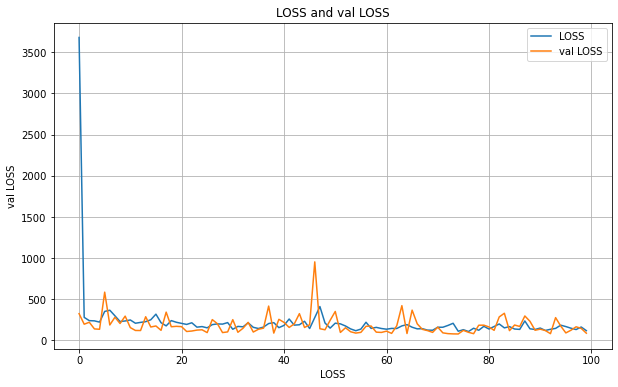

7/7 [==============================] - 0s 10ms/step


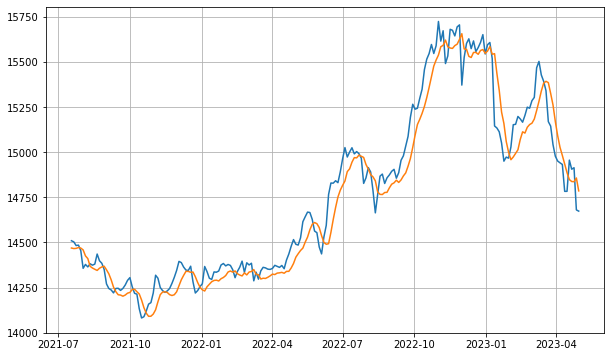

{'mae': 84.21624, 'mse': 11516.591, 'rmse': 107.315384, 'mape': 0.56578803, 'mase': 1.8386406}
Model: "2_model_JPY"


<ipython-input-2-5c4b28aa2962>:6: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = pd.read_csv('./currency_data_10_years.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               5376      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 48,641
Trainable params: 48,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
     19/Unknown - 1s 3ms/step - loss: 43.7489 - mae: 44.2479

INFO:tensorflow:Assets written to: saved_model/23\assets


INFO:tensorflow:Assets written to: saved_model/23\assets


31/31 [==============================] - 3s 47ms/step - loss: 28.2750 - mae: 28.7608 - val_loss: 1.6979 - val_mae: 2.1288
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 2.0250 - mae: 2.4756 - val_loss: 2.1148 - val_mae: 2.5822
Epoch 3/100
31/31 [==============================] - ETA: 0s - loss: 1.7771 - mae: 2.2243

INFO:tensorflow:Assets written to: saved_model/23\assets


INFO:tensorflow:Assets written to: saved_model/23\assets


31/31 [==============================] - 1s 40ms/step - loss: 1.7771 - mae: 2.2243 - val_loss: 1.5433 - val_mae: 1.9785
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 1.9058 - mae: 2.3612 - val_loss: 1.7235 - val_mae: 2.1762
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 1.6405 - mae: 2.0814 - val_loss: 2.1404 - val_mae: 2.6065
Epoch 6/100
19/31 [=================>............] - ETA: 0s - loss: 1.4881 - mae: 1.9252

INFO:tensorflow:Assets written to: saved_model/23\assets


INFO:tensorflow:Assets written to: saved_model/23\assets


31/31 [==============================] - 1s 40ms/step - loss: 1.7144 - mae: 2.1559 - val_loss: 1.4162 - val_mae: 1.8544
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 1.6325 - mae: 2.0767 - val_loss: 1.5322 - val_mae: 1.9818
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 1.6561 - mae: 2.0992 - val_loss: 2.0986 - val_mae: 2.5665
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 1.8961 - mae: 2.3531 - val_loss: 2.3622 - val_mae: 2.8360
Epoch 10/100
31/31 [==============================] - 0s 5ms/step - loss: 1.7823 - mae: 2.2341 - val_loss: 1.4722 - val_mae: 1.9232
Epoch 11/100
31/31 [==============================] - 0s 5ms/step - loss: 1.9813 - mae: 2.4407 - val_loss: 1.7542 - val_mae: 2.2150
Epoch 12/100
20/31 [==================>...........] - ETA: 0s - loss: 1.5136 - mae: 1.9537

INFO:tensorflow:Assets written to: saved_model/23\assets


INFO:tensorflow:Assets written to: saved_model/23\assets


31/31 [==============================] - 2s 46ms/step - loss: 1.4709 - mae: 1.9072 - val_loss: 1.3927 - val_mae: 1.8409
Epoch 13/100
20/31 [==================>...........] - ETA: 0s - loss: 1.4547 - mae: 1.8976

INFO:tensorflow:Assets written to: saved_model/23\assets


INFO:tensorflow:Assets written to: saved_model/23\assets


31/31 [==============================] - 1s 41ms/step - loss: 1.3790 - mae: 1.8179 - val_loss: 1.1819 - val_mae: 1.6073
Epoch 14/100
31/31 [==============================] - 0s 5ms/step - loss: 1.7341 - mae: 2.1895 - val_loss: 1.7066 - val_mae: 2.1681
Epoch 15/100
31/31 [==============================] - 0s 5ms/step - loss: 1.2601 - mae: 1.6919 - val_loss: 1.8356 - val_mae: 2.3041
Epoch 16/100
31/31 [==============================] - 0s 6ms/step - loss: 1.5405 - mae: 1.9894 - val_loss: 1.4946 - val_mae: 1.9460
Epoch 17/100
31/31 [==============================] - 0s 5ms/step - loss: 1.8239 - mae: 2.2735 - val_loss: 2.9283 - val_mae: 3.4104
Epoch 18/100
31/31 [==============================] - 0s 5ms/step - loss: 1.6556 - mae: 2.1097 - val_loss: 1.2039 - val_mae: 1.6387
Epoch 19/100
19/31 [=================>............] - ETA: 0s - loss: 1.2837 - mae: 1.7136

INFO:tensorflow:Assets written to: saved_model/23\assets


INFO:tensorflow:Assets written to: saved_model/23\assets


31/31 [==============================] - 1s 39ms/step - loss: 1.4175 - mae: 1.8571 - val_loss: 0.9695 - val_mae: 1.3895
Epoch 20/100
31/31 [==============================] - 0s 5ms/step - loss: 1.1207 - mae: 1.5454 - val_loss: 1.5451 - val_mae: 2.0029
Epoch 21/100
31/31 [==============================] - 0s 5ms/step - loss: 1.3559 - mae: 1.7933 - val_loss: 2.0810 - val_mae: 2.5559
Epoch 22/100
19/31 [=================>............] - ETA: 0s - loss: 1.4858 - mae: 1.9308

INFO:tensorflow:Assets written to: saved_model/23\assets


INFO:tensorflow:Assets written to: saved_model/23\assets


31/31 [==============================] - 1s 38ms/step - loss: 1.3852 - mae: 1.8235 - val_loss: 0.9059 - val_mae: 1.3297
Epoch 23/100
31/31 [==============================] - 0s 5ms/step - loss: 1.3426 - mae: 1.7814 - val_loss: 1.1345 - val_mae: 1.5775
Epoch 24/100
20/31 [==================>...........] - ETA: 0s - loss: 1.1821 - mae: 1.6115

INFO:tensorflow:Assets written to: saved_model/23\assets


INFO:tensorflow:Assets written to: saved_model/23\assets


31/31 [==============================] - 1s 39ms/step - loss: 1.1124 - mae: 1.5383 - val_loss: 0.8496 - val_mae: 1.2573
Epoch 25/100
18/31 [================>.............] - ETA: 0s - loss: 0.9678 - mae: 1.3863

INFO:tensorflow:Assets written to: saved_model/23\assets


INFO:tensorflow:Assets written to: saved_model/23\assets


31/31 [==============================] - 1s 39ms/step - loss: 1.0658 - mae: 1.4912 - val_loss: 0.8458 - val_mae: 1.2659
Epoch 26/100
31/31 [==============================] - 0s 5ms/step - loss: 1.4027 - mae: 1.8489 - val_loss: 2.1966 - val_mae: 2.6649
Epoch 27/100
31/31 [==============================] - 0s 5ms/step - loss: 1.3627 - mae: 1.8068 - val_loss: 2.4021 - val_mae: 2.8799
Epoch 28/100
20/31 [==================>...........] - ETA: 0s - loss: 1.2144 - mae: 1.6435

INFO:tensorflow:Assets written to: saved_model/23\assets


INFO:tensorflow:Assets written to: saved_model/23\assets


31/31 [==============================] - 2s 46ms/step - loss: 1.1811 - mae: 1.6082 - val_loss: 0.8252 - val_mae: 1.2442
Epoch 29/100
31/31 [==============================] - 0s 5ms/step - loss: 0.9667 - mae: 1.3812 - val_loss: 0.8349 - val_mae: 1.2557
Epoch 30/100
31/31 [==============================] - 0s 5ms/step - loss: 1.2932 - mae: 1.7279 - val_loss: 1.3121 - val_mae: 1.7671
Epoch 31/100
31/31 [==============================] - 0s 5ms/step - loss: 1.2103 - mae: 1.6520 - val_loss: 1.0570 - val_mae: 1.5000
Epoch 32/100
31/31 [==============================] - 0s 5ms/step - loss: 0.8878 - mae: 1.2965 - val_loss: 0.9540 - val_mae: 1.3862
Epoch 33/100
31/31 [==============================] - 0s 5ms/step - loss: 1.5588 - mae: 2.0095 - val_loss: 1.6368 - val_mae: 2.1035
Epoch 34/100
19/31 [=================>............] - ETA: 0s - loss: 2.0801 - mae: 2.5497

INFO:tensorflow:Assets written to: saved_model/23\assets


INFO:tensorflow:Assets written to: saved_model/23\assets


31/31 [==============================] - 1s 38ms/step - loss: 1.9720 - mae: 2.4379 - val_loss: 0.7747 - val_mae: 1.1764
Epoch 35/100
31/31 [==============================] - 0s 5ms/step - loss: 1.1202 - mae: 1.5548 - val_loss: 0.8276 - val_mae: 1.2354
Epoch 36/100
31/31 [==============================] - 0s 5ms/step - loss: 1.0259 - mae: 1.4506 - val_loss: 0.8061 - val_mae: 1.2242
Epoch 37/100
31/31 [==============================] - 0s 5ms/step - loss: 1.1661 - mae: 1.6022 - val_loss: 0.7915 - val_mae: 1.1950
Epoch 38/100
31/31 [==============================] - 0s 5ms/step - loss: 1.3773 - mae: 1.8278 - val_loss: 0.9241 - val_mae: 1.3580
Epoch 39/100
20/31 [==================>...........] - ETA: 0s - loss: 1.2025 - mae: 1.6372

INFO:tensorflow:Assets written to: saved_model/23\assets


INFO:tensorflow:Assets written to: saved_model/23\assets


31/31 [==============================] - 1s 38ms/step - loss: 1.0633 - mae: 1.4876 - val_loss: 0.7288 - val_mae: 1.1310
Epoch 40/100
31/31 [==============================] - 0s 5ms/step - loss: 0.8793 - mae: 1.2920 - val_loss: 1.1121 - val_mae: 1.5590
Epoch 41/100
31/31 [==============================] - 0s 5ms/step - loss: 1.1680 - mae: 1.6021 - val_loss: 1.2050 - val_mae: 1.6556
Epoch 42/100
31/31 [==============================] - 0s 5ms/step - loss: 1.4112 - mae: 1.8577 - val_loss: 1.2488 - val_mae: 1.7012
Epoch 43/100
31/31 [==============================] - 0s 5ms/step - loss: 1.3777 - mae: 1.8306 - val_loss: 0.9023 - val_mae: 1.3354
Epoch 44/100
31/31 [==============================] - 0s 5ms/step - loss: 1.7278 - mae: 2.1841 - val_loss: 1.2316 - val_mae: 1.6795
Epoch 45/100
31/31 [==============================] - 0s 5ms/step - loss: 1.2329 - mae: 1.6716 - val_loss: 2.0067 - val_mae: 2.4804
Epoch 46/100
31/31 [==============================] - 0s 5ms/step - loss: 1.0717 - mae: 

INFO:tensorflow:Assets written to: saved_model/23\assets


INFO:tensorflow:Assets written to: saved_model/23\assets


31/31 [==============================] - 1s 38ms/step - loss: 1.4522 - mae: 1.9075 - val_loss: 0.6675 - val_mae: 1.0644
Epoch 50/100
31/31 [==============================] - 0s 5ms/step - loss: 1.3149 - mae: 1.7625 - val_loss: 0.7180 - val_mae: 1.1134
Epoch 51/100
31/31 [==============================] - 0s 5ms/step - loss: 0.9748 - mae: 1.3971 - val_loss: 0.9771 - val_mae: 1.4142
Epoch 52/100
31/31 [==============================] - 0s 5ms/step - loss: 1.5029 - mae: 1.9553 - val_loss: 0.6969 - val_mae: 1.0995
Epoch 53/100
31/31 [==============================] - 0s 5ms/step - loss: 1.3672 - mae: 1.8157 - val_loss: 1.2243 - val_mae: 1.6721
Epoch 54/100
31/31 [==============================] - 0s 5ms/step - loss: 1.1691 - mae: 1.6001 - val_loss: 0.7287 - val_mae: 1.1381
Epoch 55/100
31/31 [==============================] - 0s 5ms/step - loss: 0.9136 - mae: 1.3335 - val_loss: 1.3099 - val_mae: 1.7639
Epoch 56/100
31/31 [==============================] - 0s 5ms/step - loss: 1.0214 - mae: 

INFO:tensorflow:Assets written to: saved_model/23\assets


INFO:tensorflow:Assets written to: saved_model/23\assets


31/31 [==============================] - 1s 39ms/step - loss: 0.9268 - mae: 1.3470 - val_loss: 0.6605 - val_mae: 1.0546
Epoch 59/100
31/31 [==============================] - 0s 5ms/step - loss: 1.0249 - mae: 1.4504 - val_loss: 1.0420 - val_mae: 1.4820
Epoch 60/100
19/31 [=================>............] - ETA: 0s - loss: 0.8389 - mae: 1.2534

INFO:tensorflow:Assets written to: saved_model/23\assets


INFO:tensorflow:Assets written to: saved_model/23\assets


31/31 [==============================] - 1s 38ms/step - loss: 0.8646 - mae: 1.2788 - val_loss: 0.6432 - val_mae: 1.0403
Epoch 61/100
31/31 [==============================] - 0s 5ms/step - loss: 1.1762 - mae: 1.6141 - val_loss: 0.6442 - val_mae: 1.0375
Epoch 62/100
19/31 [=================>............] - ETA: 0s - loss: 1.0035 - mae: 1.4303

INFO:tensorflow:Assets written to: saved_model/23\assets


INFO:tensorflow:Assets written to: saved_model/23\assets


31/31 [==============================] - 2s 45ms/step - loss: 1.0713 - mae: 1.5039 - val_loss: 0.6424 - val_mae: 1.0406
Epoch 63/100
31/31 [==============================] - 0s 5ms/step - loss: 0.8502 - mae: 1.2618 - val_loss: 0.6884 - val_mae: 1.0952
Epoch 64/100
31/31 [==============================] - 0s 5ms/step - loss: 0.7903 - mae: 1.1895 - val_loss: 0.7954 - val_mae: 1.2085
Epoch 65/100
31/31 [==============================] - 0s 5ms/step - loss: 0.9290 - mae: 1.3484 - val_loss: 0.6893 - val_mae: 1.0876
Epoch 66/100
31/31 [==============================] - 0s 5ms/step - loss: 0.7130 - mae: 1.1179 - val_loss: 0.6533 - val_mae: 1.0514
Epoch 67/100
31/31 [==============================] - 0s 5ms/step - loss: 1.0159 - mae: 1.4356 - val_loss: 0.7698 - val_mae: 1.1783
Epoch 68/100
19/31 [=================>............] - ETA: 0s - loss: 0.9454 - mae: 1.3659

INFO:tensorflow:Assets written to: saved_model/23\assets


INFO:tensorflow:Assets written to: saved_model/23\assets


31/31 [==============================] - 1s 40ms/step - loss: 1.0530 - mae: 1.4826 - val_loss: 0.6097 - val_mae: 1.0032
Epoch 69/100
31/31 [==============================] - 0s 5ms/step - loss: 0.7536 - mae: 1.1508 - val_loss: 0.6201 - val_mae: 1.0156
Epoch 70/100
31/31 [==============================] - 0s 5ms/step - loss: 1.2751 - mae: 1.7241 - val_loss: 2.6262 - val_mae: 3.1217
Epoch 71/100
31/31 [==============================] - 0s 5ms/step - loss: 1.3435 - mae: 1.7957 - val_loss: 1.0449 - val_mae: 1.4848
Epoch 72/100
31/31 [==============================] - 0s 5ms/step - loss: 0.7170 - mae: 1.1084 - val_loss: 0.8317 - val_mae: 1.2484
Epoch 73/100
31/31 [==============================] - 0s 5ms/step - loss: 0.9871 - mae: 1.4102 - val_loss: 1.4875 - val_mae: 1.9531
Epoch 74/100
31/31 [==============================] - 0s 5ms/step - loss: 1.0895 - mae: 1.5222 - val_loss: 1.9949 - val_mae: 2.4799
Epoch 75/100
31/31 [==============================] - 0s 5ms/step - loss: 1.1032 - mae: 

INFO:tensorflow:Assets written to: saved_model/23\assets


INFO:tensorflow:Assets written to: saved_model/23\assets


31/31 [==============================] - 1s 39ms/step - loss: 0.9229 - mae: 1.3426 - val_loss: 0.6014 - val_mae: 1.0003
Epoch 79/100
31/31 [==============================] - 0s 5ms/step - loss: 0.8924 - mae: 1.3094 - val_loss: 1.2986 - val_mae: 1.7565
Epoch 80/100
31/31 [==============================] - 0s 5ms/step - loss: 1.0971 - mae: 1.5338 - val_loss: 0.7641 - val_mae: 1.1701
Epoch 81/100
19/31 [=================>............] - ETA: 0s - loss: 0.7656 - mae: 1.1607

INFO:tensorflow:Assets written to: saved_model/23\assets


INFO:tensorflow:Assets written to: saved_model/23\assets


31/31 [==============================] - 1s 39ms/step - loss: 0.7259 - mae: 1.1196 - val_loss: 0.5789 - val_mae: 0.9727
Epoch 82/100
31/31 [==============================] - 0s 5ms/step - loss: 0.7267 - mae: 1.1308 - val_loss: 0.7271 - val_mae: 1.1281
Epoch 83/100
31/31 [==============================] - 0s 5ms/step - loss: 0.6763 - mae: 1.0654 - val_loss: 0.6702 - val_mae: 1.0673
Epoch 84/100
31/31 [==============================] - 0s 5ms/step - loss: 1.1007 - mae: 1.5356 - val_loss: 1.3711 - val_mae: 1.8331
Epoch 85/100
31/31 [==============================] - 0s 5ms/step - loss: 1.0708 - mae: 1.4938 - val_loss: 1.3436 - val_mae: 1.7996
Epoch 86/100
31/31 [==============================] - 0s 5ms/step - loss: 1.2704 - mae: 1.7130 - val_loss: 0.7165 - val_mae: 1.1132
Epoch 87/100
31/31 [==============================] - 0s 5ms/step - loss: 1.3248 - mae: 1.7729 - val_loss: 0.8988 - val_mae: 1.3245
Epoch 88/100
31/31 [==============================] - 0s 5ms/step - loss: 1.6102 - mae: 

INFO:tensorflow:Assets written to: saved_model/23\assets


INFO:tensorflow:Assets written to: saved_model/23\assets


31/31 [==============================] - 1s 39ms/step - loss: 1.1513 - mae: 1.5878 - val_loss: 0.5715 - val_mae: 0.9666
Epoch 94/100
31/31 [==============================] - 0s 5ms/step - loss: 0.7134 - mae: 1.1152 - val_loss: 0.6866 - val_mae: 1.0831
Epoch 95/100
31/31 [==============================] - 0s 6ms/step - loss: 0.8480 - mae: 1.2565 - val_loss: 1.2191 - val_mae: 1.6730
Epoch 96/100
31/31 [==============================] - 0s 5ms/step - loss: 0.8521 - mae: 1.2656 - val_loss: 0.6011 - val_mae: 0.9957
Epoch 97/100
31/31 [==============================] - 0s 5ms/step - loss: 0.7017 - mae: 1.1002 - val_loss: 1.8647 - val_mae: 2.3480
Epoch 98/100
19/31 [=================>............] - ETA: 0s - loss: 1.1322 - mae: 1.5754

INFO:tensorflow:Assets written to: saved_model/23\assets


INFO:tensorflow:Assets written to: saved_model/23\assets


31/31 [==============================] - 1s 39ms/step - loss: 1.1795 - mae: 1.6254 - val_loss: 0.5678 - val_mae: 0.9621
Epoch 99/100
31/31 [==============================] - 0s 5ms/step - loss: 0.7623 - mae: 1.1670 - val_loss: 0.5821 - val_mae: 0.9762
Epoch 100/100
7/7 [==============================] - 0s 7ms/step - loss: 1.2773 - mae: 1.7351


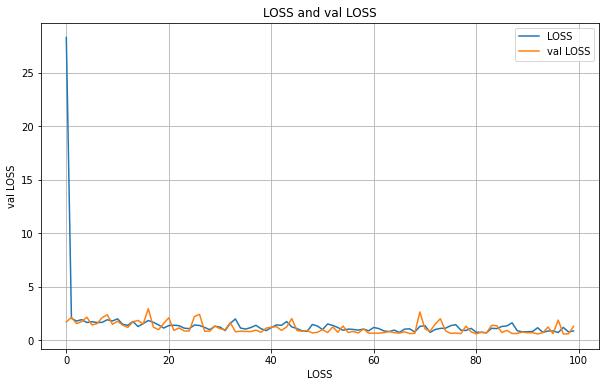

7/7 [==============================] - 0s 10ms/step


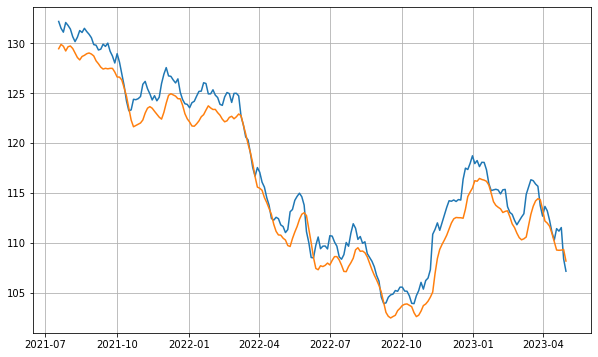

{'mae': 1.7545052, 'mse': 4.0743256, 'rmse': 2.0184958, 'mape': 1.4956486, 'mase': 2.7624693}
Model: "2_model_GBP"


<ipython-input-2-5c4b28aa2962>:6: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = pd.read_csv('./currency_data_10_years.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               5376      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 48,641
Trainable params: 48,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
     19/Unknown - 2s 3ms/step - loss: 3566.0000 - mae: 3566.

INFO:tensorflow:Assets written to: saved_model/24\assets


INFO:tensorflow:Assets written to: saved_model/24\assets


31/31 [==============================] - 3s 47ms/step - loss: 2515.2100 - mae: 2515.7100 - val_loss: 647.0693 - val_mae: 647.5693
Epoch 2/100
19/31 [=================>............] - ETA: 0s - loss: 560.7309 - mae: 561.2309

INFO:tensorflow:Assets written to: saved_model/24\assets


INFO:tensorflow:Assets written to: saved_model/24\assets


31/31 [==============================] - 1s 40ms/step - loss: 518.0493 - mae: 518.5487 - val_loss: 317.6138 - val_mae: 318.1138
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 493.2935 - mae: 493.7935 - val_loss: 320.0263 - val_mae: 320.5245
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 491.1980 - mae: 491.6980 - val_loss: 480.9903 - val_mae: 481.4903
Epoch 5/100
20/31 [==================>...........] - ETA: 0s - loss: 477.6418 - mae: 478.1418

INFO:tensorflow:Assets written to: saved_model/24\assets


INFO:tensorflow:Assets written to: saved_model/24\assets


31/31 [==============================] - 1s 39ms/step - loss: 445.3766 - mae: 445.8764 - val_loss: 283.3617 - val_mae: 283.8617
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 414.8421 - mae: 415.3421 - val_loss: 618.4189 - val_mae: 618.9189
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 574.6163 - mae: 575.1163 - val_loss: 512.8356 - val_mae: 513.3351
Epoch 8/100
19/31 [=================>............] - ETA: 0s - loss: 545.4216 - mae: 545.9211

INFO:tensorflow:Assets written to: saved_model/24\assets


INFO:tensorflow:Assets written to: saved_model/24\assets


31/31 [==============================] - 1s 39ms/step - loss: 478.5444 - mae: 479.0437 - val_loss: 249.8270 - val_mae: 250.3270
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 347.7456 - mae: 348.2453 - val_loss: 437.5525 - val_mae: 438.0525
Epoch 10/100
19/31 [=================>............] - ETA: 0s - loss: 340.1367 - mae: 340.6366

INFO:tensorflow:Assets written to: saved_model/24\assets


INFO:tensorflow:Assets written to: saved_model/24\assets


31/31 [==============================] - 1s 39ms/step - loss: 333.3605 - mae: 333.8603 - val_loss: 239.0480 - val_mae: 239.5480
Epoch 11/100
31/31 [==============================] - 0s 5ms/step - loss: 383.0601 - mae: 383.5596 - val_loss: 540.0469 - val_mae: 540.5469
Epoch 12/100
31/31 [==============================] - 0s 5ms/step - loss: 394.1655 - mae: 394.6655 - val_loss: 326.4438 - val_mae: 326.9438
Epoch 13/100
31/31 [==============================] - 0s 5ms/step - loss: 336.0949 - mae: 336.5949 - val_loss: 520.0280 - val_mae: 520.5280
Epoch 14/100
31/31 [==============================] - 0s 5ms/step - loss: 433.1711 - mae: 433.6708 - val_loss: 580.4144 - val_mae: 580.9144
Epoch 15/100
19/31 [=================>............] - ETA: 0s - loss: 315.7229 - mae: 316.2229

INFO:tensorflow:Assets written to: saved_model/24\assets


INFO:tensorflow:Assets written to: saved_model/24\assets


31/31 [==============================] - 2s 46ms/step - loss: 296.2125 - mae: 296.7124 - val_loss: 185.0289 - val_mae: 185.5271
Epoch 16/100
31/31 [==============================] - 0s 5ms/step - loss: 254.5066 - mae: 255.0065 - val_loss: 542.5396 - val_mae: 543.0396
Epoch 17/100
31/31 [==============================] - 0s 5ms/step - loss: 345.5256 - mae: 346.0256 - val_loss: 305.8590 - val_mae: 306.3590
Epoch 18/100
31/31 [==============================] - 0s 5ms/step - loss: 603.3327 - mae: 603.8327 - val_loss: 185.4164 - val_mae: 185.9148
Epoch 19/100
31/31 [==============================] - 0s 5ms/step - loss: 336.5699 - mae: 337.0693 - val_loss: 185.4437 - val_mae: 185.9418
Epoch 20/100
31/31 [==============================] - 0s 5ms/step - loss: 283.6206 - mae: 284.1196 - val_loss: 485.0764 - val_mae: 485.5764
Epoch 21/100
19/31 [=================>............] - ETA: 0s - loss: 278.5742 - mae: 279.0738

INFO:tensorflow:Assets written to: saved_model/24\assets


INFO:tensorflow:Assets written to: saved_model/24\assets


31/31 [==============================] - 2s 50ms/step - loss: 267.6903 - mae: 268.1900 - val_loss: 174.3028 - val_mae: 174.8026
Epoch 22/100
31/31 [==============================] - 0s 5ms/step - loss: 282.0642 - mae: 282.5633 - val_loss: 232.3342 - val_mae: 232.8342
Epoch 23/100
31/31 [==============================] - 0s 5ms/step - loss: 281.0544 - mae: 281.5539 - val_loss: 181.4424 - val_mae: 181.9424
Epoch 24/100
31/31 [==============================] - 0s 5ms/step - loss: 262.5285 - mae: 263.0283 - val_loss: 204.5333 - val_mae: 205.0324
Epoch 25/100
31/31 [==============================] - 0s 6ms/step - loss: 353.5572 - mae: 354.0567 - val_loss: 489.2254 - val_mae: 489.7251
Epoch 26/100
28/31 [==========================>...] - ETA: 0s - loss: 333.7119 - mae: 334.2113

INFO:tensorflow:Assets written to: saved_model/24\assets


INFO:tensorflow:Assets written to: saved_model/24\assets


31/31 [==============================] - 2s 57ms/step - loss: 322.6966 - mae: 323.1957 - val_loss: 162.7540 - val_mae: 163.2525
Epoch 27/100
31/31 [==============================] - 0s 6ms/step - loss: 291.3354 - mae: 291.8347 - val_loss: 325.6531 - val_mae: 326.1531
Epoch 28/100
18/31 [================>.............] - ETA: 0s - loss: 236.7557 - mae: 237.2556

INFO:tensorflow:Assets written to: saved_model/24\assets


INFO:tensorflow:Assets written to: saved_model/24\assets


31/31 [==============================] - 2s 57ms/step - loss: 234.7614 - mae: 235.2600 - val_loss: 156.9890 - val_mae: 157.4889
Epoch 29/100
31/31 [==============================] - 0s 6ms/step - loss: 240.6360 - mae: 241.1356 - val_loss: 188.7074 - val_mae: 189.2070
Epoch 30/100
31/31 [==============================] - 0s 5ms/step - loss: 257.7492 - mae: 258.2491 - val_loss: 167.2178 - val_mae: 167.7171
Epoch 31/100
31/31 [==============================] - 0s 5ms/step - loss: 246.9183 - mae: 247.4180 - val_loss: 231.6772 - val_mae: 232.1772
Epoch 32/100
31/31 [==============================] - 0s 5ms/step - loss: 279.6658 - mae: 280.1647 - val_loss: 173.6421 - val_mae: 174.1421
Epoch 33/100
31/31 [==============================] - 0s 5ms/step - loss: 263.5892 - mae: 264.0881 - val_loss: 165.1186 - val_mae: 165.6186
Epoch 34/100
31/31 [==============================] - 0s 5ms/step - loss: 242.1682 - mae: 242.6680 - val_loss: 170.6282 - val_mae: 171.1282
Epoch 35/100
31/31 [============

INFO:tensorflow:Assets written to: saved_model/24\assets


INFO:tensorflow:Assets written to: saved_model/24\assets


31/31 [==============================] - 1s 39ms/step - loss: 262.2741 - mae: 262.7740 - val_loss: 149.9141 - val_mae: 150.4141
Epoch 43/100
31/31 [==============================] - 0s 5ms/step - loss: 226.4866 - mae: 226.9866 - val_loss: 252.0011 - val_mae: 252.5004
Epoch 44/100
31/31 [==============================] - 0s 5ms/step - loss: 276.9815 - mae: 277.4810 - val_loss: 320.3285 - val_mae: 320.8285
Epoch 45/100
31/31 [==============================] - 0s 5ms/step - loss: 287.3883 - mae: 287.8882 - val_loss: 466.8322 - val_mae: 467.3322
Epoch 46/100
18/31 [================>.............] - ETA: 0s - loss: 280.1063 - mae: 280.6063

INFO:tensorflow:Assets written to: saved_model/24\assets


INFO:tensorflow:Assets written to: saved_model/24\assets


31/31 [==============================] - 2s 45ms/step - loss: 251.5476 - mae: 252.0472 - val_loss: 146.7668 - val_mae: 147.2668
Epoch 47/100
31/31 [==============================] - 0s 5ms/step - loss: 305.0476 - mae: 305.5468 - val_loss: 295.3253 - val_mae: 295.8253
Epoch 48/100
19/31 [=================>............] - ETA: 0s - loss: 191.8065 - mae: 192.3057

INFO:tensorflow:Assets written to: saved_model/24\assets


INFO:tensorflow:Assets written to: saved_model/24\assets


31/31 [==============================] - 1s 39ms/step - loss: 199.9137 - mae: 200.4128 - val_loss: 141.7048 - val_mae: 142.2016
Epoch 49/100
31/31 [==============================] - 0s 5ms/step - loss: 427.5822 - mae: 428.0815 - val_loss: 167.0274 - val_mae: 167.5274
Epoch 50/100
31/31 [==============================] - 0s 5ms/step - loss: 250.9990 - mae: 251.4989 - val_loss: 203.8570 - val_mae: 204.3570
Epoch 51/100
31/31 [==============================] - 0s 5ms/step - loss: 220.3443 - mae: 220.8438 - val_loss: 167.3669 - val_mae: 167.8669
Epoch 52/100
31/31 [==============================] - 0s 5ms/step - loss: 265.4088 - mae: 265.9087 - val_loss: 141.8560 - val_mae: 142.3551
Epoch 53/100
31/31 [==============================] - 0s 5ms/step - loss: 238.0570 - mae: 238.5565 - val_loss: 217.8253 - val_mae: 218.3253
Epoch 54/100
19/31 [=================>............] - ETA: 0s - loss: 251.0266 - mae: 251.5256

INFO:tensorflow:Assets written to: saved_model/24\assets


INFO:tensorflow:Assets written to: saved_model/24\assets


31/31 [==============================] - 1s 41ms/step - loss: 275.0338 - mae: 275.5332 - val_loss: 141.0873 - val_mae: 141.5868
Epoch 55/100
31/31 [==============================] - 0s 5ms/step - loss: 273.9835 - mae: 274.4827 - val_loss: 250.8034 - val_mae: 251.3034
Epoch 56/100
31/31 [==============================] - 0s 5ms/step - loss: 215.1206 - mae: 215.6196 - val_loss: 156.2004 - val_mae: 156.6999
Epoch 57/100
31/31 [==============================] - 0s 5ms/step - loss: 206.2806 - mae: 206.7790 - val_loss: 143.2932 - val_mae: 143.7908
Epoch 58/100
31/31 [==============================] - 0s 5ms/step - loss: 186.1108 - mae: 186.6106 - val_loss: 280.1874 - val_mae: 280.6874
Epoch 59/100
18/31 [================>.............] - ETA: 0s - loss: 227.9552 - mae: 228.4543

INFO:tensorflow:Assets written to: saved_model/24\assets


INFO:tensorflow:Assets written to: saved_model/24\assets


31/31 [==============================] - 1s 42ms/step - loss: 278.9247 - mae: 279.4240 - val_loss: 137.9363 - val_mae: 138.4357
Epoch 60/100
31/31 [==============================] - 0s 5ms/step - loss: 267.1989 - mae: 267.6984 - val_loss: 176.6915 - val_mae: 177.1912
Epoch 61/100
31/31 [==============================] - 0s 5ms/step - loss: 269.2158 - mae: 269.7156 - val_loss: 501.8760 - val_mae: 502.3760
Epoch 62/100
31/31 [==============================] - 0s 5ms/step - loss: 210.2455 - mae: 210.7455 - val_loss: 300.9396 - val_mae: 301.4382
Epoch 63/100
31/31 [==============================] - 0s 5ms/step - loss: 181.4409 - mae: 181.9403 - val_loss: 199.8479 - val_mae: 200.3479
Epoch 64/100
31/31 [==============================] - 0s 5ms/step - loss: 267.3369 - mae: 267.8365 - val_loss: 214.0275 - val_mae: 214.5275
Epoch 65/100
31/31 [==============================] - 0s 5ms/step - loss: 232.3899 - mae: 232.8898 - val_loss: 209.5722 - val_mae: 210.0722
Epoch 66/100
31/31 [============

INFO:tensorflow:Assets written to: saved_model/24\assets


INFO:tensorflow:Assets written to: saved_model/24\assets


31/31 [==============================] - 1s 38ms/step - loss: 223.7230 - mae: 224.2229 - val_loss: 135.3687 - val_mae: 135.8680
Epoch 98/100
31/31 [==============================] - 0s 5ms/step - loss: 234.3352 - mae: 234.8351 - val_loss: 149.4439 - val_mae: 149.9439
Epoch 99/100
31/31 [==============================] - 0s 5ms/step - loss: 191.0405 - mae: 191.5392 - val_loss: 270.4802 - val_mae: 270.9802
Epoch 100/100
7/7 [==============================] - 0s 6ms/step - loss: 240.4699 - mae: 240.9679


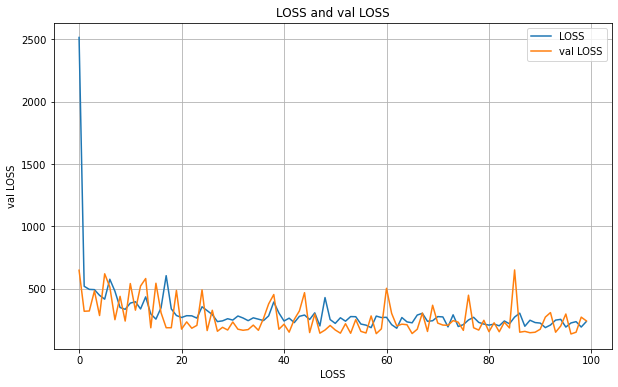

7/7 [==============================] - 0s 10ms/step


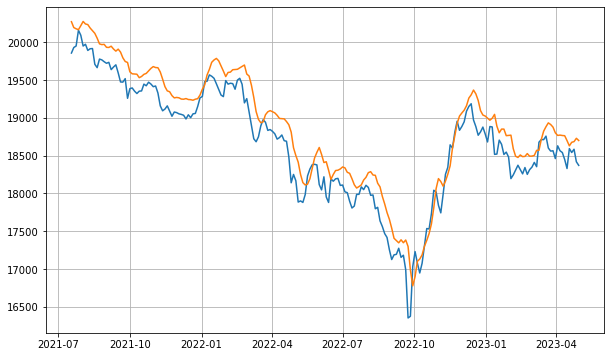

{'mae': 242.07408, 'mse': 78377.45, 'rmse': 279.95975, 'mape': 1.3050843, 'mase': 2.5515819}


<ipython-input-2-5c4b28aa2962>:6: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = pd.read_csv('./currency_data_10_years.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


Model: "2_model_SGD"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               5376      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 48,641
Trainable params: 48,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
     19/Unknown - 1s 3ms/step - loss: 1

INFO:tensorflow:Assets written to: saved_model/25\assets


INFO:tensorflow:Assets written to: saved_model/25\assets


31/31 [==============================] - 3s 55ms/step - loss: 858.2552 - mae: 858.7552 - val_loss: 801.6314 - val_mae: 802.1314
Epoch 2/100
18/31 [================>.............] - ETA: 0s - loss: 281.1864 - mae: 281.6862

INFO:tensorflow:Assets written to: saved_model/25\assets


INFO:tensorflow:Assets written to: saved_model/25\assets


31/31 [==============================] - 1s 40ms/step - loss: 257.8011 - mae: 258.3007 - val_loss: 173.7869 - val_mae: 174.2869
Epoch 3/100
19/31 [=================>............] - ETA: 0s - loss: 180.2405 - mae: 180.7404

INFO:tensorflow:Assets written to: saved_model/25\assets


INFO:tensorflow:Assets written to: saved_model/25\assets


31/31 [==============================] - 1s 39ms/step - loss: 194.7520 - mae: 195.2517 - val_loss: 133.4771 - val_mae: 133.9771
Epoch 4/100
19/31 [=================>............] - ETA: 0s - loss: 160.9432 - mae: 161.4412

INFO:tensorflow:Assets written to: saved_model/25\assets


INFO:tensorflow:Assets written to: saved_model/25\assets


31/31 [==============================] - 1s 39ms/step - loss: 152.6656 - mae: 153.1638 - val_loss: 124.1462 - val_mae: 124.6444
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 161.5494 - mae: 162.0482 - val_loss: 264.5234 - val_mae: 265.0234
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 201.9825 - mae: 202.4819 - val_loss: 127.0451 - val_mae: 127.5449
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 181.7515 - mae: 182.2505 - val_loss: 136.0755 - val_mae: 136.5717
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 144.4779 - mae: 144.9772 - val_loss: 126.6988 - val_mae: 127.1973
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 203.6166 - mae: 204.1162 - val_loss: 238.5360 - val_mae: 239.0360
Epoch 10/100
31/31 [==============================] - 0s 5ms/step - loss: 170.0747 - mae: 170.5744 - val_loss: 257.4083 - val_mae: 257.9083
Epoch 11/100
19/31 [=================

INFO:tensorflow:Assets written to: saved_model/25\assets


INFO:tensorflow:Assets written to: saved_model/25\assets


31/31 [==============================] - 1s 39ms/step - loss: 140.2635 - mae: 140.7634 - val_loss: 116.6909 - val_mae: 117.1909
Epoch 12/100
31/31 [==============================] - 0s 5ms/step - loss: 192.4383 - mae: 192.9379 - val_loss: 143.5222 - val_mae: 144.0222
Epoch 13/100
19/31 [=================>............] - ETA: 0s - loss: 187.0051 - mae: 187.5047

INFO:tensorflow:Assets written to: saved_model/25\assets


INFO:tensorflow:Assets written to: saved_model/25\assets


31/31 [==============================] - 1s 40ms/step - loss: 171.9745 - mae: 172.4742 - val_loss: 98.9908 - val_mae: 99.4908
Epoch 14/100
31/31 [==============================] - 0s 5ms/step - loss: 150.2008 - mae: 150.7002 - val_loss: 108.3965 - val_mae: 108.8945
Epoch 15/100
31/31 [==============================] - 0s 5ms/step - loss: 139.9628 - mae: 140.4626 - val_loss: 171.7822 - val_mae: 172.2822
Epoch 16/100
31/31 [==============================] - 0s 5ms/step - loss: 160.1015 - mae: 160.6006 - val_loss: 161.6992 - val_mae: 162.1992
Epoch 17/100
19/31 [=================>............] - ETA: 0s - loss: 149.5510 - mae: 150.0506

INFO:tensorflow:Assets written to: saved_model/25\assets


INFO:tensorflow:Assets written to: saved_model/25\assets


31/31 [==============================] - 1s 45ms/step - loss: 138.0843 - mae: 138.5837 - val_loss: 96.0662 - val_mae: 96.5661
Epoch 18/100
31/31 [==============================] - 0s 5ms/step - loss: 139.0126 - mae: 139.5118 - val_loss: 138.1702 - val_mae: 138.6697
Epoch 19/100
31/31 [==============================] - 0s 5ms/step - loss: 152.4824 - mae: 152.9823 - val_loss: 192.6933 - val_mae: 193.1933
Epoch 20/100
31/31 [==============================] - 0s 5ms/step - loss: 133.0829 - mae: 133.5827 - val_loss: 156.7196 - val_mae: 157.2195
Epoch 21/100
31/31 [==============================] - 0s 5ms/step - loss: 168.0946 - mae: 168.5942 - val_loss: 145.9756 - val_mae: 146.4756
Epoch 22/100
19/31 [=================>............] - ETA: 0s - loss: 117.4432 - mae: 117.9424

INFO:tensorflow:Assets written to: saved_model/25\assets


INFO:tensorflow:Assets written to: saved_model/25\assets


31/31 [==============================] - 1s 38ms/step - loss: 113.1964 - mae: 113.6951 - val_loss: 89.5457 - val_mae: 90.0414
Epoch 23/100
31/31 [==============================] - 0s 5ms/step - loss: 103.2751 - mae: 103.7739 - val_loss: 115.1852 - val_mae: 115.6848
Epoch 24/100
31/31 [==============================] - 0s 5ms/step - loss: 131.6199 - mae: 132.1193 - val_loss: 151.2416 - val_mae: 151.7416
Epoch 25/100
31/31 [==============================] - 0s 6ms/step - loss: 151.2353 - mae: 151.7342 - val_loss: 155.0409 - val_mae: 155.5409
Epoch 26/100
19/31 [=================>............] - ETA: 0s - loss: 131.1745 - mae: 131.6742

INFO:tensorflow:Assets written to: saved_model/25\assets


INFO:tensorflow:Assets written to: saved_model/25\assets


31/31 [==============================] - 1s 38ms/step - loss: 136.2323 - mae: 136.7316 - val_loss: 79.7483 - val_mae: 80.2474
Epoch 27/100
31/31 [==============================] - 0s 5ms/step - loss: 184.4614 - mae: 184.9607 - val_loss: 117.6550 - val_mae: 118.1543
Epoch 28/100
31/31 [==============================] - 0s 5ms/step - loss: 128.9716 - mae: 129.4712 - val_loss: 80.2364 - val_mae: 80.7341
Epoch 29/100
31/31 [==============================] - 0s 5ms/step - loss: 145.3877 - mae: 145.8869 - val_loss: 80.6959 - val_mae: 81.1930
Epoch 30/100
31/31 [==============================] - 0s 5ms/step - loss: 125.7865 - mae: 126.2847 - val_loss: 132.0633 - val_mae: 132.5603
Epoch 31/100
31/31 [==============================] - 0s 5ms/step - loss: 220.2040 - mae: 220.7032 - val_loss: 241.9578 - val_mae: 242.4578
Epoch 32/100
31/31 [==============================] - 0s 5ms/step - loss: 169.3218 - mae: 169.8206 - val_loss: 87.7337 - val_mae: 88.2337
Epoch 33/100
31/31 [====================

INFO:tensorflow:Assets written to: saved_model/25\assets


INFO:tensorflow:Assets written to: saved_model/25\assets


31/31 [==============================] - 1s 39ms/step - loss: 100.6422 - mae: 101.1407 - val_loss: 75.7057 - val_mae: 76.2057
Epoch 39/100
31/31 [==============================] - 0s 5ms/step - loss: 108.5968 - mae: 109.0961 - val_loss: 104.6778 - val_mae: 105.1757
Epoch 40/100
31/31 [==============================] - 0s 5ms/step - loss: 120.1143 - mae: 120.6140 - val_loss: 79.5331 - val_mae: 80.0301
Epoch 41/100
31/31 [==============================] - 0s 6ms/step - loss: 105.7080 - mae: 106.2073 - val_loss: 95.3982 - val_mae: 95.8947
Epoch 42/100
31/31 [==============================] - 0s 5ms/step - loss: 92.3074 - mae: 92.8062 - val_loss: 121.6454 - val_mae: 122.1454
Epoch 43/100
31/31 [==============================] - 0s 5ms/step - loss: 120.1474 - mae: 120.6455 - val_loss: 148.0176 - val_mae: 148.5176
Epoch 44/100
31/31 [==============================] - 0s 5ms/step - loss: 125.8512 - mae: 126.3496 - val_loss: 171.8799 - val_mae: 172.3799
Epoch 45/100
31/31 [====================

INFO:tensorflow:Assets written to: saved_model/25\assets


INFO:tensorflow:Assets written to: saved_model/25\assets


31/31 [==============================] - 1s 39ms/step - loss: 155.9401 - mae: 156.4400 - val_loss: 67.5499 - val_mae: 68.0496
Epoch 53/100
31/31 [==============================] - 0s 5ms/step - loss: 114.2977 - mae: 114.7952 - val_loss: 71.5846 - val_mae: 72.0846
Epoch 54/100
31/31 [==============================] - 0s 5ms/step - loss: 107.8495 - mae: 108.3476 - val_loss: 180.3969 - val_mae: 180.8969
Epoch 55/100
31/31 [==============================] - 0s 5ms/step - loss: 147.8623 - mae: 148.3623 - val_loss: 141.0653 - val_mae: 141.5653
Epoch 56/100
31/31 [==============================] - 0s 5ms/step - loss: 85.9960 - mae: 86.4939 - val_loss: 145.2083 - val_mae: 145.7083
Epoch 57/100
31/31 [==============================] - 0s 5ms/step - loss: 112.4096 - mae: 112.9079 - val_loss: 76.3609 - val_mae: 76.8603
Epoch 58/100
19/31 [=================>............] - ETA: 0s - loss: 154.8696 - mae: 155.3680

INFO:tensorflow:Assets written to: saved_model/25\assets


INFO:tensorflow:Assets written to: saved_model/25\assets


31/31 [==============================] - 1s 39ms/step - loss: 144.9279 - mae: 145.4269 - val_loss: 64.9072 - val_mae: 65.4032
Epoch 59/100
31/31 [==============================] - 0s 5ms/step - loss: 119.1336 - mae: 119.6316 - val_loss: 89.8859 - val_mae: 90.3852
Epoch 60/100
31/31 [==============================] - 0s 5ms/step - loss: 112.5283 - mae: 113.0277 - val_loss: 95.7564 - val_mae: 96.2562
Epoch 61/100
19/31 [=================>............] - ETA: 0s - loss: 104.6061 - mae: 105.1046

INFO:tensorflow:Assets written to: saved_model/25\assets


INFO:tensorflow:Assets written to: saved_model/25\assets


31/31 [==============================] - 2s 46ms/step - loss: 115.9415 - mae: 116.4405 - val_loss: 63.1333 - val_mae: 63.6312
Epoch 62/100
31/31 [==============================] - 0s 5ms/step - loss: 136.2474 - mae: 136.7457 - val_loss: 68.1899 - val_mae: 68.6866
Epoch 63/100
31/31 [==============================] - 0s 5ms/step - loss: 113.4466 - mae: 113.9462 - val_loss: 113.4665 - val_mae: 113.9665
Epoch 64/100
31/31 [==============================] - 0s 5ms/step - loss: 97.4566 - mae: 97.9558 - val_loss: 133.2200 - val_mae: 133.7200
Epoch 65/100
31/31 [==============================] - 0s 5ms/step - loss: 99.3482 - mae: 99.8467 - val_loss: 172.2236 - val_mae: 172.7236
Epoch 66/100
31/31 [==============================] - 0s 5ms/step - loss: 102.3021 - mae: 102.8012 - val_loss: 69.2220 - val_mae: 69.7220
Epoch 67/100
31/31 [==============================] - 0s 5ms/step - loss: 112.6509 - mae: 113.1501 - val_loss: 120.9510 - val_mae: 121.4510
Epoch 68/100
31/31 [======================

INFO:tensorflow:Assets written to: saved_model/25\assets


INFO:tensorflow:Assets written to: saved_model/25\assets


31/31 [==============================] - 1s 40ms/step - loss: 113.5843 - mae: 114.0833 - val_loss: 63.1226 - val_mae: 63.6206
Epoch 85/100
31/31 [==============================] - 0s 5ms/step - loss: 115.2159 - mae: 115.7151 - val_loss: 101.1869 - val_mae: 101.6850
Epoch 86/100
31/31 [==============================] - 0s 5ms/step - loss: 126.3834 - mae: 126.8828 - val_loss: 92.2411 - val_mae: 92.7411
Epoch 87/100
31/31 [==============================] - 0s 5ms/step - loss: 96.1740 - mae: 96.6733 - val_loss: 73.2699 - val_mae: 73.7675
Epoch 88/100
31/31 [==============================] - 0s 5ms/step - loss: 99.2196 - mae: 99.7180 - val_loss: 116.1606 - val_mae: 116.6604
Epoch 89/100
31/31 [==============================] - 0s 5ms/step - loss: 117.3666 - mae: 117.8662 - val_loss: 123.4023 - val_mae: 123.9023
Epoch 90/100
31/31 [==============================] - 0s 5ms/step - loss: 125.5042 - mae: 126.0036 - val_loss: 84.5172 - val_mae: 85.0161
Epoch 91/100
31/31 [========================

INFO:tensorflow:Assets written to: saved_model/25\assets


INFO:tensorflow:Assets written to: saved_model/25\assets


31/31 [==============================] - 1s 39ms/step - loss: 88.2269 - mae: 88.7262 - val_loss: 56.6748 - val_mae: 57.1728
Epoch 98/100
31/31 [==============================] - 0s 5ms/step - loss: 96.9998 - mae: 97.4982 - val_loss: 116.3990 - val_mae: 116.8990
Epoch 99/100
31/31 [==============================] - 0s 5ms/step - loss: 106.0742 - mae: 106.5736 - val_loss: 94.5719 - val_mae: 95.0719
Epoch 100/100
7/7 [==============================] - 0s 7ms/step - loss: 58.3060 - mae: 58.8028


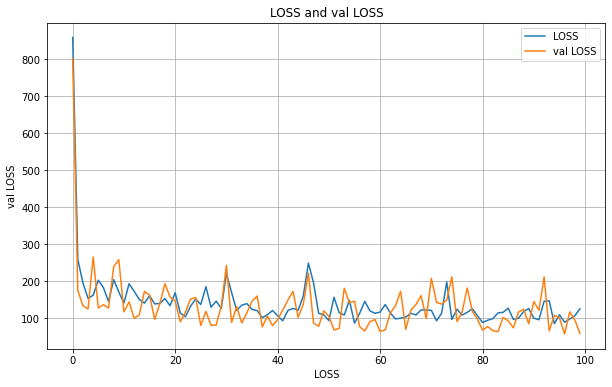

7/7 [==============================] - 0s 10ms/step


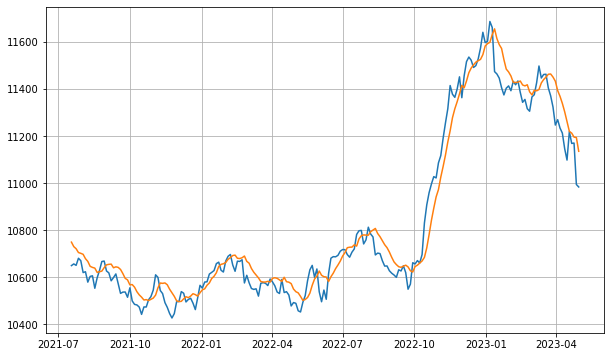

{'mae': 57.932564, 'mse': 5340.218, 'rmse': 73.0768, 'mape': 0.5323642, 'mase': 1.7915801}


<ipython-input-2-5c4b28aa2962>:6: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = pd.read_csv('./currency_data_10_years.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


Model: "2_model_AUD"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               5376      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 48,641
Trainable params: 48,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
     19/Unknown - 1s 3ms/step - loss: 2

INFO:tensorflow:Assets written to: saved_model/26\assets


INFO:tensorflow:Assets written to: saved_model/26\assets


31/31 [==============================] - 3s 46ms/step - loss: 1494.8380 - mae: 1495.3378 - val_loss: 393.3642 - val_mae: 393.8642
Epoch 2/100
20/31 [==================>...........] - ETA: 0s - loss: 211.5496 - mae: 212.0495

INFO:tensorflow:Assets written to: saved_model/26\assets


INFO:tensorflow:Assets written to: saved_model/26\assets


31/31 [==============================] - 1s 40ms/step - loss: 206.2757 - mae: 206.7754 - val_loss: 193.2281 - val_mae: 193.7263
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 183.7834 - mae: 184.2827 - val_loss: 195.8655 - val_mae: 196.3654
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 208.5167 - mae: 209.0166 - val_loss: 256.7141 - val_mae: 257.2140
Epoch 5/100
19/31 [=================>............] - ETA: 0s - loss: 210.3761 - mae: 210.8761

INFO:tensorflow:Assets written to: saved_model/26\assets


INFO:tensorflow:Assets written to: saved_model/26\assets


31/31 [==============================] - 2s 45ms/step - loss: 200.6740 - mae: 201.1740 - val_loss: 170.3608 - val_mae: 170.8602
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 192.9641 - mae: 193.4625 - val_loss: 175.4840 - val_mae: 175.9838
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 229.8022 - mae: 230.3021 - val_loss: 348.3592 - val_mae: 348.8592
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 189.5562 - mae: 190.0558 - val_loss: 222.8266 - val_mae: 223.3252
Epoch 9/100
31/31 [==============================] - 0s 6ms/step - loss: 177.6893 - mae: 178.1890 - val_loss: 242.6045 - val_mae: 243.1039
Epoch 10/100
31/31 [==============================] - 0s 5ms/step - loss: 180.7288 - mae: 181.2287 - val_loss: 252.3879 - val_mae: 252.8879
Epoch 11/100
19/31 [=================>............] - ETA: 0s - loss: 172.5299 - mae: 173.0298

INFO:tensorflow:Assets written to: saved_model/26\assets


INFO:tensorflow:Assets written to: saved_model/26\assets


31/31 [==============================] - 1s 42ms/step - loss: 167.2716 - mae: 167.7713 - val_loss: 147.3597 - val_mae: 147.8597
Epoch 12/100
31/31 [==============================] - 0s 5ms/step - loss: 237.9171 - mae: 238.4170 - val_loss: 201.2322 - val_mae: 201.7322
Epoch 13/100
19/31 [=================>............] - ETA: 0s - loss: 210.2352 - mae: 210.7341

INFO:tensorflow:Assets written to: saved_model/26\assets


INFO:tensorflow:Assets written to: saved_model/26\assets


31/31 [==============================] - 1s 39ms/step - loss: 187.1618 - mae: 187.6611 - val_loss: 146.9308 - val_mae: 147.4297
Epoch 14/100
31/31 [==============================] - 0s 5ms/step - loss: 180.4369 - mae: 180.9368 - val_loss: 227.9127 - val_mae: 228.4126
Epoch 15/100
31/31 [==============================] - 0s 5ms/step - loss: 169.0471 - mae: 169.5464 - val_loss: 155.1309 - val_mae: 155.6309
Epoch 16/100
31/31 [==============================] - 0s 5ms/step - loss: 146.3745 - mae: 146.8742 - val_loss: 258.1679 - val_mae: 258.6656
Epoch 17/100
31/31 [==============================] - 0s 5ms/step - loss: 171.3287 - mae: 171.8274 - val_loss: 193.1810 - val_mae: 193.6810
Epoch 18/100
19/31 [=================>............] - ETA: 0s - loss: 169.6073 - mae: 170.1060

INFO:tensorflow:Assets written to: saved_model/26\assets


INFO:tensorflow:Assets written to: saved_model/26\assets


31/31 [==============================] - 1s 39ms/step - loss: 155.1301 - mae: 155.6288 - val_loss: 130.9245 - val_mae: 131.4227
Epoch 19/100
19/31 [=================>............] - ETA: 0s - loss: 141.3943 - mae: 141.8929

INFO:tensorflow:Assets written to: saved_model/26\assets


INFO:tensorflow:Assets written to: saved_model/26\assets


31/31 [==============================] - 1s 39ms/step - loss: 149.8941 - mae: 150.3928 - val_loss: 124.8684 - val_mae: 125.3684
Epoch 20/100
31/31 [==============================] - 0s 5ms/step - loss: 151.1697 - mae: 151.6689 - val_loss: 147.8600 - val_mae: 148.3600
Epoch 21/100
31/31 [==============================] - 0s 5ms/step - loss: 200.8506 - mae: 201.3500 - val_loss: 149.0964 - val_mae: 149.5961
Epoch 22/100
31/31 [==============================] - 0s 5ms/step - loss: 149.2644 - mae: 149.7643 - val_loss: 152.1220 - val_mae: 152.6200
Epoch 23/100
19/31 [=================>............] - ETA: 0s - loss: 140.9286 - mae: 141.4257

INFO:tensorflow:Assets written to: saved_model/26\assets


INFO:tensorflow:Assets written to: saved_model/26\assets


31/31 [==============================] - 1s 39ms/step - loss: 134.9409 - mae: 135.4378 - val_loss: 118.1540 - val_mae: 118.6540
Epoch 24/100
31/31 [==============================] - 0s 5ms/step - loss: 141.6138 - mae: 142.1135 - val_loss: 118.3451 - val_mae: 118.8425
Epoch 25/100
31/31 [==============================] - 0s 5ms/step - loss: 116.2373 - mae: 116.7356 - val_loss: 125.4041 - val_mae: 125.9040
Epoch 26/100
19/31 [=================>............] - ETA: 0s - loss: 124.7684 - mae: 125.2684

INFO:tensorflow:Assets written to: saved_model/26\assets


INFO:tensorflow:Assets written to: saved_model/26\assets


31/31 [==============================] - 1s 45ms/step - loss: 144.2914 - mae: 144.7911 - val_loss: 111.0002 - val_mae: 111.4985
Epoch 27/100
19/31 [=================>............] - ETA: 0s - loss: 116.3766 - mae: 116.8750

INFO:tensorflow:Assets written to: saved_model/26\assets


INFO:tensorflow:Assets written to: saved_model/26\assets


31/31 [==============================] - 1s 39ms/step - loss: 123.0589 - mae: 123.5576 - val_loss: 110.2523 - val_mae: 110.7523
Epoch 28/100
31/31 [==============================] - 0s 5ms/step - loss: 170.3773 - mae: 170.8766 - val_loss: 220.1176 - val_mae: 220.6173
Epoch 29/100
31/31 [==============================] - 0s 5ms/step - loss: 140.1586 - mae: 140.6581 - val_loss: 169.6467 - val_mae: 170.1456
Epoch 30/100
31/31 [==============================] - 0s 5ms/step - loss: 137.5276 - mae: 138.0269 - val_loss: 115.8550 - val_mae: 116.3550
Epoch 31/100
19/31 [=================>............] - ETA: 0s - loss: 121.7293 - mae: 122.2271

INFO:tensorflow:Assets written to: saved_model/26\assets


INFO:tensorflow:Assets written to: saved_model/26\assets


31/31 [==============================] - 1s 40ms/step - loss: 138.4800 - mae: 138.9781 - val_loss: 109.9299 - val_mae: 110.4299
Epoch 32/100
20/31 [==================>...........] - ETA: 0s - loss: 116.3327 - mae: 116.8325

INFO:tensorflow:Assets written to: saved_model/26\assets


INFO:tensorflow:Assets written to: saved_model/26\assets


31/31 [==============================] - 1s 39ms/step - loss: 115.8977 - mae: 116.3974 - val_loss: 106.6878 - val_mae: 107.1857
Epoch 33/100
31/31 [==============================] - 0s 5ms/step - loss: 107.9422 - mae: 108.4407 - val_loss: 119.6829 - val_mae: 120.1829
Epoch 34/100
31/31 [==============================] - 0s 5ms/step - loss: 119.2459 - mae: 119.7452 - val_loss: 147.5273 - val_mae: 148.0269
Epoch 35/100
19/31 [=================>............] - ETA: 0s - loss: 114.7285 - mae: 115.2282

INFO:tensorflow:Assets written to: saved_model/26\assets


INFO:tensorflow:Assets written to: saved_model/26\assets


31/31 [==============================] - 1s 39ms/step - loss: 110.9858 - mae: 111.4853 - val_loss: 101.7668 - val_mae: 102.2637
Epoch 36/100
31/31 [==============================] - 0s 5ms/step - loss: 123.0027 - mae: 123.5014 - val_loss: 104.6927 - val_mae: 105.1927
Epoch 37/100
19/31 [=================>............] - ETA: 0s - loss: 114.6375 - mae: 115.1357

INFO:tensorflow:Assets written to: saved_model/26\assets


INFO:tensorflow:Assets written to: saved_model/26\assets


31/31 [==============================] - 1s 38ms/step - loss: 117.5828 - mae: 118.0808 - val_loss: 100.7525 - val_mae: 101.2507
Epoch 38/100
31/31 [==============================] - 0s 5ms/step - loss: 121.5513 - mae: 122.0494 - val_loss: 197.2582 - val_mae: 197.7582
Epoch 39/100
31/31 [==============================] - 0s 5ms/step - loss: 119.5907 - mae: 120.0902 - val_loss: 154.2991 - val_mae: 154.7991
Epoch 40/100
31/31 [==============================] - 0s 5ms/step - loss: 183.0021 - mae: 183.5017 - val_loss: 253.2135 - val_mae: 253.7135
Epoch 41/100
31/31 [==============================] - 0s 5ms/step - loss: 213.3414 - mae: 213.8406 - val_loss: 157.4798 - val_mae: 157.9798
Epoch 42/100
31/31 [==============================] - 0s 5ms/step - loss: 155.8560 - mae: 156.3560 - val_loss: 177.4630 - val_mae: 177.9630
Epoch 43/100
31/31 [==============================] - 0s 5ms/step - loss: 119.7884 - mae: 120.2875 - val_loss: 104.1931 - val_mae: 104.6929
Epoch 44/100
31/31 [============

INFO:tensorflow:Assets written to: saved_model/26\assets


INFO:tensorflow:Assets written to: saved_model/26\assets


31/31 [==============================] - 2s 46ms/step - loss: 145.5278 - mae: 146.0278 - val_loss: 99.7372 - val_mae: 100.2365
Epoch 52/100
19/31 [=================>............] - ETA: 0s - loss: 108.4487 - mae: 108.9479

INFO:tensorflow:Assets written to: saved_model/26\assets


INFO:tensorflow:Assets written to: saved_model/26\assets


31/31 [==============================] - 1s 39ms/step - loss: 103.2793 - mae: 103.7781 - val_loss: 97.6291 - val_mae: 98.1276
Epoch 53/100
18/31 [================>.............] - ETA: 0s - loss: 110.0043 - mae: 110.5033

INFO:tensorflow:Assets written to: saved_model/26\assets


INFO:tensorflow:Assets written to: saved_model/26\assets


31/31 [==============================] - 1s 39ms/step - loss: 105.1721 - mae: 105.6715 - val_loss: 96.5904 - val_mae: 97.0882
Epoch 54/100
31/31 [==============================] - 0s 5ms/step - loss: 108.7073 - mae: 109.2057 - val_loss: 107.8371 - val_mae: 108.3371
Epoch 55/100
31/31 [==============================] - 0s 5ms/step - loss: 109.0974 - mae: 109.5958 - val_loss: 120.1527 - val_mae: 120.6526
Epoch 56/100
31/31 [==============================] - 0s 5ms/step - loss: 142.6183 - mae: 143.1176 - val_loss: 107.5799 - val_mae: 108.0786
Epoch 57/100
31/31 [==============================] - 0s 5ms/step - loss: 108.7828 - mae: 109.2821 - val_loss: 103.9390 - val_mae: 104.4390
Epoch 58/100
31/31 [==============================] - 0s 5ms/step - loss: 124.8552 - mae: 125.3549 - val_loss: 137.7212 - val_mae: 138.2204
Epoch 59/100
31/31 [==============================] - 0s 5ms/step - loss: 118.7685 - mae: 119.2679 - val_loss: 113.6216 - val_mae: 114.1199
Epoch 60/100
31/31 [==============

INFO:tensorflow:Assets written to: saved_model/26\assets


INFO:tensorflow:Assets written to: saved_model/26\assets


31/31 [==============================] - 1s 39ms/step - loss: 113.4070 - mae: 113.9061 - val_loss: 95.4070 - val_mae: 95.9062
Epoch 68/100
31/31 [==============================] - 0s 5ms/step - loss: 104.3384 - mae: 104.8355 - val_loss: 101.2631 - val_mae: 101.7628
Epoch 69/100
31/31 [==============================] - 0s 5ms/step - loss: 128.0418 - mae: 128.5413 - val_loss: 109.9962 - val_mae: 110.4957
Epoch 70/100
31/31 [==============================] - 0s 5ms/step - loss: 128.5257 - mae: 129.0246 - val_loss: 132.9765 - val_mae: 133.4765
Epoch 71/100
31/31 [==============================] - 0s 5ms/step - loss: 185.2677 - mae: 185.7677 - val_loss: 108.4849 - val_mae: 108.9844
Epoch 72/100
31/31 [==============================] - 0s 5ms/step - loss: 113.1876 - mae: 113.6854 - val_loss: 138.0549 - val_mae: 138.5545
Epoch 73/100
19/31 [=================>............] - ETA: 0s - loss: 100.5741 - mae: 101.0734

INFO:tensorflow:Assets written to: saved_model/26\assets


INFO:tensorflow:Assets written to: saved_model/26\assets


31/31 [==============================] - 1s 39ms/step - loss: 100.8592 - mae: 101.3584 - val_loss: 93.5659 - val_mae: 94.0627
Epoch 74/100
31/31 [==============================] - 0s 5ms/step - loss: 97.7745 - mae: 98.2739 - val_loss: 93.6777 - val_mae: 94.1754
Epoch 75/100
31/31 [==============================] - 0s 5ms/step - loss: 108.8980 - mae: 109.3973 - val_loss: 116.5425 - val_mae: 117.0425
Epoch 76/100
31/31 [==============================] - 0s 5ms/step - loss: 103.5081 - mae: 104.0072 - val_loss: 130.7811 - val_mae: 131.2810
Epoch 77/100
31/31 [==============================] - 0s 5ms/step - loss: 135.2815 - mae: 135.7811 - val_loss: 107.4282 - val_mae: 107.9274
Epoch 78/100
31/31 [==============================] - 0s 5ms/step - loss: 102.9768 - mae: 103.4763 - val_loss: 94.8207 - val_mae: 95.3207
Epoch 79/100
31/31 [==============================] - 0s 5ms/step - loss: 110.8076 - mae: 111.3071 - val_loss: 102.8368 - val_mae: 103.3358
Epoch 80/100
31/31 [====================

INFO:tensorflow:Assets written to: saved_model/26\assets


INFO:tensorflow:Assets written to: saved_model/26\assets


31/31 [==============================] - 1s 39ms/step - loss: 129.9215 - mae: 130.4201 - val_loss: 90.5246 - val_mae: 91.0208
Epoch 86/100
31/31 [==============================] - 0s 5ms/step - loss: 119.8182 - mae: 120.3174 - val_loss: 153.1083 - val_mae: 153.6056
Epoch 87/100
31/31 [==============================] - 0s 5ms/step - loss: 111.1573 - mae: 111.6559 - val_loss: 105.2252 - val_mae: 105.7247
Epoch 88/100
31/31 [==============================] - 0s 5ms/step - loss: 97.5317 - mae: 98.0312 - val_loss: 136.9131 - val_mae: 137.4131
Epoch 89/100
31/31 [==============================] - 0s 5ms/step - loss: 123.8554 - mae: 124.3548 - val_loss: 106.6711 - val_mae: 107.1711
Epoch 90/100
31/31 [==============================] - 0s 5ms/step - loss: 116.8030 - mae: 117.3027 - val_loss: 101.2183 - val_mae: 101.7183
Epoch 91/100
31/31 [==============================] - 0s 5ms/step - loss: 103.8908 - mae: 104.3901 - val_loss: 145.1496 - val_mae: 145.6479
Epoch 92/100
31/31 [================

INFO:tensorflow:Assets written to: saved_model/26\assets


INFO:tensorflow:Assets written to: saved_model/26\assets


7/7 [==============================] - 0s 7ms/step - loss: 88.1403 - mae: 88.6381


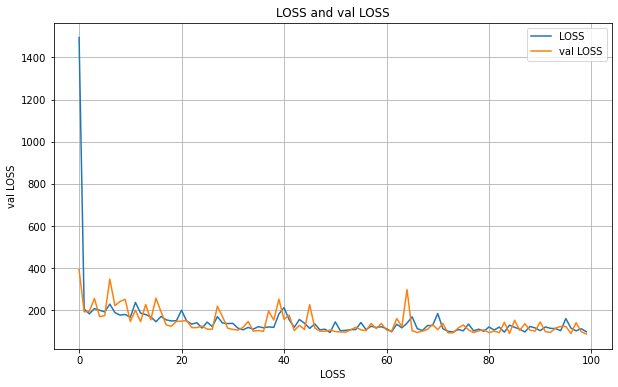

7/7 [==============================] - 0s 10ms/step


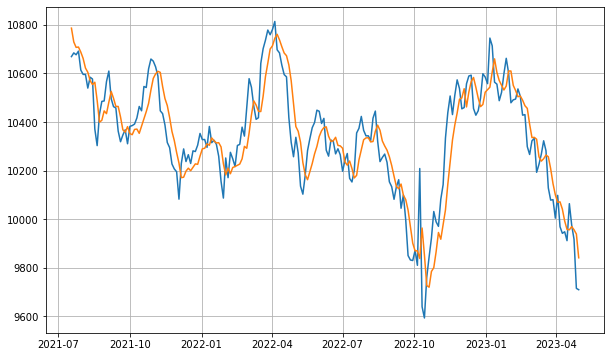

{'mae': 86.64702, 'mse': 11845.235, 'rmse': 108.835815, 'mape': 0.8404783, 'mase': 1.3960518}


<ipython-input-2-5c4b28aa2962>:6: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = pd.read_csv('./currency_data_10_years.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


Model: "2_model_CNY"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               5376      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 48,641
Trainable params: 48,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
     19/Unknown - 1s 3ms/step - loss: 2

INFO:tensorflow:Assets written to: saved_model/27\assets


INFO:tensorflow:Assets written to: saved_model/27\assets


31/31 [==============================] - 3s 47ms/step - loss: 215.5802 - mae: 216.0794 - val_loss: 22.7134 - val_mae: 23.2109
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 32.5571 - mae: 33.0536 - val_loss: 28.1439 - val_mae: 28.6414
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 52.0933 - mae: 52.5919 - val_loss: 53.4279 - val_mae: 53.9279
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 38.5589 - mae: 39.0571 - val_loss: 25.7307 - val_mae: 26.2264
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 28.4263 - mae: 28.9219 - val_loss: 55.2504 - val_mae: 55.7504
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 39.5425 - mae: 40.0404 - val_loss: 37.9088 - val_mae: 38.4052
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 35.1927 - mae: 35.6896 - val_loss: 23.1249 - val_mae: 23.6249
Epoch 8/100
19/31 [=================>............] - ETA: 0s - l

INFO:tensorflow:Assets written to: saved_model/27\assets


INFO:tensorflow:Assets written to: saved_model/27\assets


31/31 [==============================] - 1s 38ms/step - loss: 28.8363 - mae: 29.3312 - val_loss: 19.5898 - val_mae: 20.0862
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 27.1727 - mae: 27.6685 - val_loss: 55.5937 - val_mae: 56.0895
Epoch 10/100
20/31 [==================>...........] - ETA: 0s - loss: 39.2365 - mae: 39.7327

INFO:tensorflow:Assets written to: saved_model/27\assets


INFO:tensorflow:Assets written to: saved_model/27\assets


31/31 [==============================] - 1s 37ms/step - loss: 35.0910 - mae: 35.5876 - val_loss: 18.6449 - val_mae: 19.1391
Epoch 11/100
31/31 [==============================] - 0s 5ms/step - loss: 53.0494 - mae: 53.5473 - val_loss: 40.6901 - val_mae: 41.1858
Epoch 12/100
31/31 [==============================] - 0s 5ms/step - loss: 43.9335 - mae: 44.4303 - val_loss: 34.3583 - val_mae: 34.8541
Epoch 13/100
31/31 [==============================] - 0s 5ms/step - loss: 32.7132 - mae: 33.2093 - val_loss: 18.8563 - val_mae: 19.3525
Epoch 14/100
31/31 [==============================] - 0s 5ms/step - loss: 23.7452 - mae: 24.2377 - val_loss: 37.1783 - val_mae: 37.6739
Epoch 15/100
31/31 [==============================] - 0s 5ms/step - loss: 24.9741 - mae: 25.4690 - val_loss: 22.1533 - val_mae: 22.6480
Epoch 16/100
31/31 [==============================] - 0s 5ms/step - loss: 34.0303 - mae: 34.5268 - val_loss: 64.2254 - val_mae: 64.7254
Epoch 17/100
31/31 [==============================] - 0s 5ms

INFO:tensorflow:Assets written to: saved_model/27\assets


INFO:tensorflow:Assets written to: saved_model/27\assets


31/31 [==============================] - 1s 38ms/step - loss: 25.4766 - mae: 25.9698 - val_loss: 16.9068 - val_mae: 17.3989
Epoch 19/100
31/31 [==============================] - 0s 5ms/step - loss: 31.0844 - mae: 31.5827 - val_loss: 27.4659 - val_mae: 27.9643
Epoch 20/100
31/31 [==============================] - 0s 5ms/step - loss: 30.5485 - mae: 31.0463 - val_loss: 25.1435 - val_mae: 25.6419
Epoch 21/100
19/31 [=================>............] - ETA: 0s - loss: 33.8840 - mae: 34.3818

INFO:tensorflow:Assets written to: saved_model/27\assets


INFO:tensorflow:Assets written to: saved_model/27\assets


31/31 [==============================] - 2s 46ms/step - loss: 30.0032 - mae: 30.4992 - val_loss: 15.8072 - val_mae: 16.2960
Epoch 22/100
31/31 [==============================] - 0s 5ms/step - loss: 27.4831 - mae: 27.9813 - val_loss: 17.7008 - val_mae: 18.1981
Epoch 23/100
31/31 [==============================] - 0s 5ms/step - loss: 22.0072 - mae: 22.4987 - val_loss: 34.1770 - val_mae: 34.6753
Epoch 24/100
31/31 [==============================] - 0s 5ms/step - loss: 27.6375 - mae: 28.1320 - val_loss: 16.0669 - val_mae: 16.5643
Epoch 25/100
31/31 [==============================] - 0s 5ms/step - loss: 30.4304 - mae: 30.9273 - val_loss: 23.1842 - val_mae: 23.6835
Epoch 26/100
31/31 [==============================] - 0s 5ms/step - loss: 32.5285 - mae: 33.0267 - val_loss: 19.8834 - val_mae: 20.3800
Epoch 27/100
31/31 [==============================] - 0s 5ms/step - loss: 23.9966 - mae: 24.4925 - val_loss: 17.5887 - val_mae: 18.0832
Epoch 28/100
20/31 [==================>...........] - ETA: 0

INFO:tensorflow:Assets written to: saved_model/27\assets


INFO:tensorflow:Assets written to: saved_model/27\assets


31/31 [==============================] - 1s 39ms/step - loss: 22.6908 - mae: 23.1867 - val_loss: 15.2585 - val_mae: 15.7491
Epoch 29/100
31/31 [==============================] - 0s 5ms/step - loss: 20.4333 - mae: 20.9269 - val_loss: 33.3379 - val_mae: 33.8341
Epoch 30/100
20/31 [==================>...........] - ETA: 0s - loss: 26.1870 - mae: 26.6832

INFO:tensorflow:Assets written to: saved_model/27\assets


INFO:tensorflow:Assets written to: saved_model/27\assets


31/31 [==============================] - 1s 39ms/step - loss: 25.6065 - mae: 26.1030 - val_loss: 14.3011 - val_mae: 14.7991
Epoch 31/100
31/31 [==============================] - 0s 5ms/step - loss: 24.9860 - mae: 25.4828 - val_loss: 17.8335 - val_mae: 18.3321
Epoch 32/100
31/31 [==============================] - 0s 5ms/step - loss: 26.7390 - mae: 27.2356 - val_loss: 17.2179 - val_mae: 17.7141
Epoch 33/100
31/31 [==============================] - 0s 5ms/step - loss: 31.4440 - mae: 31.9405 - val_loss: 64.3545 - val_mae: 64.8545
Epoch 34/100
31/31 [==============================] - 0s 5ms/step - loss: 50.4210 - mae: 50.9205 - val_loss: 49.2750 - val_mae: 49.7750
Epoch 35/100
31/31 [==============================] - 0s 5ms/step - loss: 24.5484 - mae: 25.0445 - val_loss: 35.4043 - val_mae: 35.9043
Epoch 36/100
31/31 [==============================] - 0s 5ms/step - loss: 42.1181 - mae: 42.6173 - val_loss: 28.6520 - val_mae: 29.1520
Epoch 37/100
31/31 [==============================] - 0s 5ms

INFO:tensorflow:Assets written to: saved_model/27\assets


INFO:tensorflow:Assets written to: saved_model/27\assets


31/31 [==============================] - 1s 39ms/step - loss: 18.3998 - mae: 18.8942 - val_loss: 13.5509 - val_mae: 14.0317
Epoch 45/100
31/31 [==============================] - 0s 5ms/step - loss: 35.3880 - mae: 35.8862 - val_loss: 34.7405 - val_mae: 35.2393
Epoch 46/100
31/31 [==============================] - 0s 5ms/step - loss: 20.0373 - mae: 20.5309 - val_loss: 17.4850 - val_mae: 17.9822
Epoch 47/100
31/31 [==============================] - 0s 5ms/step - loss: 25.6890 - mae: 26.1855 - val_loss: 20.5496 - val_mae: 21.0478
Epoch 48/100
31/31 [==============================] - 0s 5ms/step - loss: 53.8150 - mae: 54.3125 - val_loss: 99.3866 - val_mae: 99.8866
Epoch 49/100
31/31 [==============================] - 0s 5ms/step - loss: 38.6248 - mae: 39.1229 - val_loss: 14.2963 - val_mae: 14.7912
Epoch 50/100
31/31 [==============================] - 0s 5ms/step - loss: 18.9299 - mae: 19.4241 - val_loss: 15.8404 - val_mae: 16.3349
Epoch 51/100
31/31 [==============================] - 0s 5ms

INFO:tensorflow:Assets written to: saved_model/27\assets


INFO:tensorflow:Assets written to: saved_model/27\assets


31/31 [==============================] - 1s 39ms/step - loss: 22.9118 - mae: 23.4051 - val_loss: 12.6242 - val_mae: 13.1154
Epoch 56/100
31/31 [==============================] - 0s 5ms/step - loss: 20.7229 - mae: 21.2169 - val_loss: 19.4825 - val_mae: 19.9750
Epoch 57/100
31/31 [==============================] - 0s 5ms/step - loss: 22.6800 - mae: 23.1772 - val_loss: 19.3413 - val_mae: 19.8352
Epoch 58/100
31/31 [==============================] - 0s 5ms/step - loss: 26.4110 - mae: 26.9094 - val_loss: 14.1366 - val_mae: 14.6292
Epoch 59/100
31/31 [==============================] - 0s 5ms/step - loss: 20.6403 - mae: 21.1335 - val_loss: 19.8121 - val_mae: 20.3042
Epoch 60/100
31/31 [==============================] - 0s 5ms/step - loss: 19.1932 - mae: 19.6861 - val_loss: 47.9563 - val_mae: 48.4563
Epoch 61/100
31/31 [==============================] - 0s 5ms/step - loss: 27.9832 - mae: 28.4808 - val_loss: 17.1317 - val_mae: 17.6301
Epoch 62/100
31/31 [==============================] - 0s 5ms

INFO:tensorflow:Assets written to: saved_model/27\assets


INFO:tensorflow:Assets written to: saved_model/27\assets


31/31 [==============================] - 1s 39ms/step - loss: 26.4077 - mae: 26.9049 - val_loss: 12.2157 - val_mae: 12.7041
Epoch 64/100
31/31 [==============================] - 0s 5ms/step - loss: 17.7037 - mae: 18.1971 - val_loss: 26.2295 - val_mae: 26.7271
Epoch 65/100
31/31 [==============================] - 0s 5ms/step - loss: 19.4137 - mae: 19.9088 - val_loss: 31.8692 - val_mae: 32.3648
Epoch 66/100
19/31 [=================>............] - ETA: 0s - loss: 26.3709 - mae: 26.8678

INFO:tensorflow:Assets written to: saved_model/27\assets


INFO:tensorflow:Assets written to: saved_model/27\assets


31/31 [==============================] - 2s 45ms/step - loss: 24.7938 - mae: 25.2904 - val_loss: 12.1694 - val_mae: 12.6519
Epoch 67/100
31/31 [==============================] - 0s 5ms/step - loss: 21.7560 - mae: 22.2515 - val_loss: 21.3387 - val_mae: 21.8352
Epoch 68/100
31/31 [==============================] - 0s 5ms/step - loss: 30.4404 - mae: 30.9352 - val_loss: 34.3399 - val_mae: 34.8376
Epoch 69/100
31/31 [==============================] - 0s 5ms/step - loss: 31.1947 - mae: 31.6937 - val_loss: 16.7702 - val_mae: 17.2603
Epoch 70/100
31/31 [==============================] - 0s 5ms/step - loss: 21.3004 - mae: 21.7958 - val_loss: 33.1831 - val_mae: 33.6801
Epoch 71/100
31/31 [==============================] - 0s 5ms/step - loss: 28.6507 - mae: 29.1483 - val_loss: 20.4062 - val_mae: 20.9046
Epoch 72/100
31/31 [==============================] - 0s 5ms/step - loss: 23.1274 - mae: 23.6224 - val_loss: 16.6735 - val_mae: 17.1710
Epoch 73/100
31/31 [==============================] - 0s 5ms

INFO:tensorflow:Assets written to: saved_model/27\assets


INFO:tensorflow:Assets written to: saved_model/27\assets


31/31 [==============================] - 1s 39ms/step - loss: 17.2864 - mae: 17.7789 - val_loss: 11.5975 - val_mae: 12.0886
Epoch 81/100
31/31 [==============================] - 0s 5ms/step - loss: 20.4847 - mae: 20.9771 - val_loss: 18.1952 - val_mae: 18.6878
Epoch 82/100
31/31 [==============================] - 0s 5ms/step - loss: 23.0980 - mae: 23.5946 - val_loss: 17.6117 - val_mae: 18.1049
Epoch 83/100
31/31 [==============================] - 0s 5ms/step - loss: 43.2884 - mae: 43.7873 - val_loss: 43.9643 - val_mae: 44.4643
Epoch 84/100
31/31 [==============================] - 0s 5ms/step - loss: 21.0395 - mae: 21.5356 - val_loss: 34.4546 - val_mae: 34.9543
Epoch 85/100
31/31 [==============================] - 0s 5ms/step - loss: 39.6012 - mae: 40.0993 - val_loss: 40.9441 - val_mae: 41.4431
Epoch 86/100
31/31 [==============================] - 0s 6ms/step - loss: 32.6855 - mae: 33.1816 - val_loss: 13.9512 - val_mae: 14.4504
Epoch 87/100
31/31 [==============================] - 0s 5ms

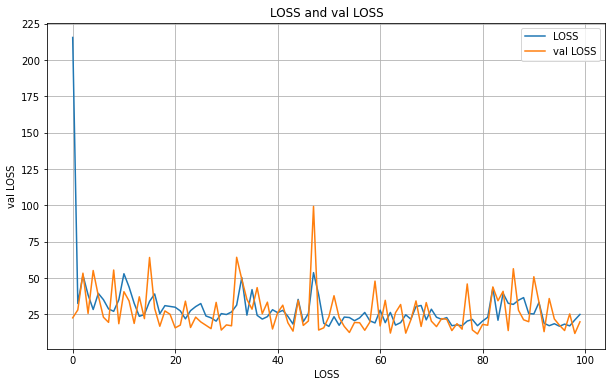

7/7 [==============================] - 0s 10ms/step


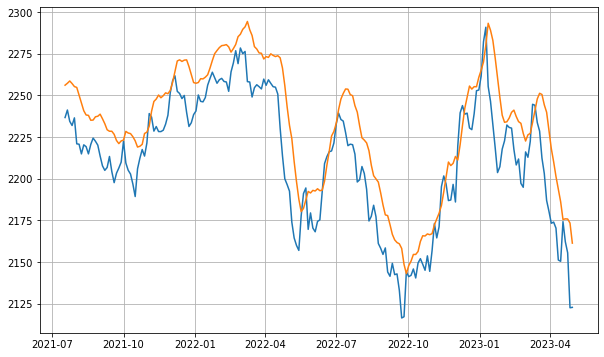

{'mae': 20.578049, 'mse': 587.32745, 'rmse': 24.23484, 'mape': 0.93327546, 'mase': 2.7720847}


<ipython-input-2-5c4b28aa2962>:6: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = pd.read_csv('./currency_data_10_years.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


Model: "2_model_CAD"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               5376      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 48,641
Trainable params: 48,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
     19/Unknown - 1s 3ms/step - loss: 1

INFO:tensorflow:Assets written to: saved_model/28\assets


INFO:tensorflow:Assets written to: saved_model/28\assets


31/31 [==============================] - 3s 47ms/step - loss: 907.1573 - mae: 907.6573 - val_loss: 166.8575 - val_mae: 167.3575
Epoch 2/100
19/31 [=================>............] - ETA: 0s - loss: 239.9975 - mae: 240.4975

INFO:tensorflow:Assets written to: saved_model/28\assets


INFO:tensorflow:Assets written to: saved_model/28\assets


31/31 [==============================] - 1s 40ms/step - loss: 233.8885 - mae: 234.3885 - val_loss: 147.8176 - val_mae: 148.3176
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 208.6389 - mae: 209.1384 - val_loss: 272.5249 - val_mae: 273.0249
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 201.6602 - mae: 202.1601 - val_loss: 213.4661 - val_mae: 213.9661
Epoch 5/100
20/31 [==================>...........] - ETA: 0s - loss: 215.0940 - mae: 215.5933

INFO:tensorflow:Assets written to: saved_model/28\assets


INFO:tensorflow:Assets written to: saved_model/28\assets


31/31 [==============================] - 1s 39ms/step - loss: 206.0043 - mae: 206.5034 - val_loss: 103.4326 - val_mae: 103.9319
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 204.7647 - mae: 205.2640 - val_loss: 279.0847 - val_mae: 279.5847
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 190.9763 - mae: 191.4754 - val_loss: 296.0853 - val_mae: 296.5853
Epoch 8/100
19/31 [=================>............] - ETA: 0s - loss: 173.7798 - mae: 174.2784

INFO:tensorflow:Assets written to: saved_model/28\assets


INFO:tensorflow:Assets written to: saved_model/28\assets


31/31 [==============================] - 2s 46ms/step - loss: 160.5500 - mae: 161.0486 - val_loss: 98.7132 - val_mae: 99.2103
Epoch 9/100
19/31 [=================>............] - ETA: 0s - loss: 187.6799 - mae: 188.1786

INFO:tensorflow:Assets written to: saved_model/28\assets


INFO:tensorflow:Assets written to: saved_model/28\assets


31/31 [==============================] - 1s 42ms/step - loss: 179.1691 - mae: 179.6682 - val_loss: 93.6109 - val_mae: 94.1061
Epoch 10/100
31/31 [==============================] - 0s 5ms/step - loss: 169.4677 - mae: 169.9664 - val_loss: 154.7380 - val_mae: 155.2371
Epoch 11/100
31/31 [==============================] - 0s 5ms/step - loss: 178.5950 - mae: 179.0948 - val_loss: 292.8081 - val_mae: 293.3081
Epoch 12/100
31/31 [==============================] - 0s 5ms/step - loss: 168.9414 - mae: 169.4410 - val_loss: 210.5613 - val_mae: 211.0613
Epoch 13/100
31/31 [==============================] - 0s 5ms/step - loss: 225.3930 - mae: 225.8921 - val_loss: 333.9341 - val_mae: 334.4341
Epoch 14/100
31/31 [==============================] - 0s 5ms/step - loss: 164.1358 - mae: 164.6353 - val_loss: 275.8915 - val_mae: 276.3915
Epoch 15/100
31/31 [==============================] - 0s 5ms/step - loss: 153.8570 - mae: 154.3565 - val_loss: 104.9309 - val_mae: 105.4301
Epoch 16/100
31/31 [==============

INFO:tensorflow:Assets written to: saved_model/28\assets


INFO:tensorflow:Assets written to: saved_model/28\assets


31/31 [==============================] - 1s 39ms/step - loss: 200.0436 - mae: 200.5435 - val_loss: 89.9035 - val_mae: 90.4028
Epoch 24/100
31/31 [==============================] - 0s 5ms/step - loss: 177.8749 - mae: 178.3743 - val_loss: 112.1449 - val_mae: 112.6449
Epoch 25/100
19/31 [=================>............] - ETA: 0s - loss: 119.6440 - mae: 120.1428

INFO:tensorflow:Assets written to: saved_model/28\assets


INFO:tensorflow:Assets written to: saved_model/28\assets


31/31 [==============================] - 1s 40ms/step - loss: 134.9429 - mae: 135.4421 - val_loss: 79.6237 - val_mae: 80.1216
Epoch 26/100
31/31 [==============================] - 0s 5ms/step - loss: 141.8996 - mae: 142.3992 - val_loss: 85.3212 - val_mae: 85.8207
Epoch 27/100
31/31 [==============================] - 0s 5ms/step - loss: 128.6940 - mae: 129.1920 - val_loss: 90.6081 - val_mae: 91.1081
Epoch 28/100
31/31 [==============================] - 0s 5ms/step - loss: 158.1364 - mae: 158.6355 - val_loss: 121.2921 - val_mae: 121.7920
Epoch 29/100
31/31 [==============================] - 0s 5ms/step - loss: 189.2468 - mae: 189.7468 - val_loss: 86.9629 - val_mae: 87.4596
Epoch 30/100
31/31 [==============================] - 0s 5ms/step - loss: 134.6734 - mae: 135.1720 - val_loss: 99.1150 - val_mae: 99.6150
Epoch 31/100
31/31 [==============================] - 0s 5ms/step - loss: 123.6000 - mae: 124.0981 - val_loss: 86.6151 - val_mae: 87.1151
Epoch 32/100
31/31 [========================

INFO:tensorflow:Assets written to: saved_model/28\assets


INFO:tensorflow:Assets written to: saved_model/28\assets


31/31 [==============================] - 1s 39ms/step - loss: 152.1451 - mae: 152.6448 - val_loss: 74.6451 - val_mae: 75.1444
Epoch 47/100
31/31 [==============================] - 0s 5ms/step - loss: 122.8698 - mae: 123.3686 - val_loss: 176.3689 - val_mae: 176.8689
Epoch 48/100
31/31 [==============================] - 0s 5ms/step - loss: 108.0093 - mae: 108.5086 - val_loss: 111.4101 - val_mae: 111.9096
Epoch 49/100
31/31 [==============================] - 0s 5ms/step - loss: 158.0635 - mae: 158.5629 - val_loss: 76.7994 - val_mae: 77.2994
Epoch 50/100
31/31 [==============================] - 0s 5ms/step - loss: 103.2359 - mae: 103.7328 - val_loss: 139.9678 - val_mae: 140.4664
Epoch 51/100
31/31 [==============================] - 0s 5ms/step - loss: 116.9055 - mae: 117.4052 - val_loss: 82.1980 - val_mae: 82.6978
Epoch 52/100
31/31 [==============================] - 0s 5ms/step - loss: 146.5999 - mae: 147.0976 - val_loss: 350.7380 - val_mae: 351.2380
Epoch 53/100
31/31 [==================

INFO:tensorflow:Assets written to: saved_model/28\assets


INFO:tensorflow:Assets written to: saved_model/28\assets


31/31 [==============================] - 1s 39ms/step - loss: 118.5196 - mae: 119.0183 - val_loss: 70.2519 - val_mae: 70.7496
Epoch 70/100
31/31 [==============================] - 0s 5ms/step - loss: 124.7890 - mae: 125.2886 - val_loss: 218.3949 - val_mae: 218.8949
Epoch 71/100
31/31 [==============================] - 0s 5ms/step - loss: 116.2838 - mae: 116.7821 - val_loss: 73.5645 - val_mae: 74.0645
Epoch 72/100
31/31 [==============================] - 0s 5ms/step - loss: 112.6908 - mae: 113.1895 - val_loss: 120.6077 - val_mae: 121.1070
Epoch 73/100
31/31 [==============================] - 0s 5ms/step - loss: 120.4723 - mae: 120.9720 - val_loss: 196.8813 - val_mae: 197.3794
Epoch 74/100
19/31 [=================>............] - ETA: 0s - loss: 116.9073 - mae: 117.4065

INFO:tensorflow:Assets written to: saved_model/28\assets


INFO:tensorflow:Assets written to: saved_model/28\assets


31/31 [==============================] - 2s 46ms/step - loss: 117.5532 - mae: 118.0526 - val_loss: 67.1145 - val_mae: 67.6101
Epoch 75/100
31/31 [==============================] - 0s 5ms/step - loss: 92.3811 - mae: 92.8798 - val_loss: 141.4634 - val_mae: 141.9628
Epoch 76/100
31/31 [==============================] - 0s 5ms/step - loss: 129.1294 - mae: 129.6287 - val_loss: 83.2885 - val_mae: 83.7864
Epoch 77/100
31/31 [==============================] - 0s 5ms/step - loss: 116.2593 - mae: 116.7588 - val_loss: 75.2268 - val_mae: 75.7268
Epoch 78/100
31/31 [==============================] - 0s 5ms/step - loss: 107.8490 - mae: 108.3479 - val_loss: 178.2663 - val_mae: 178.7663
Epoch 79/100
19/31 [=================>............] - ETA: 0s - loss: 138.2098 - mae: 138.7090

INFO:tensorflow:Assets written to: saved_model/28\assets


INFO:tensorflow:Assets written to: saved_model/28\assets


31/31 [==============================] - 1s 39ms/step - loss: 123.3451 - mae: 123.8447 - val_loss: 66.0893 - val_mae: 66.5890
Epoch 80/100
31/31 [==============================] - 0s 5ms/step - loss: 105.5111 - mae: 106.0106 - val_loss: 68.4996 - val_mae: 68.9981
Epoch 81/100
31/31 [==============================] - 0s 5ms/step - loss: 174.9999 - mae: 175.4997 - val_loss: 285.5980 - val_mae: 286.0980
Epoch 82/100
31/31 [==============================] - 0s 5ms/step - loss: 119.0682 - mae: 119.5680 - val_loss: 228.2462 - val_mae: 228.7462
Epoch 83/100
31/31 [==============================] - 0s 5ms/step - loss: 145.7776 - mae: 146.2776 - val_loss: 134.0721 - val_mae: 134.5705
Epoch 84/100
31/31 [==============================] - 0s 5ms/step - loss: 116.0868 - mae: 116.5851 - val_loss: 276.4535 - val_mae: 276.9535
Epoch 85/100
31/31 [==============================] - 0s 5ms/step - loss: 115.2941 - mae: 115.7927 - val_loss: 97.8098 - val_mae: 98.3059
Epoch 86/100
31/31 [==================

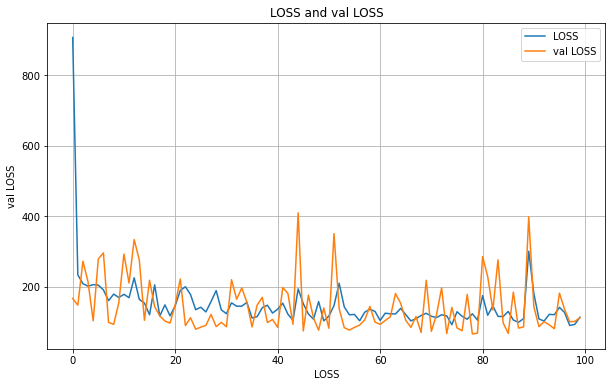

7/7 [==============================] - 0s 10ms/step


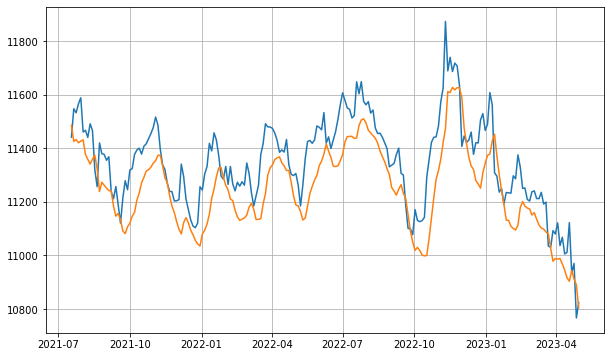

{'mae': 111.24734, 'mse': 17387.719, 'rmse': 131.8625, 'mape': 0.97713256, 'mase': 2.3411677}


<ipython-input-2-5c4b28aa2962>:6: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = pd.read_csv('./currency_data_10_years.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


Model: "2_model_MYR"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               5376      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 48,641
Trainable params: 48,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
     19/Unknown - 1s 3ms/step - loss: 5

INFO:tensorflow:Assets written to: saved_model/29\assets


INFO:tensorflow:Assets written to: saved_model/29\assets


31/31 [==============================] - 3s 48ms/step - loss: 438.5972 - mae: 439.0971 - val_loss: 48.7243 - val_mae: 49.2233
Epoch 2/100
19/31 [=================>............] - ETA: 0s - loss: 97.0613 - mae: 97.5591

INFO:tensorflow:Assets written to: saved_model/29\assets


INFO:tensorflow:Assets written to: saved_model/29\assets


31/31 [==============================] - 1s 40ms/step - loss: 84.1030 - mae: 84.6011 - val_loss: 33.7682 - val_mae: 34.2612
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 49.2059 - mae: 49.7035 - val_loss: 46.1778 - val_mae: 46.6778
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 54.0241 - mae: 54.5226 - val_loss: 82.6858 - val_mae: 83.1859
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 59.2084 - mae: 59.7061 - val_loss: 47.7094 - val_mae: 48.2094
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 66.1048 - mae: 66.6034 - val_loss: 69.6838 - val_mae: 70.1838
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 61.9976 - mae: 62.4951 - val_loss: 81.0159 - val_mae: 81.5159
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 73.0307 - mae: 73.5291 - val_loss: 90.7241 - val_mae: 91.2231
Epoch 9/100
31/31 [==============================] - 0s 5ms/step -

INFO:tensorflow:Assets written to: saved_model/29\assets


INFO:tensorflow:Assets written to: saved_model/29\assets


31/31 [==============================] - 1s 38ms/step - loss: 53.6942 - mae: 54.1924 - val_loss: 26.2136 - val_mae: 26.7025
Epoch 14/100
20/31 [==================>...........] - ETA: 0s - loss: 46.0311 - mae: 46.5292

INFO:tensorflow:Assets written to: saved_model/29\assets


INFO:tensorflow:Assets written to: saved_model/29\assets


31/31 [==============================] - 2s 45ms/step - loss: 47.9571 - mae: 48.4549 - val_loss: 25.3785 - val_mae: 25.8727
Epoch 15/100
31/31 [==============================] - 0s 5ms/step - loss: 44.9931 - mae: 45.4896 - val_loss: 30.9904 - val_mae: 31.4860
Epoch 16/100
31/31 [==============================] - 0s 5ms/step - loss: 52.9269 - mae: 53.4228 - val_loss: 63.9193 - val_mae: 64.4183
Epoch 17/100
31/31 [==============================] - 0s 5ms/step - loss: 47.5712 - mae: 48.0690 - val_loss: 55.6638 - val_mae: 56.1622
Epoch 18/100
31/31 [==============================] - 0s 5ms/step - loss: 39.6743 - mae: 40.1720 - val_loss: 50.5787 - val_mae: 51.0771
Epoch 19/100
18/31 [================>.............] - ETA: 0s - loss: 41.4192 - mae: 41.9163

INFO:tensorflow:Assets written to: saved_model/29\assets


INFO:tensorflow:Assets written to: saved_model/29\assets


31/31 [==============================] - 1s 38ms/step - loss: 45.5325 - mae: 46.0306 - val_loss: 25.3100 - val_mae: 25.8046
Epoch 20/100
31/31 [==============================] - ETA: 0s - loss: 39.3505 - mae: 39.8492

INFO:tensorflow:Assets written to: saved_model/29\assets


INFO:tensorflow:Assets written to: saved_model/29\assets


31/31 [==============================] - 1s 40ms/step - loss: 39.3505 - mae: 39.8492 - val_loss: 23.4533 - val_mae: 23.9490
Epoch 21/100
31/31 [==============================] - 0s 5ms/step - loss: 41.1445 - mae: 41.6421 - val_loss: 34.5458 - val_mae: 35.0436
Epoch 22/100
31/31 [==============================] - 0s 5ms/step - loss: 44.4339 - mae: 44.9318 - val_loss: 28.3234 - val_mae: 28.8208
Epoch 23/100
31/31 [==============================] - 0s 5ms/step - loss: 46.2681 - mae: 46.7669 - val_loss: 44.6398 - val_mae: 45.1372
Epoch 24/100
31/31 [==============================] - 0s 5ms/step - loss: 47.9246 - mae: 48.4230 - val_loss: 29.6152 - val_mae: 30.1116
Epoch 25/100
31/31 [==============================] - 0s 5ms/step - loss: 45.5982 - mae: 46.0971 - val_loss: 80.2746 - val_mae: 80.7746
Epoch 26/100
31/31 [==============================] - 0s 5ms/step - loss: 48.2192 - mae: 48.7178 - val_loss: 25.1107 - val_mae: 25.6033
Epoch 27/100
31/31 [==============================] - 0s 5ms

INFO:tensorflow:Assets written to: saved_model/29\assets


INFO:tensorflow:Assets written to: saved_model/29\assets


31/31 [==============================] - 2s 46ms/step - loss: 41.3288 - mae: 41.8255 - val_loss: 21.3745 - val_mae: 21.8711
Epoch 31/100
31/31 [==============================] - 0s 5ms/step - loss: 37.3924 - mae: 37.8889 - val_loss: 36.5446 - val_mae: 37.0420
Epoch 32/100
31/31 [==============================] - 0s 5ms/step - loss: 31.6401 - mae: 32.1364 - val_loss: 24.6517 - val_mae: 25.1473
Epoch 33/100
31/31 [==============================] - 0s 5ms/step - loss: 36.1580 - mae: 36.6559 - val_loss: 33.8524 - val_mae: 34.3516
Epoch 34/100
31/31 [==============================] - 0s 5ms/step - loss: 35.5507 - mae: 36.0480 - val_loss: 24.5989 - val_mae: 25.0942
Epoch 35/100
31/31 [==============================] - 0s 5ms/step - loss: 41.9135 - mae: 42.4123 - val_loss: 37.0552 - val_mae: 37.5542
Epoch 36/100
31/31 [==============================] - 0s 5ms/step - loss: 41.9163 - mae: 42.4147 - val_loss: 44.6528 - val_mae: 45.1496
Epoch 37/100
31/31 [==============================] - 0s 5ms

INFO:tensorflow:Assets written to: saved_model/29\assets


INFO:tensorflow:Assets written to: saved_model/29\assets


31/31 [==============================] - 1s 39ms/step - loss: 33.8297 - mae: 34.3278 - val_loss: 20.1054 - val_mae: 20.5987
Epoch 42/100
18/31 [================>.............] - ETA: 0s - loss: 38.0648 - mae: 38.5620

INFO:tensorflow:Assets written to: saved_model/29\assets


INFO:tensorflow:Assets written to: saved_model/29\assets


31/31 [==============================] - 1s 45ms/step - loss: 35.6068 - mae: 36.1030 - val_loss: 19.1152 - val_mae: 19.6066
Epoch 43/100
31/31 [==============================] - 0s 5ms/step - loss: 40.2667 - mae: 40.7646 - val_loss: 36.1534 - val_mae: 36.6508
Epoch 44/100
19/31 [=================>............] - ETA: 0s - loss: 35.2198 - mae: 35.7165

INFO:tensorflow:Assets written to: saved_model/29\assets


INFO:tensorflow:Assets written to: saved_model/29\assets


31/31 [==============================] - 1s 39ms/step - loss: 34.5291 - mae: 35.0260 - val_loss: 18.8230 - val_mae: 19.3172
Epoch 45/100
31/31 [==============================] - 0s 5ms/step - loss: 54.5286 - mae: 55.0276 - val_loss: 47.3075 - val_mae: 47.8070
Epoch 46/100
31/31 [==============================] - 0s 5ms/step - loss: 42.8823 - mae: 43.3794 - val_loss: 20.1045 - val_mae: 20.6034
Epoch 47/100
31/31 [==============================] - 0s 5ms/step - loss: 32.3640 - mae: 32.8609 - val_loss: 37.9624 - val_mae: 38.4612
Epoch 48/100
19/31 [=================>............] - ETA: 0s - loss: 47.9593 - mae: 48.4572

INFO:tensorflow:Assets written to: saved_model/29\assets


INFO:tensorflow:Assets written to: saved_model/29\assets


31/31 [==============================] - 1s 39ms/step - loss: 41.4755 - mae: 41.9726 - val_loss: 18.1876 - val_mae: 18.6813
Epoch 49/100
31/31 [==============================] - 0s 5ms/step - loss: 39.4327 - mae: 39.9304 - val_loss: 53.0848 - val_mae: 53.5848
Epoch 50/100
31/31 [==============================] - 0s 5ms/step - loss: 31.2506 - mae: 31.7487 - val_loss: 19.0818 - val_mae: 19.5756
Epoch 51/100
31/31 [==============================] - 0s 5ms/step - loss: 35.6738 - mae: 36.1708 - val_loss: 64.7761 - val_mae: 65.2759
Epoch 52/100
31/31 [==============================] - 0s 5ms/step - loss: 53.1172 - mae: 53.6152 - val_loss: 55.8063 - val_mae: 56.3042
Epoch 53/100
31/31 [==============================] - 0s 5ms/step - loss: 72.6788 - mae: 73.1780 - val_loss: 61.0825 - val_mae: 61.5825
Epoch 54/100
31/31 [==============================] - 0s 5ms/step - loss: 33.9904 - mae: 34.4868 - val_loss: 50.5301 - val_mae: 51.0265
Epoch 55/100
31/31 [==============================] - 0s 5ms

INFO:tensorflow:Assets written to: saved_model/29\assets


INFO:tensorflow:Assets written to: saved_model/29\assets


31/31 [==============================] - 1s 39ms/step - loss: 31.4617 - mae: 31.9592 - val_loss: 17.0788 - val_mae: 17.5766
Epoch 92/100
31/31 [==============================] - 0s 5ms/step - loss: 37.4616 - mae: 37.9598 - val_loss: 68.2297 - val_mae: 68.7297
Epoch 93/100
31/31 [==============================] - 0s 5ms/step - loss: 34.6739 - mae: 35.1704 - val_loss: 38.3035 - val_mae: 38.7997
Epoch 94/100
31/31 [==============================] - 0s 5ms/step - loss: 36.2389 - mae: 36.7362 - val_loss: 17.8333 - val_mae: 18.3232
Epoch 95/100
31/31 [==============================] - 0s 5ms/step - loss: 46.2123 - mae: 46.7105 - val_loss: 74.8915 - val_mae: 75.3904
Epoch 96/100
31/31 [==============================] - 0s 5ms/step - loss: 68.1078 - mae: 68.6075 - val_loss: 47.9822 - val_mae: 48.4812
Epoch 97/100
31/31 [==============================] - 0s 5ms/step - loss: 63.8173 - mae: 64.3163 - val_loss: 60.2389 - val_mae: 60.7389
Epoch 98/100
31/31 [==============================] - 0s 5ms

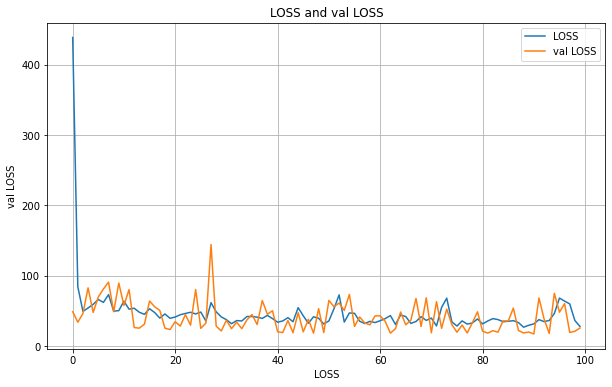

7/7 [==============================] - 0s 9ms/step


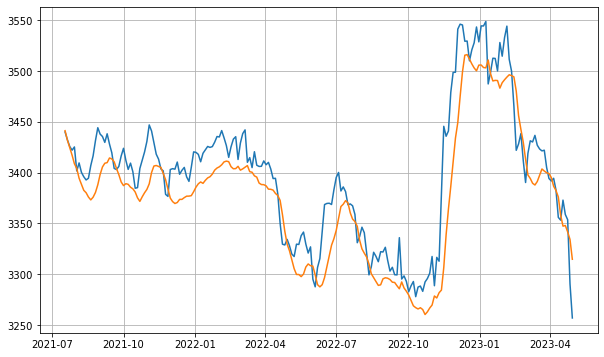

{'mae': 25.554602, 'mse': 1062.8959, 'rmse': 32.602085, 'mape': 0.74940926, 'mase': 2.252871}


<ipython-input-2-5c4b28aa2962>:6: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = pd.read_csv('./currency_data_10_years.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


Model: "2_model_RUB"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               5376      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 48,641
Trainable params: 48,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
     18/Unknown - 1s 3ms/step - loss: 4

INFO:tensorflow:Assets written to: saved_model/30\assets


INFO:tensorflow:Assets written to: saved_model/30\assets


31/31 [==============================] - 3s 48ms/step - loss: 31.0812 - mae: 31.5747 - val_loss: 18.1139 - val_mae: 18.6139
Epoch 2/100
18/31 [================>.............] - ETA: 0s - loss: 8.3882 - mae: 8.8739  

INFO:tensorflow:Assets written to: saved_model/30\assets


INFO:tensorflow:Assets written to: saved_model/30\assets


31/31 [==============================] - 2s 48ms/step - loss: 7.9582 - mae: 8.4398 - val_loss: 13.8362 - val_mae: 14.3203
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 6.4627 - mae: 6.9375 - val_loss: 14.5567 - val_mae: 15.0513
Epoch 4/100
19/31 [=================>............] - ETA: 0s - loss: 7.3754 - mae: 7.8593

INFO:tensorflow:Assets written to: saved_model/30\assets


INFO:tensorflow:Assets written to: saved_model/30\assets


31/31 [==============================] - 1s 39ms/step - loss: 7.0323 - mae: 7.5155 - val_loss: 12.4773 - val_mae: 12.9668
Epoch 5/100
19/31 [=================>............] - ETA: 0s - loss: 5.7180 - mae: 6.1949

INFO:tensorflow:Assets written to: saved_model/30\assets


INFO:tensorflow:Assets written to: saved_model/30\assets


31/31 [==============================] - 1s 39ms/step - loss: 5.4588 - mae: 5.9366 - val_loss: 11.3707 - val_mae: 11.8589
Epoch 6/100
19/31 [=================>............] - ETA: 0s - loss: 5.3572 - mae: 5.8419

INFO:tensorflow:Assets written to: saved_model/30\assets


INFO:tensorflow:Assets written to: saved_model/30\assets


31/31 [==============================] - 1s 40ms/step - loss: 5.0906 - mae: 5.5733 - val_loss: 9.6108 - val_mae: 10.0914
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 5.5056 - mae: 5.9879 - val_loss: 12.2084 - val_mae: 12.6998
Epoch 8/100
18/31 [================>.............] - ETA: 0s - loss: 6.3128 - mae: 6.7971

INFO:tensorflow:Assets written to: saved_model/30\assets


INFO:tensorflow:Assets written to: saved_model/30\assets


31/31 [==============================] - 1s 44ms/step - loss: 5.9887 - mae: 6.4730 - val_loss: 9.5121 - val_mae: 9.9834
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 7.0950 - mae: 7.5772 - val_loss: 10.0647 - val_mae: 10.5413
Epoch 10/100
19/31 [=================>............] - ETA: 0s - loss: 3.9534 - mae: 4.4260

INFO:tensorflow:Assets written to: saved_model/30\assets


INFO:tensorflow:Assets written to: saved_model/30\assets


31/31 [==============================] - 1s 39ms/step - loss: 3.8808 - mae: 4.3515 - val_loss: 9.4192 - val_mae: 9.9086
Epoch 11/100
19/31 [=================>............] - ETA: 0s - loss: 3.3962 - mae: 3.8698

INFO:tensorflow:Assets written to: saved_model/30\assets


INFO:tensorflow:Assets written to: saved_model/30\assets


31/31 [==============================] - 2s 47ms/step - loss: 3.6942 - mae: 4.1689 - val_loss: 8.8055 - val_mae: 9.2912
Epoch 12/100
31/31 [==============================] - 0s 5ms/step - loss: 3.4715 - mae: 3.9422 - val_loss: 8.9321 - val_mae: 9.4260
Epoch 13/100
31/31 [==============================] - 0s 5ms/step - loss: 4.3454 - mae: 4.8223 - val_loss: 10.9202 - val_mae: 11.4137
Epoch 14/100
31/31 [==============================] - 0s 5ms/step - loss: 4.7372 - mae: 5.2167 - val_loss: 10.5807 - val_mae: 11.0729
Epoch 15/100
19/31 [=================>............] - ETA: 0s - loss: 5.2831 - mae: 5.7719

INFO:tensorflow:Assets written to: saved_model/30\assets


INFO:tensorflow:Assets written to: saved_model/30\assets


31/31 [==============================] - 1s 39ms/step - loss: 4.9302 - mae: 5.4167 - val_loss: 8.7996 - val_mae: 9.2620
Epoch 16/100
31/31 [==============================] - 0s 5ms/step - loss: 3.2916 - mae: 3.7591 - val_loss: 10.1334 - val_mae: 10.6261
Epoch 17/100
31/31 [==============================] - 0s 5ms/step - loss: 3.9165 - mae: 4.3897 - val_loss: 8.8556 - val_mae: 9.3432
Epoch 18/100
31/31 [==============================] - 0s 5ms/step - loss: 3.0655 - mae: 3.5303 - val_loss: 9.1175 - val_mae: 9.6004
Epoch 19/100
31/31 [==============================] - 0s 5ms/step - loss: 3.5840 - mae: 4.0572 - val_loss: 9.0337 - val_mae: 9.5214
Epoch 20/100
19/31 [=================>............] - ETA: 0s - loss: 3.6228 - mae: 4.0974

INFO:tensorflow:Assets written to: saved_model/30\assets


INFO:tensorflow:Assets written to: saved_model/30\assets


31/31 [==============================] - 1s 39ms/step - loss: 3.4939 - mae: 3.9699 - val_loss: 8.3591 - val_mae: 8.8341
Epoch 21/100
31/31 [==============================] - 0s 5ms/step - loss: 3.8111 - mae: 4.2879 - val_loss: 10.7207 - val_mae: 11.2134
Epoch 22/100
31/31 [==============================] - 0s 5ms/step - loss: 3.9094 - mae: 4.3892 - val_loss: 9.7902 - val_mae: 10.2815
Epoch 23/100
31/31 [==============================] - 0s 5ms/step - loss: 4.5699 - mae: 5.0498 - val_loss: 8.6059 - val_mae: 9.0948
Epoch 24/100
31/31 [==============================] - 0s 5ms/step - loss: 4.0578 - mae: 4.5278 - val_loss: 8.4482 - val_mae: 8.9338
Epoch 25/100
19/31 [=================>............] - ETA: 0s - loss: 3.6854 - mae: 4.1566

INFO:tensorflow:Assets written to: saved_model/30\assets


INFO:tensorflow:Assets written to: saved_model/30\assets


31/31 [==============================] - 1s 39ms/step - loss: 3.4602 - mae: 3.9313 - val_loss: 8.2891 - val_mae: 8.7755
Epoch 26/100
19/31 [=================>............] - ETA: 0s - loss: 2.9943 - mae: 3.4547

INFO:tensorflow:Assets written to: saved_model/30\assets


INFO:tensorflow:Assets written to: saved_model/30\assets


31/31 [==============================] - 1s 39ms/step - loss: 3.3984 - mae: 3.8670 - val_loss: 8.0133 - val_mae: 8.4929
Epoch 27/100
31/31 [==============================] - 0s 5ms/step - loss: 4.4349 - mae: 4.9163 - val_loss: 9.9198 - val_mae: 10.4133
Epoch 28/100
31/31 [==============================] - 0s 5ms/step - loss: 3.7462 - mae: 4.2222 - val_loss: 8.6807 - val_mae: 9.1617
Epoch 29/100
31/31 [==============================] - 0s 5ms/step - loss: 3.0105 - mae: 3.4759 - val_loss: 8.3274 - val_mae: 8.8040
Epoch 30/100
31/31 [==============================] - 0s 5ms/step - loss: 3.0852 - mae: 3.5479 - val_loss: 8.2075 - val_mae: 8.6862
Epoch 31/100
19/31 [=================>............] - ETA: 0s - loss: 3.5590 - mae: 4.0335

INFO:tensorflow:Assets written to: saved_model/30\assets


INFO:tensorflow:Assets written to: saved_model/30\assets


31/31 [==============================] - 2s 45ms/step - loss: 3.3077 - mae: 3.7808 - val_loss: 7.8695 - val_mae: 8.3470
Epoch 32/100
17/31 [===============>..............] - ETA: 0s - loss: 2.5105 - mae: 2.9658

INFO:tensorflow:Assets written to: saved_model/30\assets


INFO:tensorflow:Assets written to: saved_model/30\assets


31/31 [==============================] - 2s 46ms/step - loss: 2.5096 - mae: 2.9642 - val_loss: 7.7333 - val_mae: 8.1946
Epoch 33/100
31/31 [==============================] - 0s 5ms/step - loss: 2.7330 - mae: 3.1927 - val_loss: 8.6895 - val_mae: 9.1771
Epoch 34/100
31/31 [==============================] - 0s 5ms/step - loss: 4.0485 - mae: 4.5258 - val_loss: 9.5905 - val_mae: 10.0807
Epoch 35/100
31/31 [==============================] - 0s 5ms/step - loss: 4.1960 - mae: 4.6799 - val_loss: 8.0461 - val_mae: 8.5259
Epoch 36/100
31/31 [==============================] - 0s 5ms/step - loss: 3.8142 - mae: 4.2912 - val_loss: 8.8184 - val_mae: 9.3070
Epoch 37/100
31/31 [==============================] - 0s 5ms/step - loss: 3.0982 - mae: 3.5691 - val_loss: 7.9702 - val_mae: 8.4517
Epoch 38/100
31/31 [==============================] - 0s 5ms/step - loss: 4.1066 - mae: 4.5845 - val_loss: 9.4388 - val_mae: 9.9285
Epoch 39/100
31/31 [==============================] - 0s 5ms/step - loss: 4.0939 - mae:

INFO:tensorflow:Assets written to: saved_model/30\assets


INFO:tensorflow:Assets written to: saved_model/30\assets


31/31 [==============================] - 1s 42ms/step - loss: 3.4553 - mae: 3.9235 - val_loss: 7.4837 - val_mae: 7.9552
Epoch 51/100
31/31 [==============================] - 0s 5ms/step - loss: 3.6367 - mae: 4.1112 - val_loss: 8.0018 - val_mae: 8.4847
Epoch 52/100
19/31 [=================>............] - ETA: 0s - loss: 2.9826 - mae: 3.4525

INFO:tensorflow:Assets written to: saved_model/30\assets


INFO:tensorflow:Assets written to: saved_model/30\assets


31/31 [==============================] - 1s 42ms/step - loss: 2.7691 - mae: 3.2336 - val_loss: 7.4610 - val_mae: 7.9378
Epoch 53/100
31/31 [==============================] - 0s 5ms/step - loss: 2.9728 - mae: 3.4439 - val_loss: 8.1118 - val_mae: 8.6016
Epoch 54/100
31/31 [==============================] - 0s 5ms/step - loss: 3.2705 - mae: 3.7432 - val_loss: 7.4974 - val_mae: 7.9695
Epoch 55/100
31/31 [==============================] - 0s 5ms/step - loss: 2.9121 - mae: 3.3749 - val_loss: 8.3151 - val_mae: 8.8067
Epoch 56/100
31/31 [==============================] - 0s 5ms/step - loss: 3.5885 - mae: 4.0677 - val_loss: 8.6514 - val_mae: 9.1364
Epoch 57/100
31/31 [==============================] - 0s 5ms/step - loss: 4.9753 - mae: 5.4597 - val_loss: 7.6997 - val_mae: 8.1777
Epoch 58/100
31/31 [==============================] - 0s 5ms/step - loss: 3.3557 - mae: 3.8254 - val_loss: 7.5911 - val_mae: 8.0740
Epoch 59/100
20/31 [==================>...........] - ETA: 0s - loss: 2.5695 - mae: 3.03

INFO:tensorflow:Assets written to: saved_model/30\assets


INFO:tensorflow:Assets written to: saved_model/30\assets


31/31 [==============================] - 1s 39ms/step - loss: 2.5003 - mae: 2.9565 - val_loss: 7.2901 - val_mae: 7.7555
Epoch 60/100
19/31 [=================>............] - ETA: 0s - loss: 2.8422 - mae: 3.3091

INFO:tensorflow:Assets written to: saved_model/30\assets


INFO:tensorflow:Assets written to: saved_model/30\assets


31/31 [==============================] - 1s 40ms/step - loss: 2.6926 - mae: 3.1569 - val_loss: 7.2567 - val_mae: 7.7197
Epoch 61/100
31/31 [==============================] - 0s 5ms/step - loss: 2.9712 - mae: 3.4358 - val_loss: 7.4612 - val_mae: 7.9386
Epoch 62/100
31/31 [==============================] - 0s 5ms/step - loss: 3.3800 - mae: 3.8485 - val_loss: 7.8065 - val_mae: 8.2912
Epoch 63/100
31/31 [==============================] - 0s 5ms/step - loss: 2.8986 - mae: 3.3676 - val_loss: 8.0667 - val_mae: 8.5540
Epoch 64/100
19/31 [=================>............] - ETA: 0s - loss: 2.8063 - mae: 3.2695

INFO:tensorflow:Assets written to: saved_model/30\assets


INFO:tensorflow:Assets written to: saved_model/30\assets


31/31 [==============================] - 1s 39ms/step - loss: 2.5295 - mae: 2.9891 - val_loss: 7.1272 - val_mae: 7.5854
Epoch 65/100
31/31 [==============================] - 0s 5ms/step - loss: 3.0205 - mae: 3.4939 - val_loss: 8.4166 - val_mae: 8.9032
Epoch 66/100
31/31 [==============================] - 0s 5ms/step - loss: 2.8068 - mae: 3.2701 - val_loss: 7.9157 - val_mae: 8.3967
Epoch 67/100
31/31 [==============================] - 0s 5ms/step - loss: 3.3891 - mae: 3.8613 - val_loss: 8.6189 - val_mae: 9.1025
Epoch 68/100
31/31 [==============================] - 0s 5ms/step - loss: 2.7152 - mae: 3.1793 - val_loss: 7.5582 - val_mae: 8.0393
Epoch 69/100
31/31 [==============================] - 0s 5ms/step - loss: 2.8357 - mae: 3.3020 - val_loss: 7.4291 - val_mae: 7.9128
Epoch 70/100
31/31 [==============================] - 0s 5ms/step - loss: 3.0212 - mae: 3.4893 - val_loss: 7.1333 - val_mae: 7.5896
Epoch 71/100
31/31 [==============================] - 0s 5ms/step - loss: 2.6184 - mae: 

INFO:tensorflow:Assets written to: saved_model/30\assets


INFO:tensorflow:Assets written to: saved_model/30\assets


31/31 [==============================] - 2s 46ms/step - loss: 2.2757 - mae: 2.7319 - val_loss: 6.9980 - val_mae: 7.4618
Epoch 75/100
31/31 [==============================] - 0s 5ms/step - loss: 2.2889 - mae: 2.7430 - val_loss: 7.3633 - val_mae: 7.8472
Epoch 76/100
31/31 [==============================] - 0s 5ms/step - loss: 2.7567 - mae: 3.2229 - val_loss: 7.8859 - val_mae: 8.3738
Epoch 77/100
31/31 [==============================] - 0s 5ms/step - loss: 2.5625 - mae: 3.0237 - val_loss: 8.3205 - val_mae: 8.8090
Epoch 78/100
19/31 [=================>............] - ETA: 0s - loss: 3.7568 - mae: 4.2357

INFO:tensorflow:Assets written to: saved_model/30\assets


INFO:tensorflow:Assets written to: saved_model/30\assets


31/31 [==============================] - 1s 39ms/step - loss: 3.2030 - mae: 3.6719 - val_loss: 6.9842 - val_mae: 7.4494
Epoch 79/100
31/31 [==============================] - 0s 5ms/step - loss: 2.4691 - mae: 2.9263 - val_loss: 7.8782 - val_mae: 8.3626
Epoch 80/100
19/31 [=================>............] - ETA: 0s - loss: 2.4926 - mae: 2.9563

INFO:tensorflow:Assets written to: saved_model/30\assets


INFO:tensorflow:Assets written to: saved_model/30\assets


31/31 [==============================] - 1s 38ms/step - loss: 2.7877 - mae: 3.2562 - val_loss: 6.9637 - val_mae: 7.4314
Epoch 81/100
31/31 [==============================] - 0s 5ms/step - loss: 3.3745 - mae: 3.8386 - val_loss: 7.4840 - val_mae: 7.9732
Epoch 82/100
31/31 [==============================] - 0s 5ms/step - loss: 2.8305 - mae: 3.2959 - val_loss: 7.1499 - val_mae: 7.6246
Epoch 83/100
31/31 [==============================] - 0s 5ms/step - loss: 2.7131 - mae: 3.1754 - val_loss: 7.0030 - val_mae: 7.4629
Epoch 84/100
31/31 [==============================] - 0s 5ms/step - loss: 3.1107 - mae: 3.5839 - val_loss: 7.0133 - val_mae: 7.4788
Epoch 85/100
19/31 [=================>............] - ETA: 0s - loss: 2.8101 - mae: 3.2714

INFO:tensorflow:Assets written to: saved_model/30\assets


INFO:tensorflow:Assets written to: saved_model/30\assets


31/31 [==============================] - 1s 40ms/step - loss: 2.5504 - mae: 3.0085 - val_loss: 6.9081 - val_mae: 7.3600
Epoch 86/100
31/31 [==============================] - 0s 5ms/step - loss: 2.7185 - mae: 3.1838 - val_loss: 6.9230 - val_mae: 7.3824
Epoch 87/100
31/31 [==============================] - 0s 5ms/step - loss: 2.6608 - mae: 3.1236 - val_loss: 6.9571 - val_mae: 7.4168
Epoch 88/100
31/31 [==============================] - 0s 5ms/step - loss: 3.2425 - mae: 3.7145 - val_loss: 7.2871 - val_mae: 7.7667
Epoch 89/100
19/31 [=================>............] - ETA: 0s - loss: 2.2605 - mae: 2.7098

INFO:tensorflow:Assets written to: saved_model/30\assets


INFO:tensorflow:Assets written to: saved_model/30\assets


31/31 [==============================] - 1s 39ms/step - loss: 2.2355 - mae: 2.6829 - val_loss: 6.8835 - val_mae: 7.3456
Epoch 90/100
31/31 [==============================] - 0s 5ms/step - loss: 2.5807 - mae: 3.0476 - val_loss: 7.5746 - val_mae: 8.0579
Epoch 91/100
19/31 [=================>............] - ETA: 0s - loss: 2.4705 - mae: 2.9288

INFO:tensorflow:Assets written to: saved_model/30\assets


INFO:tensorflow:Assets written to: saved_model/30\assets


31/31 [==============================] - 1s 39ms/step - loss: 2.4081 - mae: 2.8678 - val_loss: 6.8345 - val_mae: 7.2943
Epoch 92/100
31/31 [==============================] - 0s 5ms/step - loss: 2.6985 - mae: 3.1679 - val_loss: 7.1940 - val_mae: 7.6747
Epoch 93/100
31/31 [==============================] - 0s 5ms/step - loss: 3.2026 - mae: 3.6708 - val_loss: 7.0484 - val_mae: 7.5221
Epoch 94/100
31/31 [==============================] - 0s 5ms/step - loss: 2.4603 - mae: 2.9223 - val_loss: 7.2620 - val_mae: 7.7432
Epoch 95/100
31/31 [==============================] - 0s 5ms/step - loss: 2.7842 - mae: 3.2540 - val_loss: 7.0593 - val_mae: 7.5351
Epoch 96/100
31/31 [==============================] - 0s 5ms/step - loss: 2.1269 - mae: 2.5778 - val_loss: 7.5416 - val_mae: 8.0311
Epoch 97/100
31/31 [==============================] - 0s 5ms/step - loss: 3.3498 - mae: 3.8254 - val_loss: 7.8588 - val_mae: 8.3473
Epoch 98/100
31/31 [==============================] - 0s 5ms/step - loss: 3.2628 - mae: 

INFO:tensorflow:Assets written to: saved_model/30\assets


INFO:tensorflow:Assets written to: saved_model/30\assets


31/31 [==============================] - 2s 46ms/step - loss: 2.9442 - mae: 3.4145 - val_loss: 6.8227 - val_mae: 7.2826
Epoch 100/100
7/7 [==============================] - 0s 7ms/step - loss: 7.2931 - mae: 7.7787


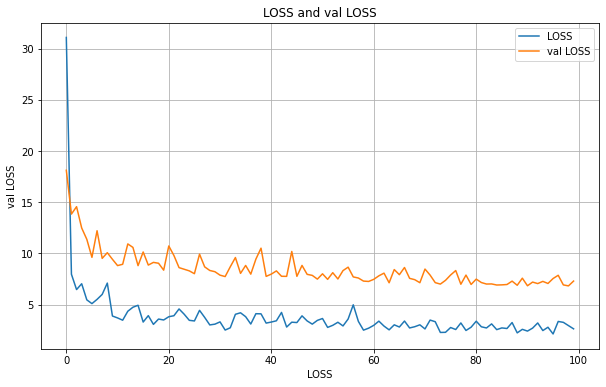

7/7 [==============================] - 0s 9ms/step


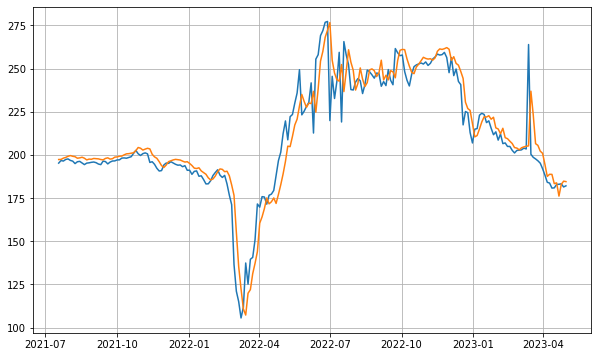

{'mae': 7.2704544, 'mse': 132.40869, 'rmse': 11.506898, 'mape': 3.6144423, 'mase': 1.3433452}


In [9]:
count = 0
eval_models_2 = {}

for i in range(1,11):
    time, series, currency = open_file(i)

    split_time = 1000
    window_size = 20
    batch_size = 32
    shuffle_buffer_size = 1000

    train_set, valid_set = prepared_data(series, time, split_time, window_size, batch_size, shuffle_buffer_size)

    model = second_model(train_set, valid_set, window_size)
    evaluate_model(model, series, split_time, window_size, batch_size, count, eval_models_2, currency[count])
    
    count += 1

In [10]:
import pandas as pd
model_results = pd.DataFrame(eval_models_1).T
model_results.head(100)

,mae,mse,rmse,mape,mase
model_EUR/IDR,180.638809,44457.468750,210.849396,1.128501,2.485637
model_USD/IDR,67.472534,9037.369141,95.065079,0.454502,1.473086
model_JPY/IDR,0.922608,1.388552,1.178369,0.798118,1.452647
model_GBP/IDR,120.951591,26205.833984,161.882156,0.658562,1.274890
model_SGD/IDR,59.546661,5704.913574,75.530876,0.546181,1.841496
model_AUD/IDR,86.117905,11781.028320,108.540443,0.836380,1.387527
model_CNY/IDR,14.643979,321.455719,17.929186,0.660910,1.972702
model_CAD/IDR,182.590775,38881.832031,197.184769,1.612439,3.842569
model_MYR/IDR,26.192617,1027.688232,32.057575,0.772112,2.309118
model_RUB/IDR,6.745857,127.111771,11.274385,3.345011,1.246416


In [12]:
import pandas as pd
model_results = pd.DataFrame(eval_models_2).T
model_results.head(100)

,mae,mse,rmse,mape,mase
model_EUR/IDR,312.086517,112480.781250,335.381531,1.952010,4.294391
model_USD/IDR,84.216240,11516.590820,107.315384,0.565788,1.838641
model_JPY/IDR,1.754505,4.074326,2.018496,1.495649,2.762469
model_GBP/IDR,242.074081,78377.453125,279.959747,1.305084,2.551582
model_SGD/IDR,57.932564,5340.217773,73.076797,0.532364,1.791580
model_AUD/IDR,86.647018,11845.235352,108.835815,0.840478,1.396052
model_CNY/IDR,20.578049,587.327454,24.234840,0.933275,2.772085
model_CAD/IDR,111.247337,17387.718750,131.862503,0.977133,2.341168
model_MYR/IDR,25.554602,1062.895874,32.602085,0.749409,2.252871
model_RUB/IDR,7.270454,132.408691,11.506898,3.614442,1.343345


In [13]:
# into_future = 30

# future_forecast = make_future_forecast(values=series,
#                                        model=model,
#                                        into_future=into_future,
#                                        window_size=window_size)

# next_time_steps = np.arange(time[-1] + 1, time[-1] + 1 + into_future)
# next_time_steps

# # Insert last timestep/final price into next time steps and future forecasts so the plot connects
# next_time_steps = np.insert(next_time_steps, 0, time[-1])
# future_forecast = np.insert(future_forecast, 0, series[-1])

# plt.figure(figsize=(15,7))
# plot_time_series(time, series, start=3600, format="-", label=f"Actual {currency[0]}/IDR")
# plot_time_series(next_time_steps, future_forecast, format="-", label=f"Predicted {currency[0]}/IDR")